In [37]:
import sys
sys.path.append('..')

In [38]:
import os
import pycolmap
from pathlib import Path

import json

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from tqdm import tqdm

from hloc.utils.io import list_h5_names, get_matches

from imc2023.utils.eval import eval

In [39]:
DIR = "../image-matching-challenge-2023"
MODE = "train"

datasets = {
    "heritage": ["cyprus", "dioscuri", "wall"],
    "haiper": ["bike", "chairs", "fountain"],
    "urban": ["kyiv-puppet-theater"],
}

out_dir = Path("../outputs")

In [40]:
runs = os.listdir(out_dir)
runs = [r for r in runs if not r.startswith(".")]
runs = sorted(runs)

fil = ["disk", 'loftr', 'ensemble', 'SG']

runs = [r for r in runs if all(f not in r for f in fil)]

len(runs)

29

In [41]:
metrics = {}

for ds in datasets.keys():
    metrics[ds] = {}
    for scene in datasets[ds]:
        metrics[ds][scene] = {}

        img_dir = f"{DIR}/{MODE}/{ds}/{scene}/images"
        images = sorted(os.listdir(img_dir))
        
        metrics[ds][scene]["images"] = images

## Get models for each run

In [42]:
for ds in datasets.keys():
    for scene in datasets[ds]:
        for r in runs:
            model_dir = out_dir / r / ds / scene / "sparse"
            try:
                model = pycolmap.Reconstruction(model_dir)
            except ValueError:
                print(f"No model found for {ds}/{scene} in {r}")

                metrics[ds][scene][r] = {
                    "reg_images": [],
                    "num_reg_images": 0,
                    "model": None,
                }
                continue

            reg_images = [img.name for img in model.images.values()]
            reg_images = sorted(reg_images)
            metrics[ds][scene][r] = {
                "reg_images": reg_images,
                "num_reg_images": len(reg_images),
                "model": model,
            }

No model found for heritage/cyprus in DISK+LG
No model found for heritage/cyprus in sift+NN
No model found for heritage/dioscuri in DISK+SP+LG-rot-sci
No model found for haiper/chairs in sift+NN
No model found for haiper/chairs in sift+NN-old
No model found for urban/kyiv-puppet-theater in sift+NN
No model found for urban/kyiv-puppet-theater in sift+NN-old


## Get eval for each run

In [43]:
create_score = {r: True for r in runs}

for ds in datasets.keys():
    for scene in datasets[ds]:
        pbar = tqdm(runs, desc=f"{ds}/{scene}")
        for r in pbar:
            submission = Path(f"{out_dir}/{r}/submission.csv")
            scores = Path(f"{out_dir}/{r}/scores.json")

            if scores.exists() and not create_score[r]:
                with open(scores, "r") as f:
                    metrics[ds][scene][r]["scores"] = json.load(f)
                continue

            if submission.exists():
                try:
                    metrics[ds][scene][r]["scores"] = eval(
                        submission, DIR, verbose=False, return_dict=True,
                    )
                    create_score[r] = False
                except:
                    metrics[ds][scene][r]["scores"] = None
            else:
                metrics[ds][scene][r]["scores"] = None

            if metrics[ds][scene][r]["scores"] is not None:
                # write scores to file
                with open(f"{out_dir}/{r}/scores.json", "w") as f:
                    json.dump(metrics[ds][scene][r]["scores"], f, indent=4)

                    


urban/kyiv-puppet-theater: 100%|██████████| 29/29 [00:00<00:00, 12946.76it/s]


## Get runtimes

In [44]:
for ds in datasets:
    for scene in datasets[ds]:
        for r in runs:
            timings_path = f"{out_dir}/{r}/{ds}/{scene}/timings.json"

            timings = None
            if os.path.exists(timings_path):
                with open(timings_path, "r") as f:
                    timings = json.load(f)
                
            metrics[ds][scene][r]["timings"] = timings

## Create dataframe

In [45]:
df = []

pipline_steps = ['preprocessing', 'pairs-extraction', 'feature-extraction', 'feature-matching', 'create-ensemble', 'rotate-keypoints', 'sfm', 'localize-unreg']

for r in runs:
    row = ()
    cols = ()
    row += (r,)
    cols += ("run",)

    if metrics["heritage"]["cyprus"][r]["scores"] is not None:
        row += (metrics["heritage"]["cyprus"][r]["scores"]["mAA"],)
        cols += ("mAA",)


        for ds in datasets:
            scene = datasets[ds][0]
            row += (metrics[ds][scene][r]["scores"][ds]["mAA"],)
            cols += (f"{ds}_mAA",)
            for scene in datasets[ds]:
                row += (
                    metrics[ds][scene][r]["scores"][ds][scene]["mAA_t"],
                    metrics[ds][scene][r]["scores"][ds][scene]["mAA_q"],
                    metrics[ds][scene][r]["scores"][ds][scene]["mAA"],
                )
                cols += (
                    f"{ds}_{scene}_mAA_t",
                    f"{ds}_{scene}_mAA_q",
                    f"{ds}_{scene}_mAA",
                )
    else:
        for ds in datasets:
            row += (0,)
            cols += (f"{ds}_mAA",)
            for scene in datasets[ds]:
                row += (0, 0, 0,)
                cols += (
                    f"{ds}_{scene}_mAA_t",
                    f"{ds}_{scene}_mAA_q",
                    f"{ds}_{scene}_mAA",
                )

    if metrics["heritage"]["cyprus"][r]["model"] is not None:
        for ds in datasets:
            for scene in datasets[ds]:
                row += (metrics[ds][scene][r]["num_reg_images"],)
                cols += (f"{ds}_{scene}_num_reg_images",)
    else:
        for ds in datasets:
            for scene in datasets[ds]:
                row += (0,)
                cols += (f"{ds}_{scene}_num_reg_images",)

    for ds in datasets:
        for scene in datasets[ds]:
            if metrics[ds][scene][r]["timings"] is not None:
                for step in pipline_steps:
                    row += (metrics[ds][scene][r]["timings"][step],)
                    cols += (f"{ds}_{scene}_{step}_time",)
            else:
                for step in pipline_steps:
                    row += (0,)
                    cols += (f"{ds}_{scene}_{step}_time",)
                
    df.append(row)

df = pd.DataFrame(df, columns=cols)

df.sort_values(by=["run"], inplace=True, ascending=True)
df.set_index("run", inplace=True, drop=False)

df

run  \
run                                                                        
DISK+LG                                                          DISK+LG   
DISK+LG+sift+NN-rot                                  DISK+LG+sift+NN-rot   
DISK+LG+sift+NN-rot-pixsfm                    DISK+LG+sift+NN-rot-pixsfm   
DISK+LG+sift+NN-rot-pixsfm-sci            DISK+LG+sift+NN-rot-pixsfm-sci   
DISK+LG-rot                                                  DISK+LG-rot   
DISK+LG-rot-1600px                                    DISK+LG-rot-1600px   
DISK+LG-rot-pixsfm                                    DISK+LG-rot-pixsfm   
DISK+LG-rot-pixsfm-1600px                      DISK+LG-rot-pixsfm-1600px   
DISK+LG-rot-pixsfm-sci                            DISK+LG-rot-pixsfm-sci   
DISK+SP+LG-rot                                            DISK+SP+LG-rot   
DISK+SP+LG-rot-1600px                              DISK+SP+LG-rot-1600px   
DISK+SP+LG-rot-pixsfm                              DISK+SP+LG-rot-pixsfm   
DISK+SP+LG-rot-pixsfm-1600px-sci        DISK+SP+LG-rot-pixsfm-1600px-sci   
DISK+SP+LG-rot-pixsfm-sci                      DISK+SP+LG-rot-pixsfm-sci   
DISK+SP+LG-rot-sci                                    DISK+SP+LG-rot-sci   
SP+LG+exhaustive-rot                                SP+LG+exhaustive-rot   
SP+LG+sift+NN-rot                                      SP+LG+sift+NN-rot   
SP+LG+sift+NN-rot-pixsfm                        SP+LG+sift+NN-rot-pixsfm   
SP+LG+sift+NN-rot-pixsfm-1600px-sci  SP+LG+sift+NN-rot-pixsfm-1600px-sci   
SP+LG+sift+NN-rot-pixsfm-sci                SP+LG+sift+NN-rot-pixsfm-sci   
SP+LG-rot                                                      SP+LG-rot   
SP+LG-rot-1600px                                        SP+LG-rot-1600px   
SP+LG-rot-pixsfm                                        SP+LG-rot-pixsfm   
SP+LG-rot-pixsfm-1600px                          SP+LG-rot-pixsfm-1600px   
SP+LG-rot-pixsfm-1600px-sci                  SP+LG-rot-pixsfm-1600px-sci   
SP+LG-rot-pixsfm-sci                                SP+LG-rot-pixsfm-sci   
SP+LG-rot-sci                                              SP+LG-rot-sci   
sift+NN                                                          sift+NN   
sift+NN-old                                                  sift+NN-old   

                                          mAA  heritage_mAA  \
run                                                           
DISK+LG                              0.610733      0.391017   
DISK+LG+sift+NN-rot                  0.720306      0.687547   
DISK+LG+sift+NN-rot-pixsfm           0.700360      0.515641   
DISK+LG+sift+NN-rot-pixsfm-sci       0.822084      0.765972   
DISK+LG-rot                          0.746279      0.625685   
DISK+LG-rot-1600px                   0.368688      0.200690   
DISK+LG-rot-pixsfm                   0.657996      0.438581   
DISK+LG-rot-pixsfm-1600px            0.373534      0.208768   
DISK+LG-rot-pixsfm-sci               0.726435      0.531982   
DISK+SP+LG-rot                       0.825781      0.683876   
DISK+SP+LG-rot-1600px                0.408843      0.249661   
DISK+SP+LG-rot-pixsfm                0.803276      0.710020   
DISK+SP+LG-rot-pixsfm-1600px-sci     0.852138      0.805119   
DISK+SP+LG-rot-pixsfm-sci            0.860679      0.777570   
DISK+SP+LG-rot-sci                   0.749124      0.496314   
SP+LG+exhaustive-rot                 0.735356      0.670298   
SP+LG+sift+NN-rot                    0.809958      0.699488   
SP+LG+sift+NN-rot-pixsfm             0.783899      0.675141   
SP+LG+sift+NN-rot-pixsfm-1600px-sci  0.799059      0.694452   
SP+LG+sift+NN-rot-pixsfm-sci         0.816391      0.752727   
SP+LG-rot                            0.783511      0.633125   
SP+LG-rot-1600px                     0.390943      0.230736   
SP+LG-rot-pixsfm                     0.764002      0.620031   
SP+LG-rot-pixsfm-1600px              0.392797      0.228184   
SP+LG-rot-pixsfm-1600px-sci          0.786714      0.651481   
SP+LG-rot-p

In [46]:
df.loc["DISK+LG", "heritage_mAA"]

0.39101704955101013

# Get best runs

In [47]:
df[["mAA"]].sort_values(by=["mAA"], ascending=False)

mAA
run                                          
DISK+SP+LG-rot-pixsfm-sci            0.860679
DISK+SP+LG-rot-pixsfm-1600px-sci     0.852138
DISK+SP+LG-rot                       0.825781
DISK+LG+sift+NN-rot-pixsfm-sci       0.822084
SP+LG+sift+NN-rot-pixsfm-sci         0.816391
SP+LG-rot-pixsfm-sci                 0.809999
SP+LG+sift+NN-rot                    0.809958
DISK+SP+LG-rot-pixsfm                0.803276
SP+LG+sift+NN-rot-pixsfm-1600px-sci  0.799059
SP+LG-rot-pixsfm-1600px-sci          0.786714
SP+LG+sift+NN-rot-pixsfm             0.783899
SP+LG-rot                            0.783511
SP+LG-rot-pixsfm                     0.764002
DISK+SP+LG-rot-sci                   0.749124
DISK+LG-rot                          0.746279
SP+LG+exhaustive-rot                 0.735356
DISK+LG-rot-pixsfm-sci               0.726435
SP+LG-rot-sci                        0.723297
DISK+LG+sift+NN-rot                  0.720306
DISK+LG+sift+NN-rot-pixsfm           0.700360
DISK+LG-rot-pixsfm                   0.657996
DISK+LG                              0.610733
DISK+SP+LG-rot-1600px                0.408843
SP+LG-rot-pixsfm-1600px              0.392797
SP+LG-rot-1600px                     0.390943
DISK+LG-rot-pixsfm-1600px            0.373534
DISK+LG-rot-1600px                   0.368688
sift+NN-old                          0.355741
sift+NN                              0.278251

In [48]:
# get the best run for each dataset and scene from the dataframe

max_str = max(len(ds) + len(scene) for ds in datasets.keys() for scene in datasets[ds]) + 1

for ds in datasets:
    for scene in datasets[ds]:
        name = df.loc[:, f"{ds}_{scene}_mAA"].idxmax()
        # name = df.iloc[idx].run
        mAA = df.loc[name, f"{ds}_{scene}_mAA"]
        print(f"{f'{ds}/{scene}':{max_str}}: {mAA:.4f} ({name})")

    print()



heritage/cyprus          : 0.9333 (DISK+LG+sift+NN-rot-pixsfm-sci)
heritage/dioscuri        : 0.7901 (SP+LG+sift+NN-rot-pixsfm-sci)
heritage/wall            : 0.8609 (SP+LG+sift+NN-rot-pixsfm-sci)

haiper/bike              : 0.9286 (DISK+LG)
haiper/chairs            : 0.9833 (DISK+SP+LG-rot-pixsfm-1600px-sci)
haiper/fountain          : 1.0000 (DISK+SP+LG-rot-pixsfm)

urban/kyiv-puppet-theater: 0.8532 (SP+LG-rot-sci)



## Plot scores

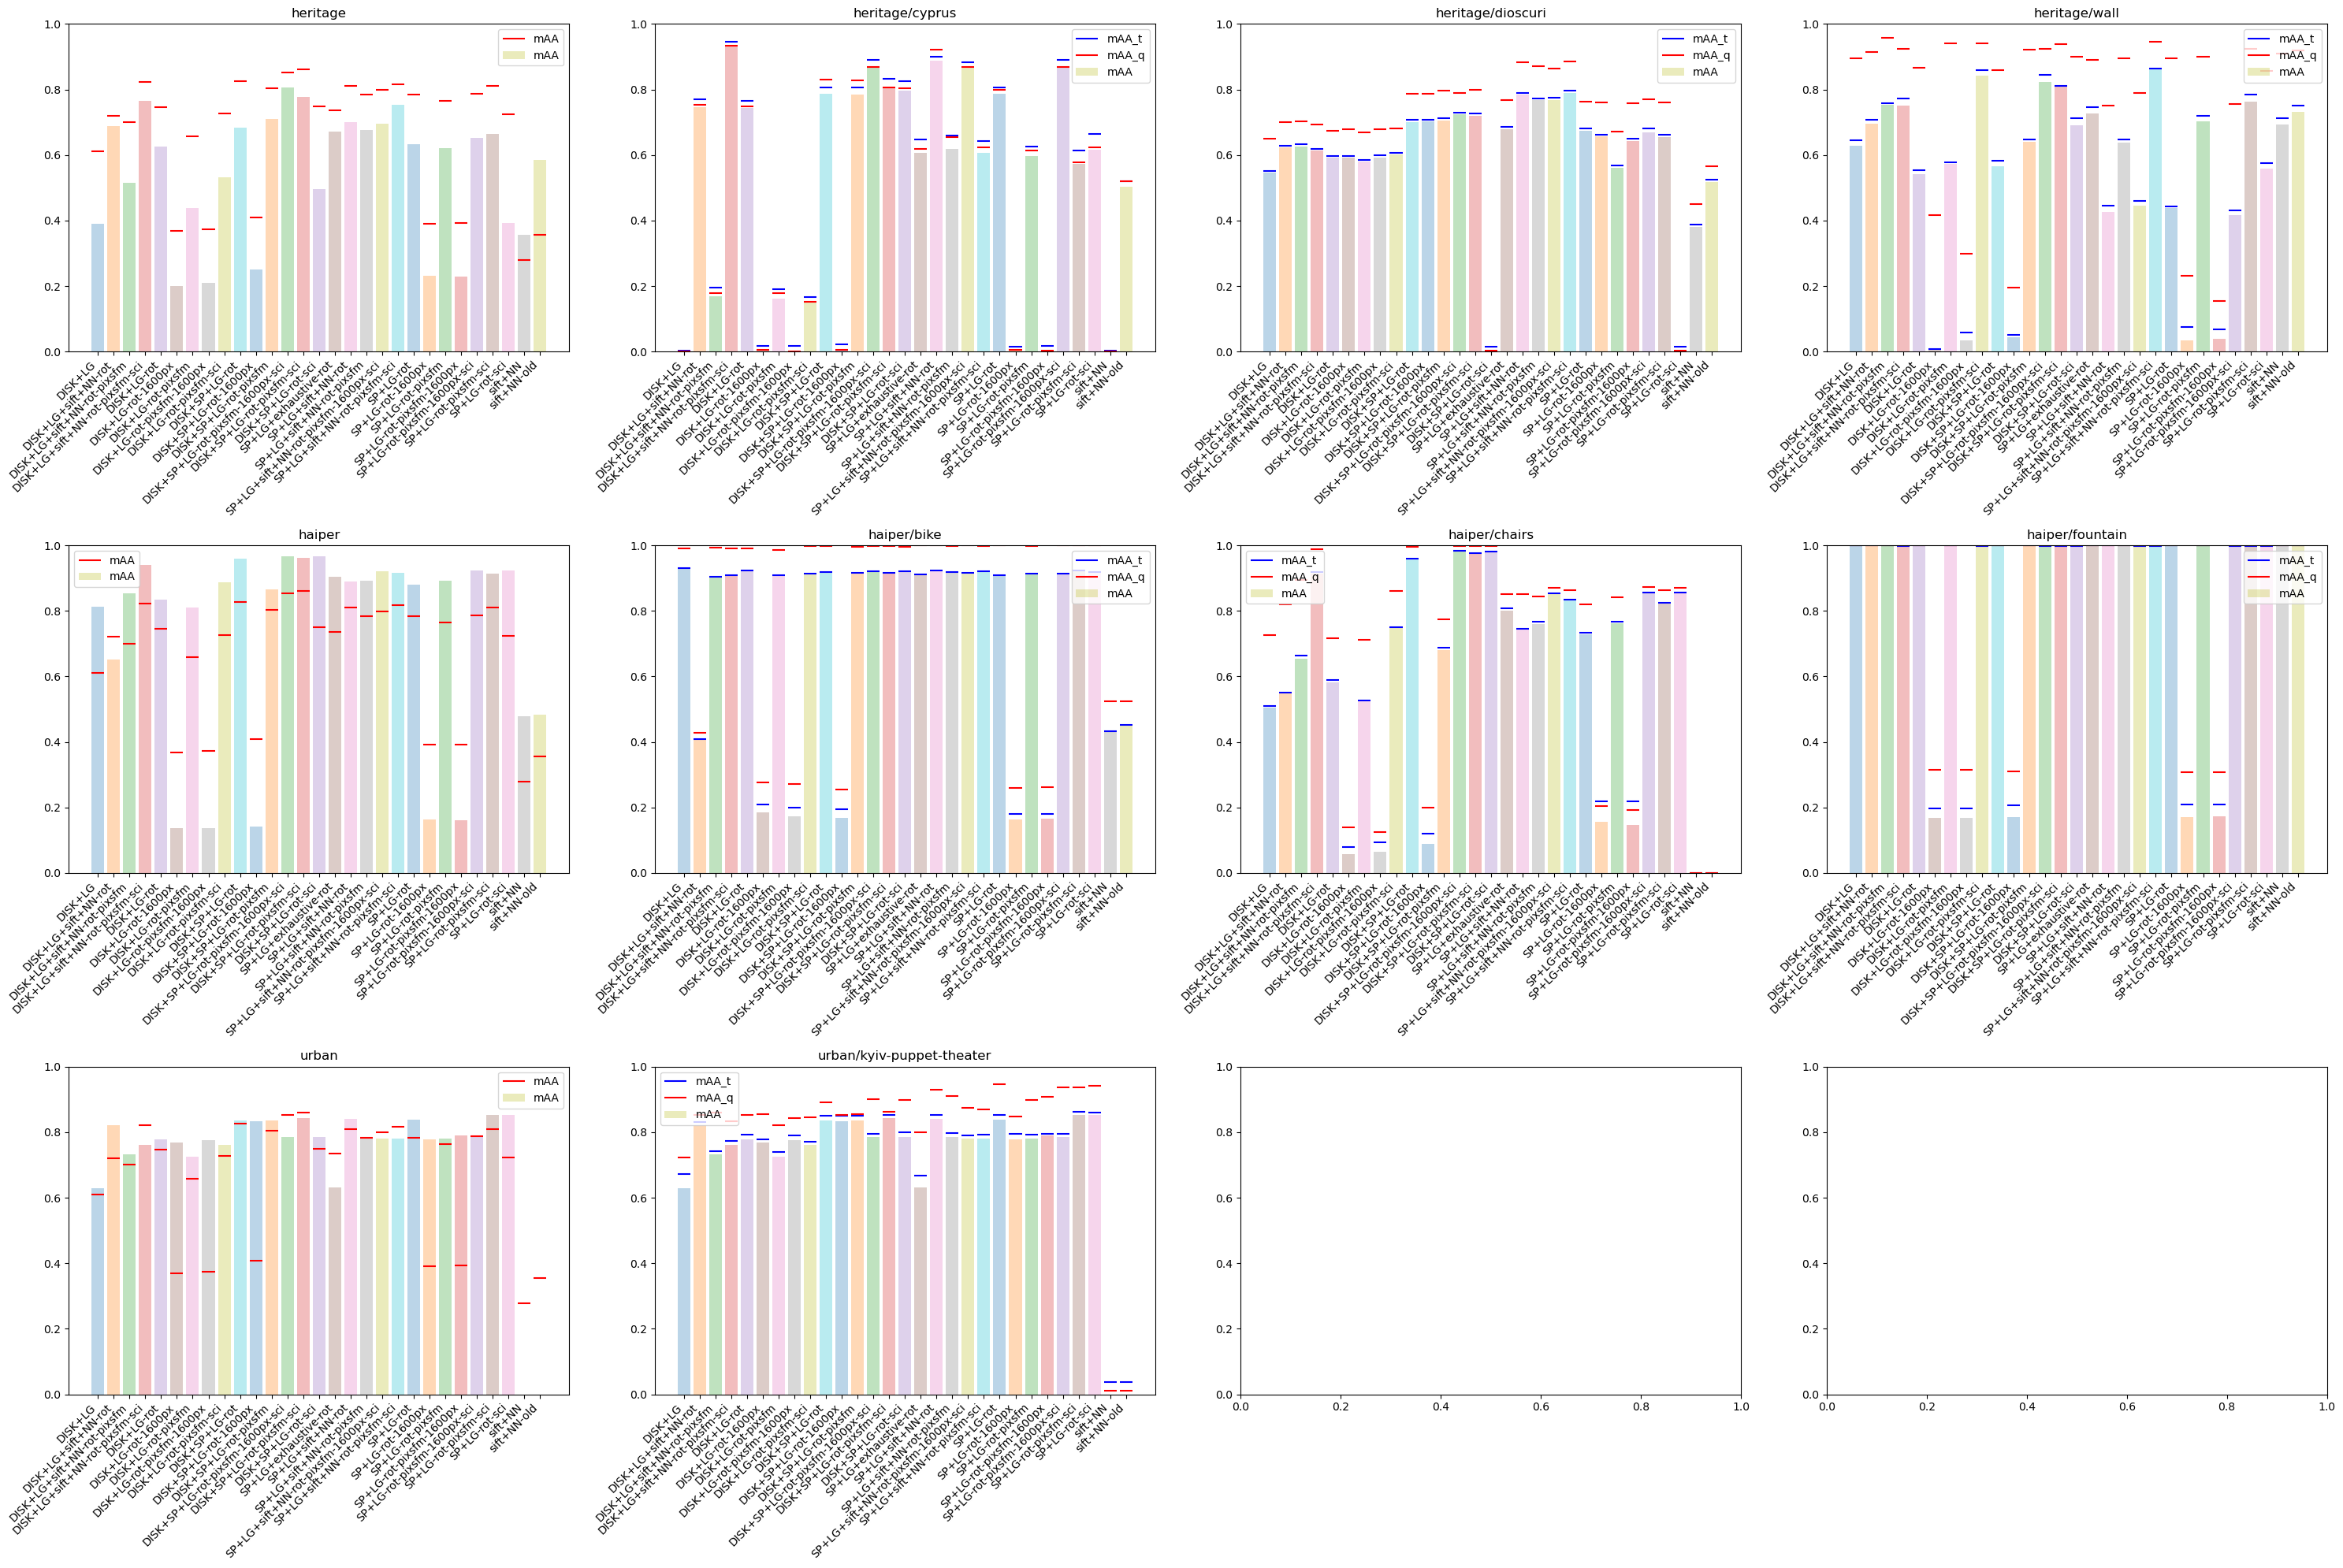

In [49]:
fig, ax = plt.subplots(len(datasets), len(datasets["heritage"])+1, figsize=(30, 20))

for i, ds in enumerate(datasets.keys()):
    for r in df.index:
        name = df.loc[r, "run"]
        ds_mAA = df.loc[r, f"{ds}_mAA"]
        mAA = df.loc[r, "mAA"]
        ax[i, 0].bar(
            name,
            ds_mAA,
            alpha=0.3,
            label="mAA" if r == df.index[-1] else "",
        )

        ax[i, 0].hlines(
            mAA,
            df.index.tolist().index(r) - 0.4,
            df.index.tolist().index(r) + 0.4,
            color="red",
            label="mAA" if r == df.index[-1] else "",
        )

        # rotate the xticklabels
        for tick in ax[i, 0].get_xticklabels():
            tick.set_rotation(45)
            tick.set_ha("right")

    ax[i, 0].set_ylim([0, 1])
    ax[i, 0].set_title(ds)
    ax[i, 0].legend()


    for j, scene in enumerate(datasets[ds]):
        for r in df.index:
            name = df.loc[r, "run"]
            mAA = df.loc[r, f"{ds}_{scene}_mAA"]
            mAA_t = df.loc[r, f"{ds}_{scene}_mAA_t"]
            mAA_q = df.loc[r, f"{ds}_{scene}_mAA_q"]

            ax[i, j+1].bar(
                name,
                mAA,
                alpha=0.3,
                label="mAA" if r == df.index[-1] else "",
            )

            ax[i, j+1].hlines(
                mAA_t,
                df.index.tolist().index(r) - 0.4,
                df.index.tolist().index(r) + 0.4,
                color="b",
                label="mAA_t" if r == df.index[-1] else "",
            )

            ax[i, j+1].hlines(
                mAA_q,
                df.index.tolist().index(r) - 0.4,
                df.index.tolist().index(r) + 0.4,
                color="r",
                label="mAA_q" if r == df.index[-1] else "",
            )

            # rotate x-axis labels and align them to the right
            for tick in ax[i, j+1].get_xticklabels():
                tick.set_rotation(45)
                tick.set_ha("right")

        ax[i, j+1].set_ylim(0, 1)
        ax[i, j+1].set_title(f"{ds}/{scene}")
        ax[i, j+1].legend()
            
plt.tight_layout()
plt.show()

## Plot num registered images

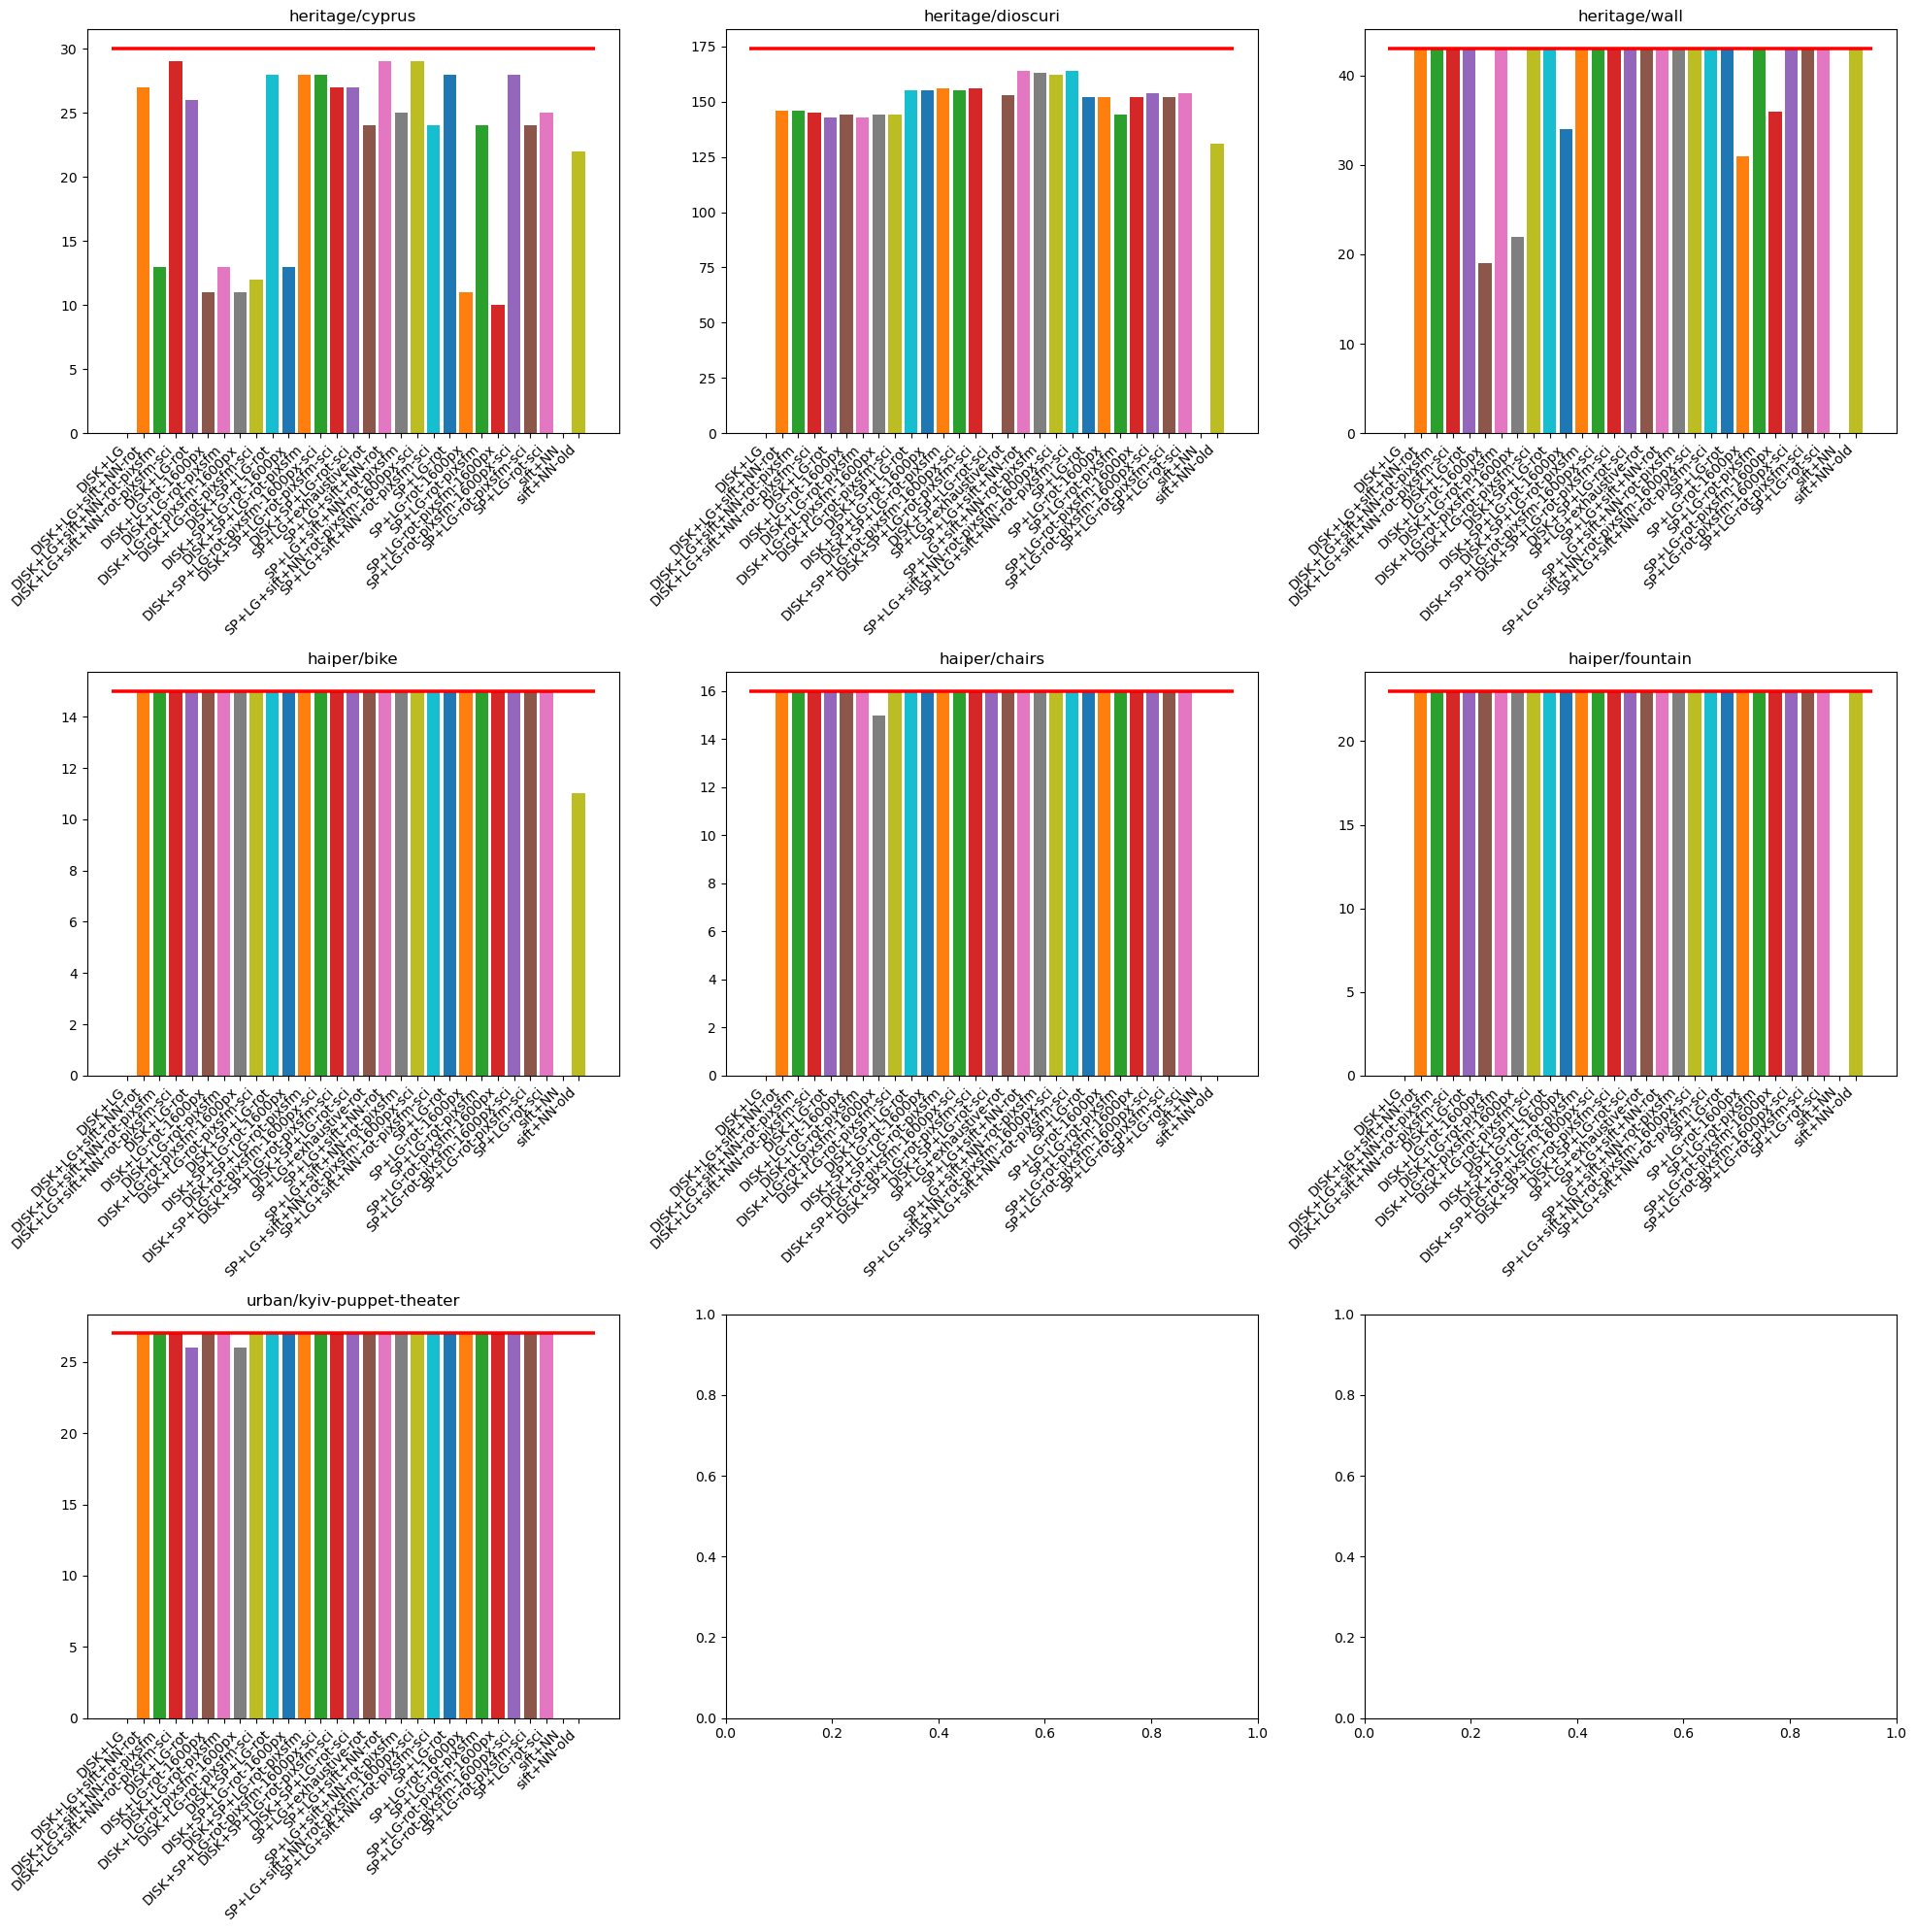

In [50]:
fig, ax = plt.subplots(len(datasets), len(datasets["heritage"]), figsize=(20, 20))

for i, ds in enumerate(datasets.keys()):
    for j, scene in enumerate(datasets[ds]):
        for r in df.index:
            name = df.loc[r, "run"]
            n_reg = df.loc[r, f"{ds}_{scene}_num_reg_images"]
            
            ax[i, j].bar(
                r,
                n_reg,
                label=f"{r}",
            )

            ax[i, j].hlines(
                len(metrics[ds][scene]["images"]),
                -1,
                len(runs),
                label=f"GT ({len(metrics[ds][scene]['images'])})",
                colors="r",
            )
            
            ax[i, j].set_title(f"{ds}/{scene}")

            # rotate x-axis labels and align them to the right
            for tick in ax[i, j].get_xticklabels():
                tick.set_rotation(45)
                tick.set_ha("right")

plt.tight_layout()
plt.show()

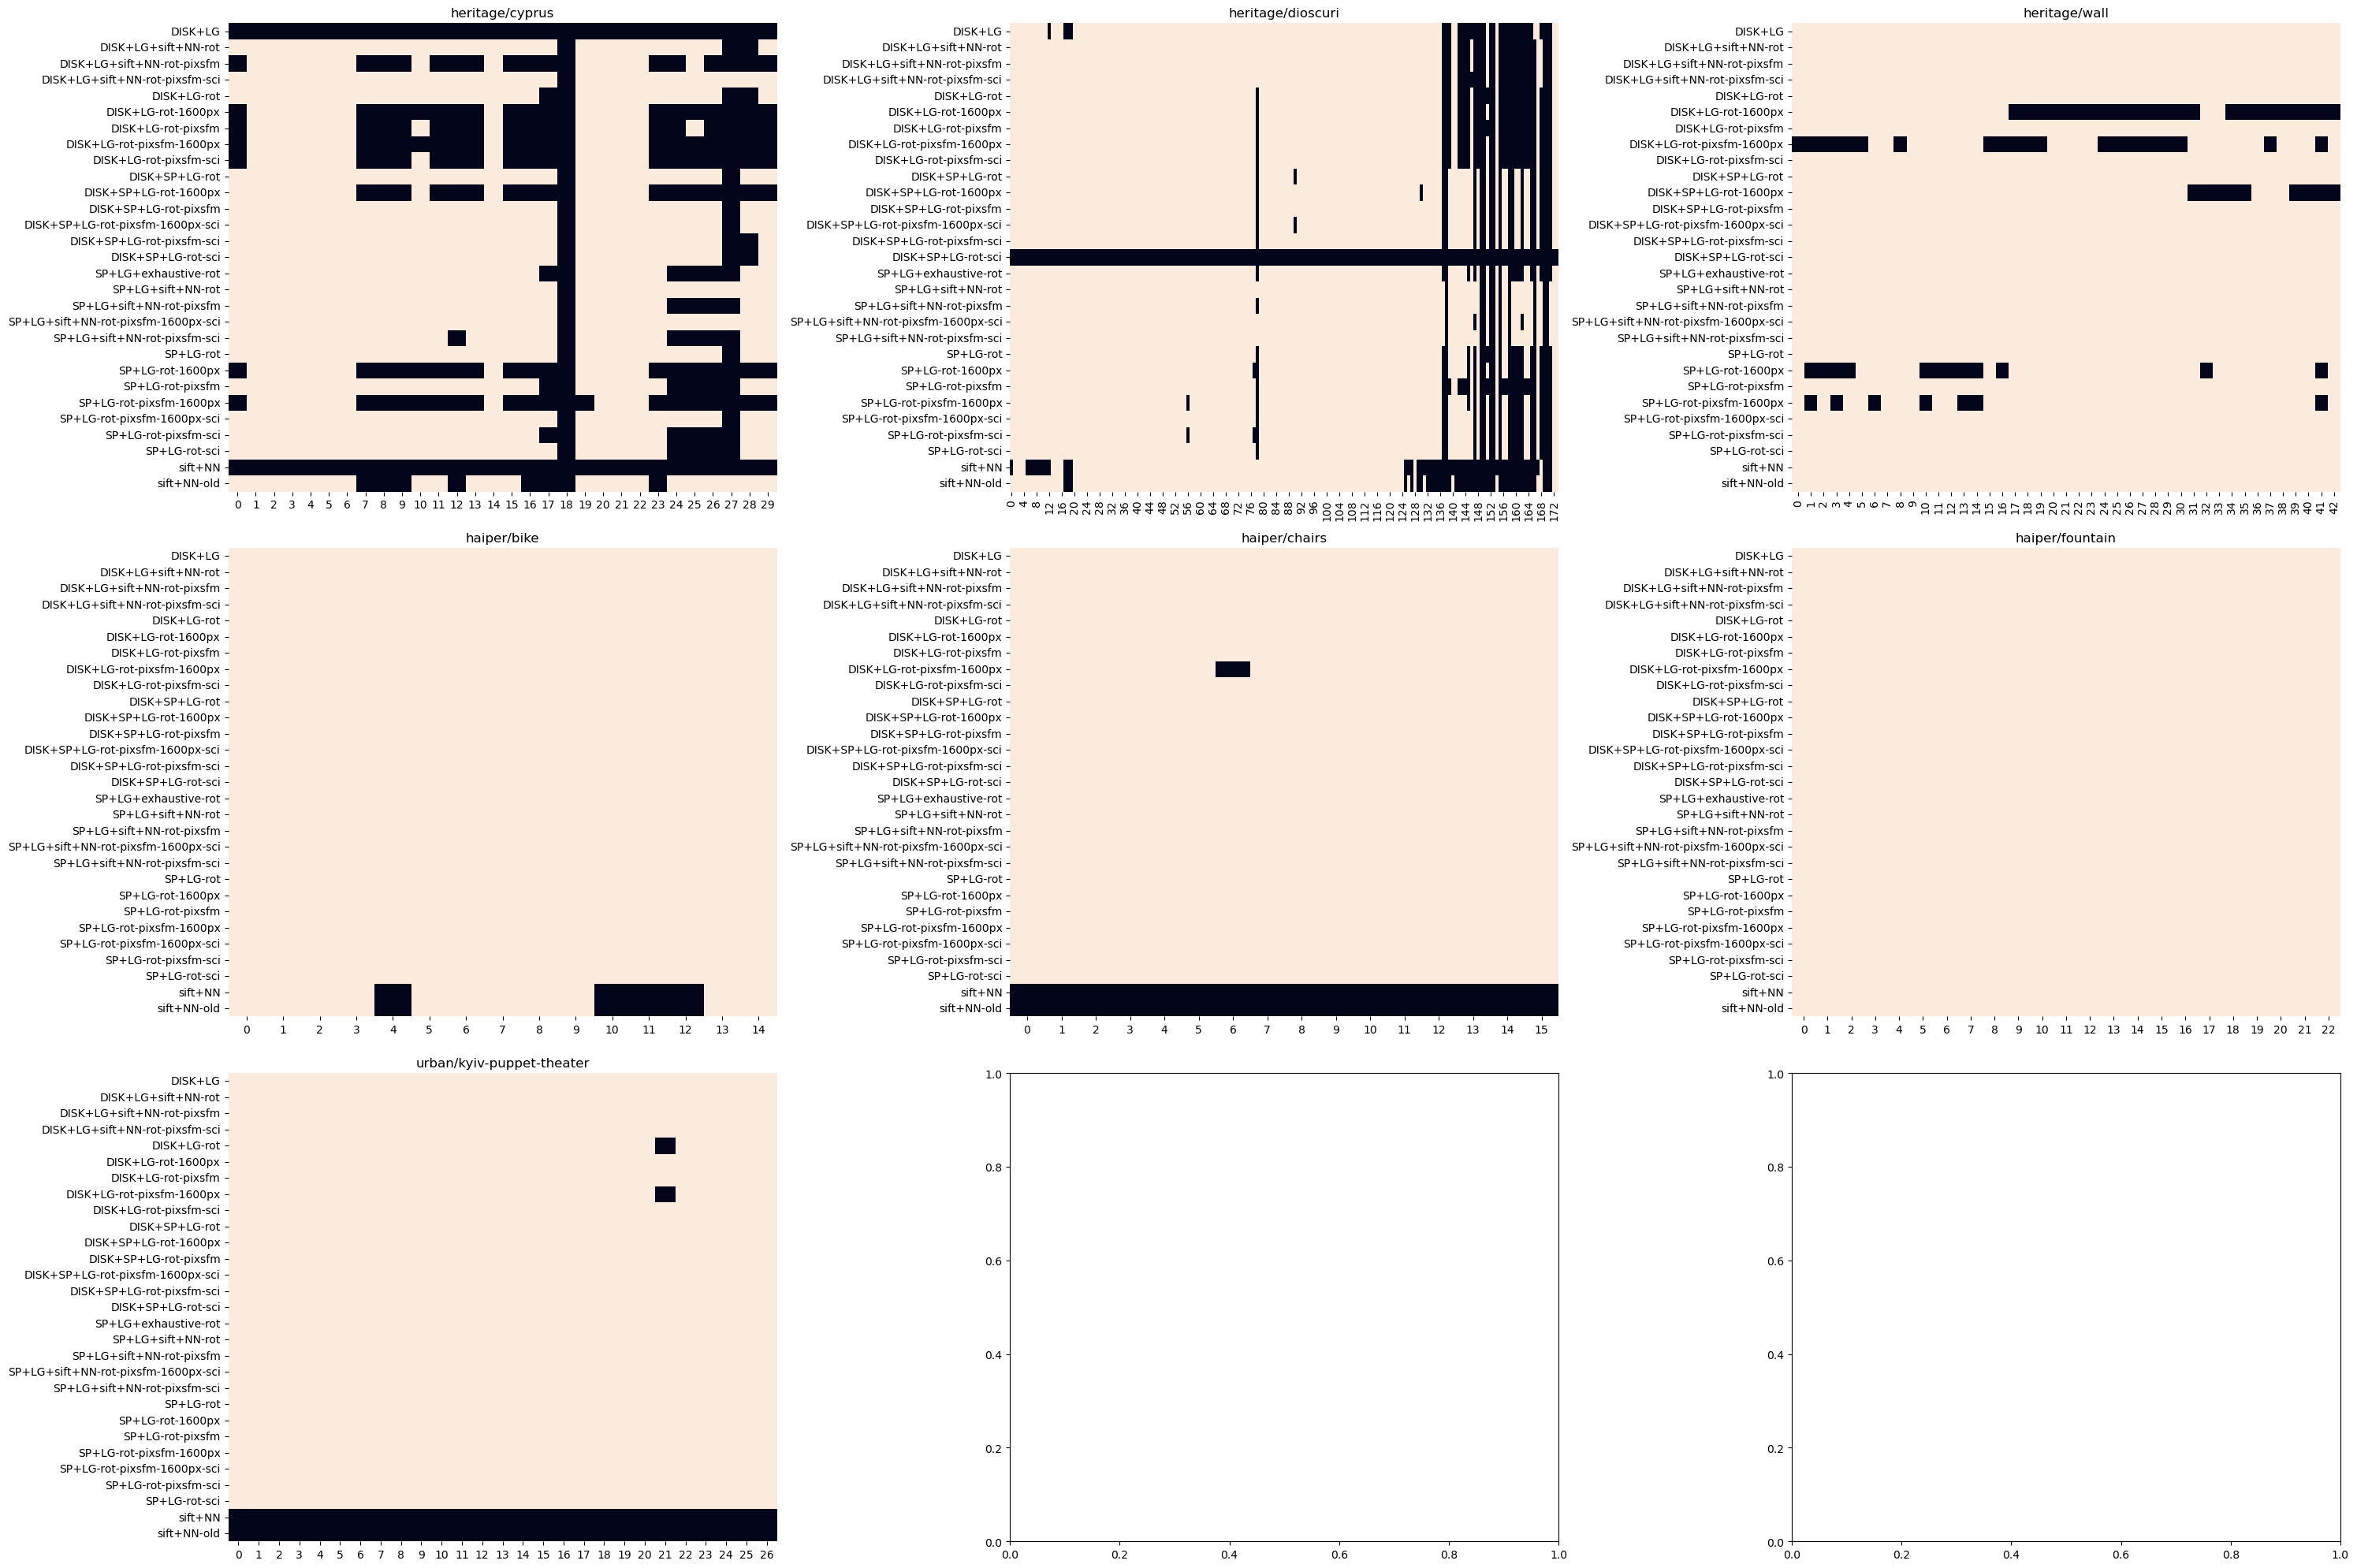

In [51]:
fig, ax = plt.subplots(len(datasets), len(datasets["heritage"]), figsize=(30, 20))

for i, ds in enumerate(datasets.keys()):
    for j, scene in enumerate(datasets[ds]):
        bool_img_run = np.zeros((len(runs), len(metrics[ds][scene]["images"])))
        
        for r_idx, r in enumerate(runs):
            if r not in metrics[ds][scene].keys():
                continue

            for img in metrics[ds][scene][r]["reg_images"]:
                img_idx = metrics[ds][scene]["images"].index(img)
                bool_img_run[r_idx, img_idx] = 1

        sns.heatmap(
            bool_img_run,
            ax=ax[i, j],
            cbar=False,
            vmin=0,
            vmax=1,
            yticklabels=runs,
        )
        ax[i, j].set_title(f"{ds}/{scene}")

# add more space between plots
plt.tight_layout()
plt.show()

## Compare Runtimes

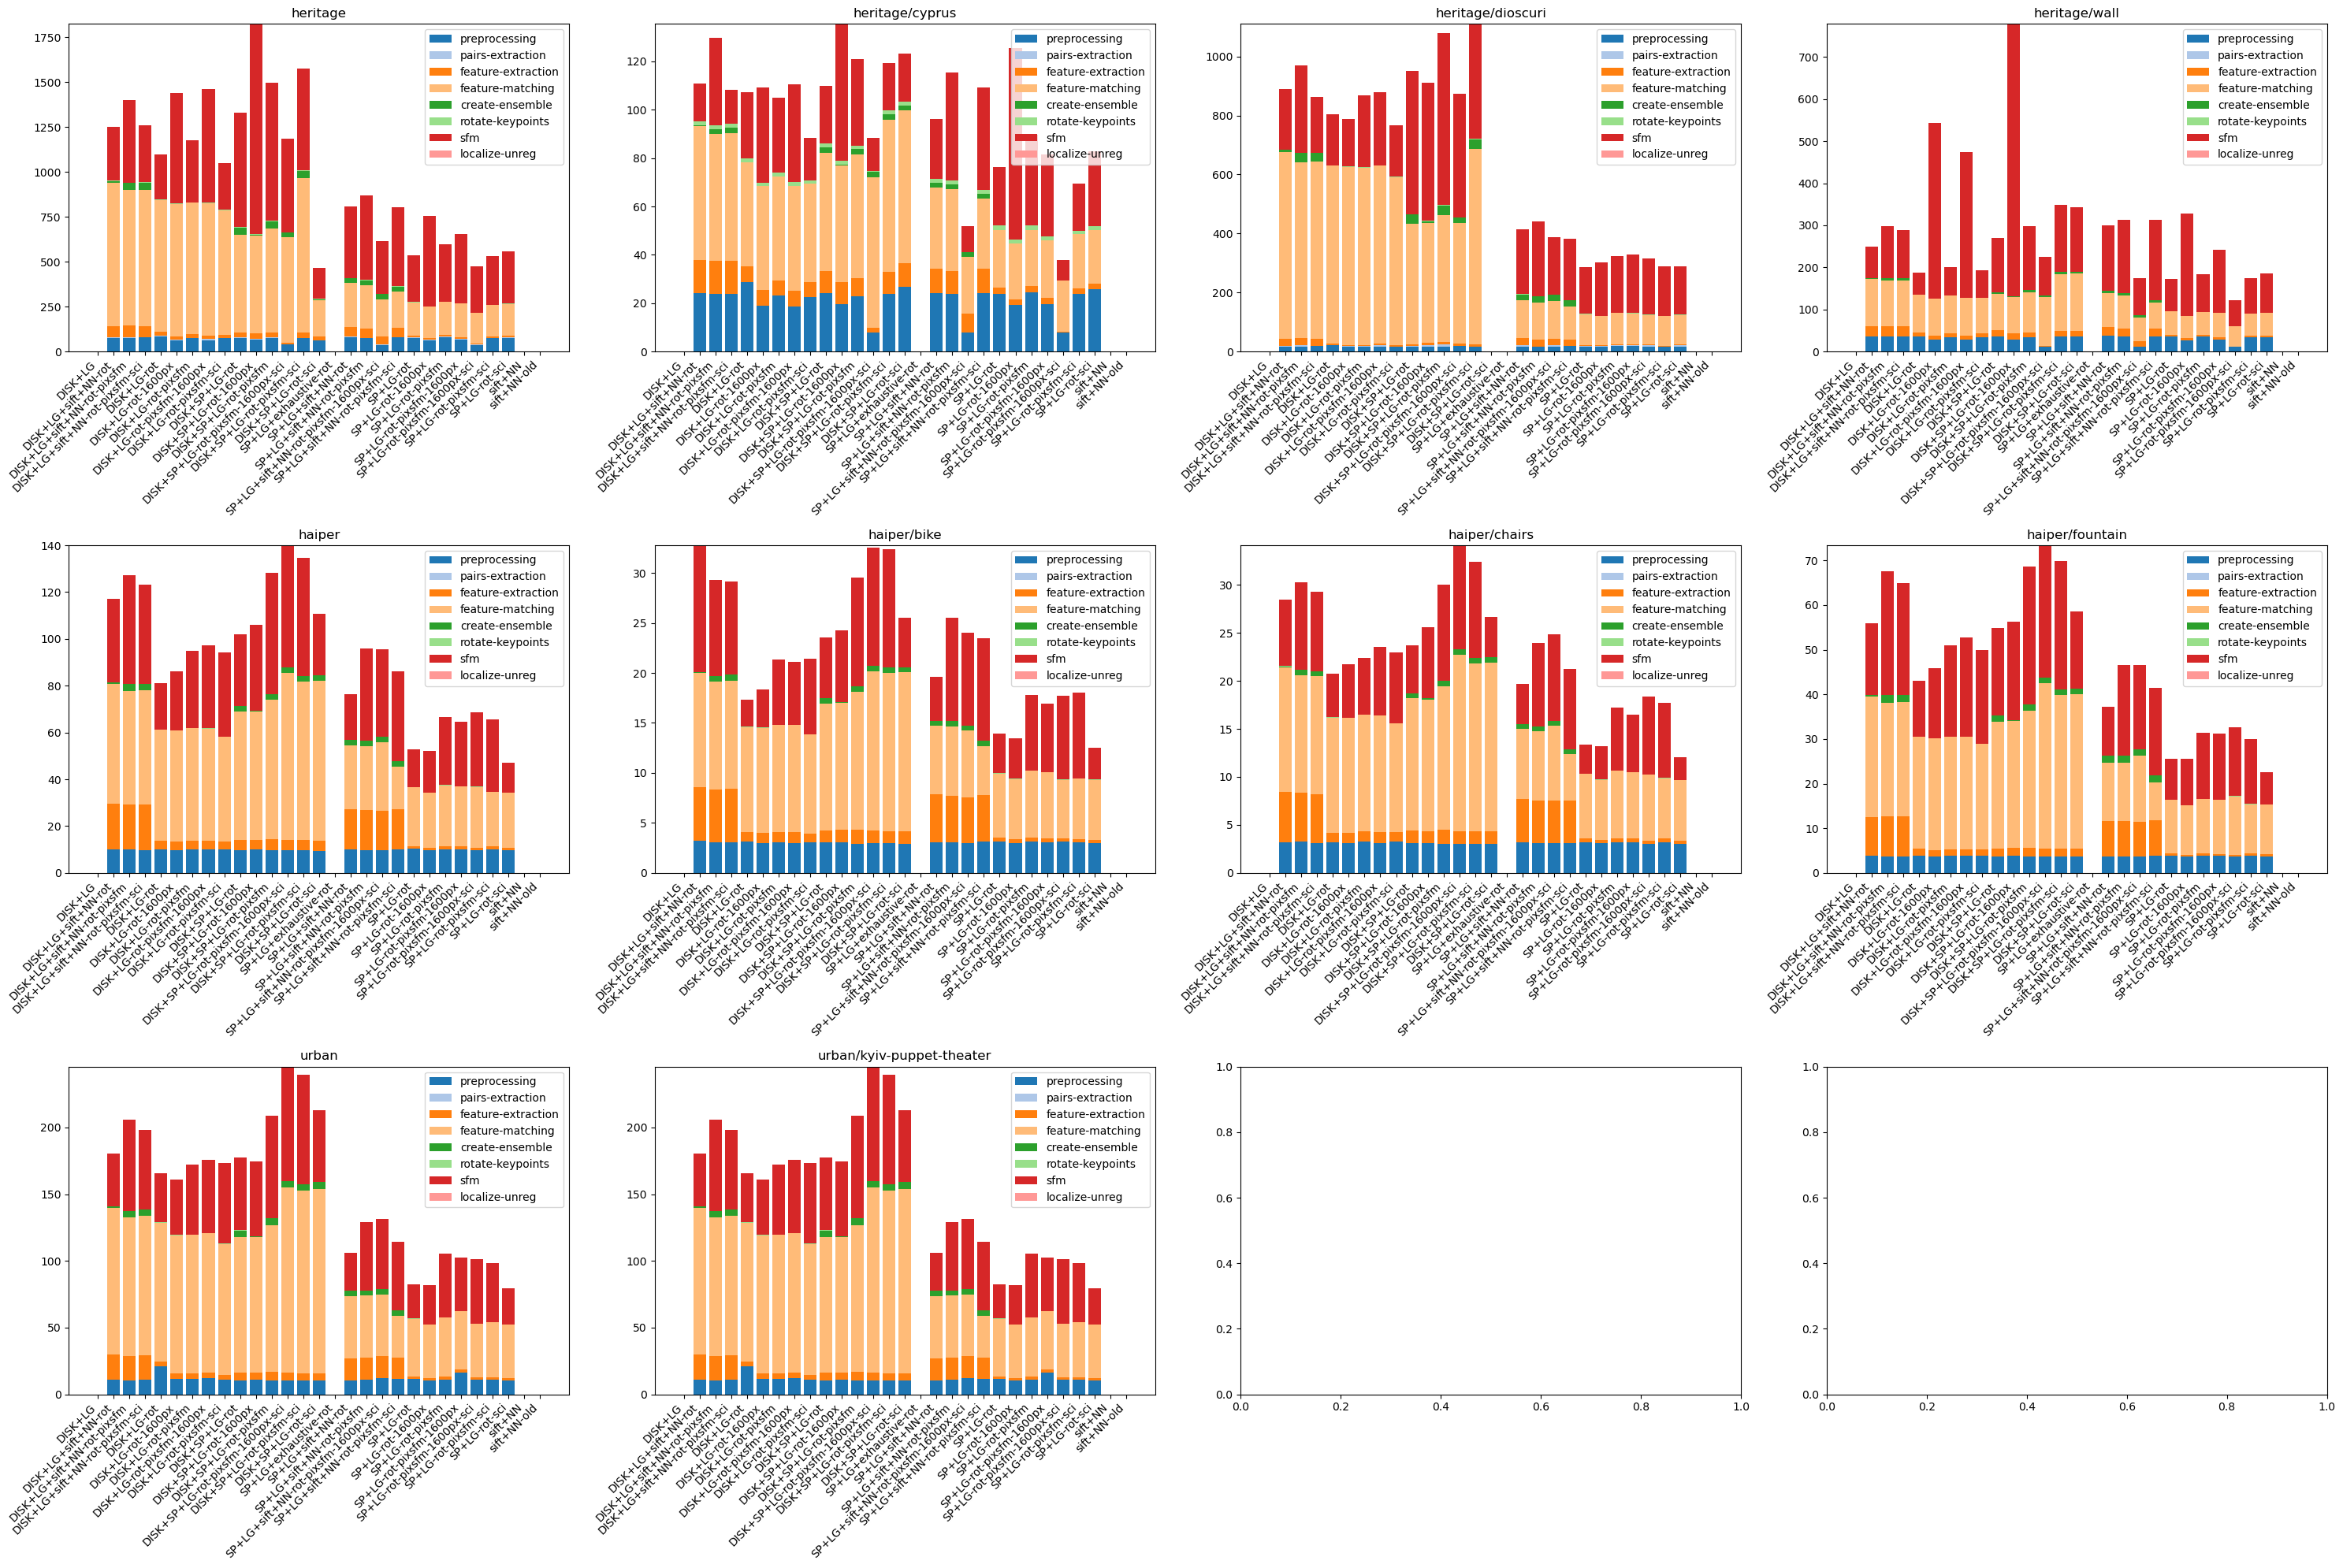

In [52]:
fig, ax = plt.subplots(len(datasets), len(datasets["heritage"])+1, figsize=(30, 20))

cmap = plt.get_cmap("tab20") 

for i, ds in enumerate(datasets.keys()):
    for r in df.index:
        name = df.loc[r, "run"]
        mean_times = [0 for _ in pipline_steps]
        for scene in datasets[ds]:
            for idx, step in enumerate(pipline_steps):
                mean_times[idx] += df.loc[r, f"{ds}_{scene}_{step}_time"]
        mean_times = [t / len(datasets[ds]) for t in mean_times]

        cumsum = 0
        for idx, step in enumerate(pipline_steps):
            ax[i, 0].bar(
                name,
                mean_times[idx],
                bottom=cumsum,
                label=step if r == df.index[-1] else "",
                color=cmap(idx),
            )
            cumsum += mean_times[idx]

        # rotate the xticklabels
        for tick in ax[i, 0].get_xticklabels():
            tick.set_rotation(45)
            tick.set_ha("right")

    ax[i, 0].set_title(ds)
    ax[i, 0].legend()


    for j, scene in enumerate(datasets[ds]):
        for r in df.index:
            name = df.loc[r, "run"]
            mean_times = [0 for _ in pipline_steps]
            for idx, step in enumerate(pipline_steps):
                mean_times[idx] += df.loc[r, f"{ds}_{scene}_{step}_time"]
            mean_times = [t / len(datasets[ds]) for t in mean_times]

            cumsum = 0
            for idx, step in enumerate(pipline_steps):
                ax[i, j+1].bar(
                    name,
                    mean_times[idx],
                    bottom=cumsum,
                    label=step if r == df.index[-1] else "",
                    color=cmap(idx),
                )
                cumsum += mean_times[idx]

            # rotate x-axis labels and align them to the right
            for tick in ax[i, j+1].get_xticklabels():
                tick.set_rotation(45)
                tick.set_ha("right")

        ax[i, j+1].set_title(f"{ds}/{scene}")
        ax[i, j+1].legend()

plt.tight_layout()
plt.show()

## Explore matches

heritage/cyprus: 100%|██████████| 29/29 [00:18<00:00,  1.54it/s]


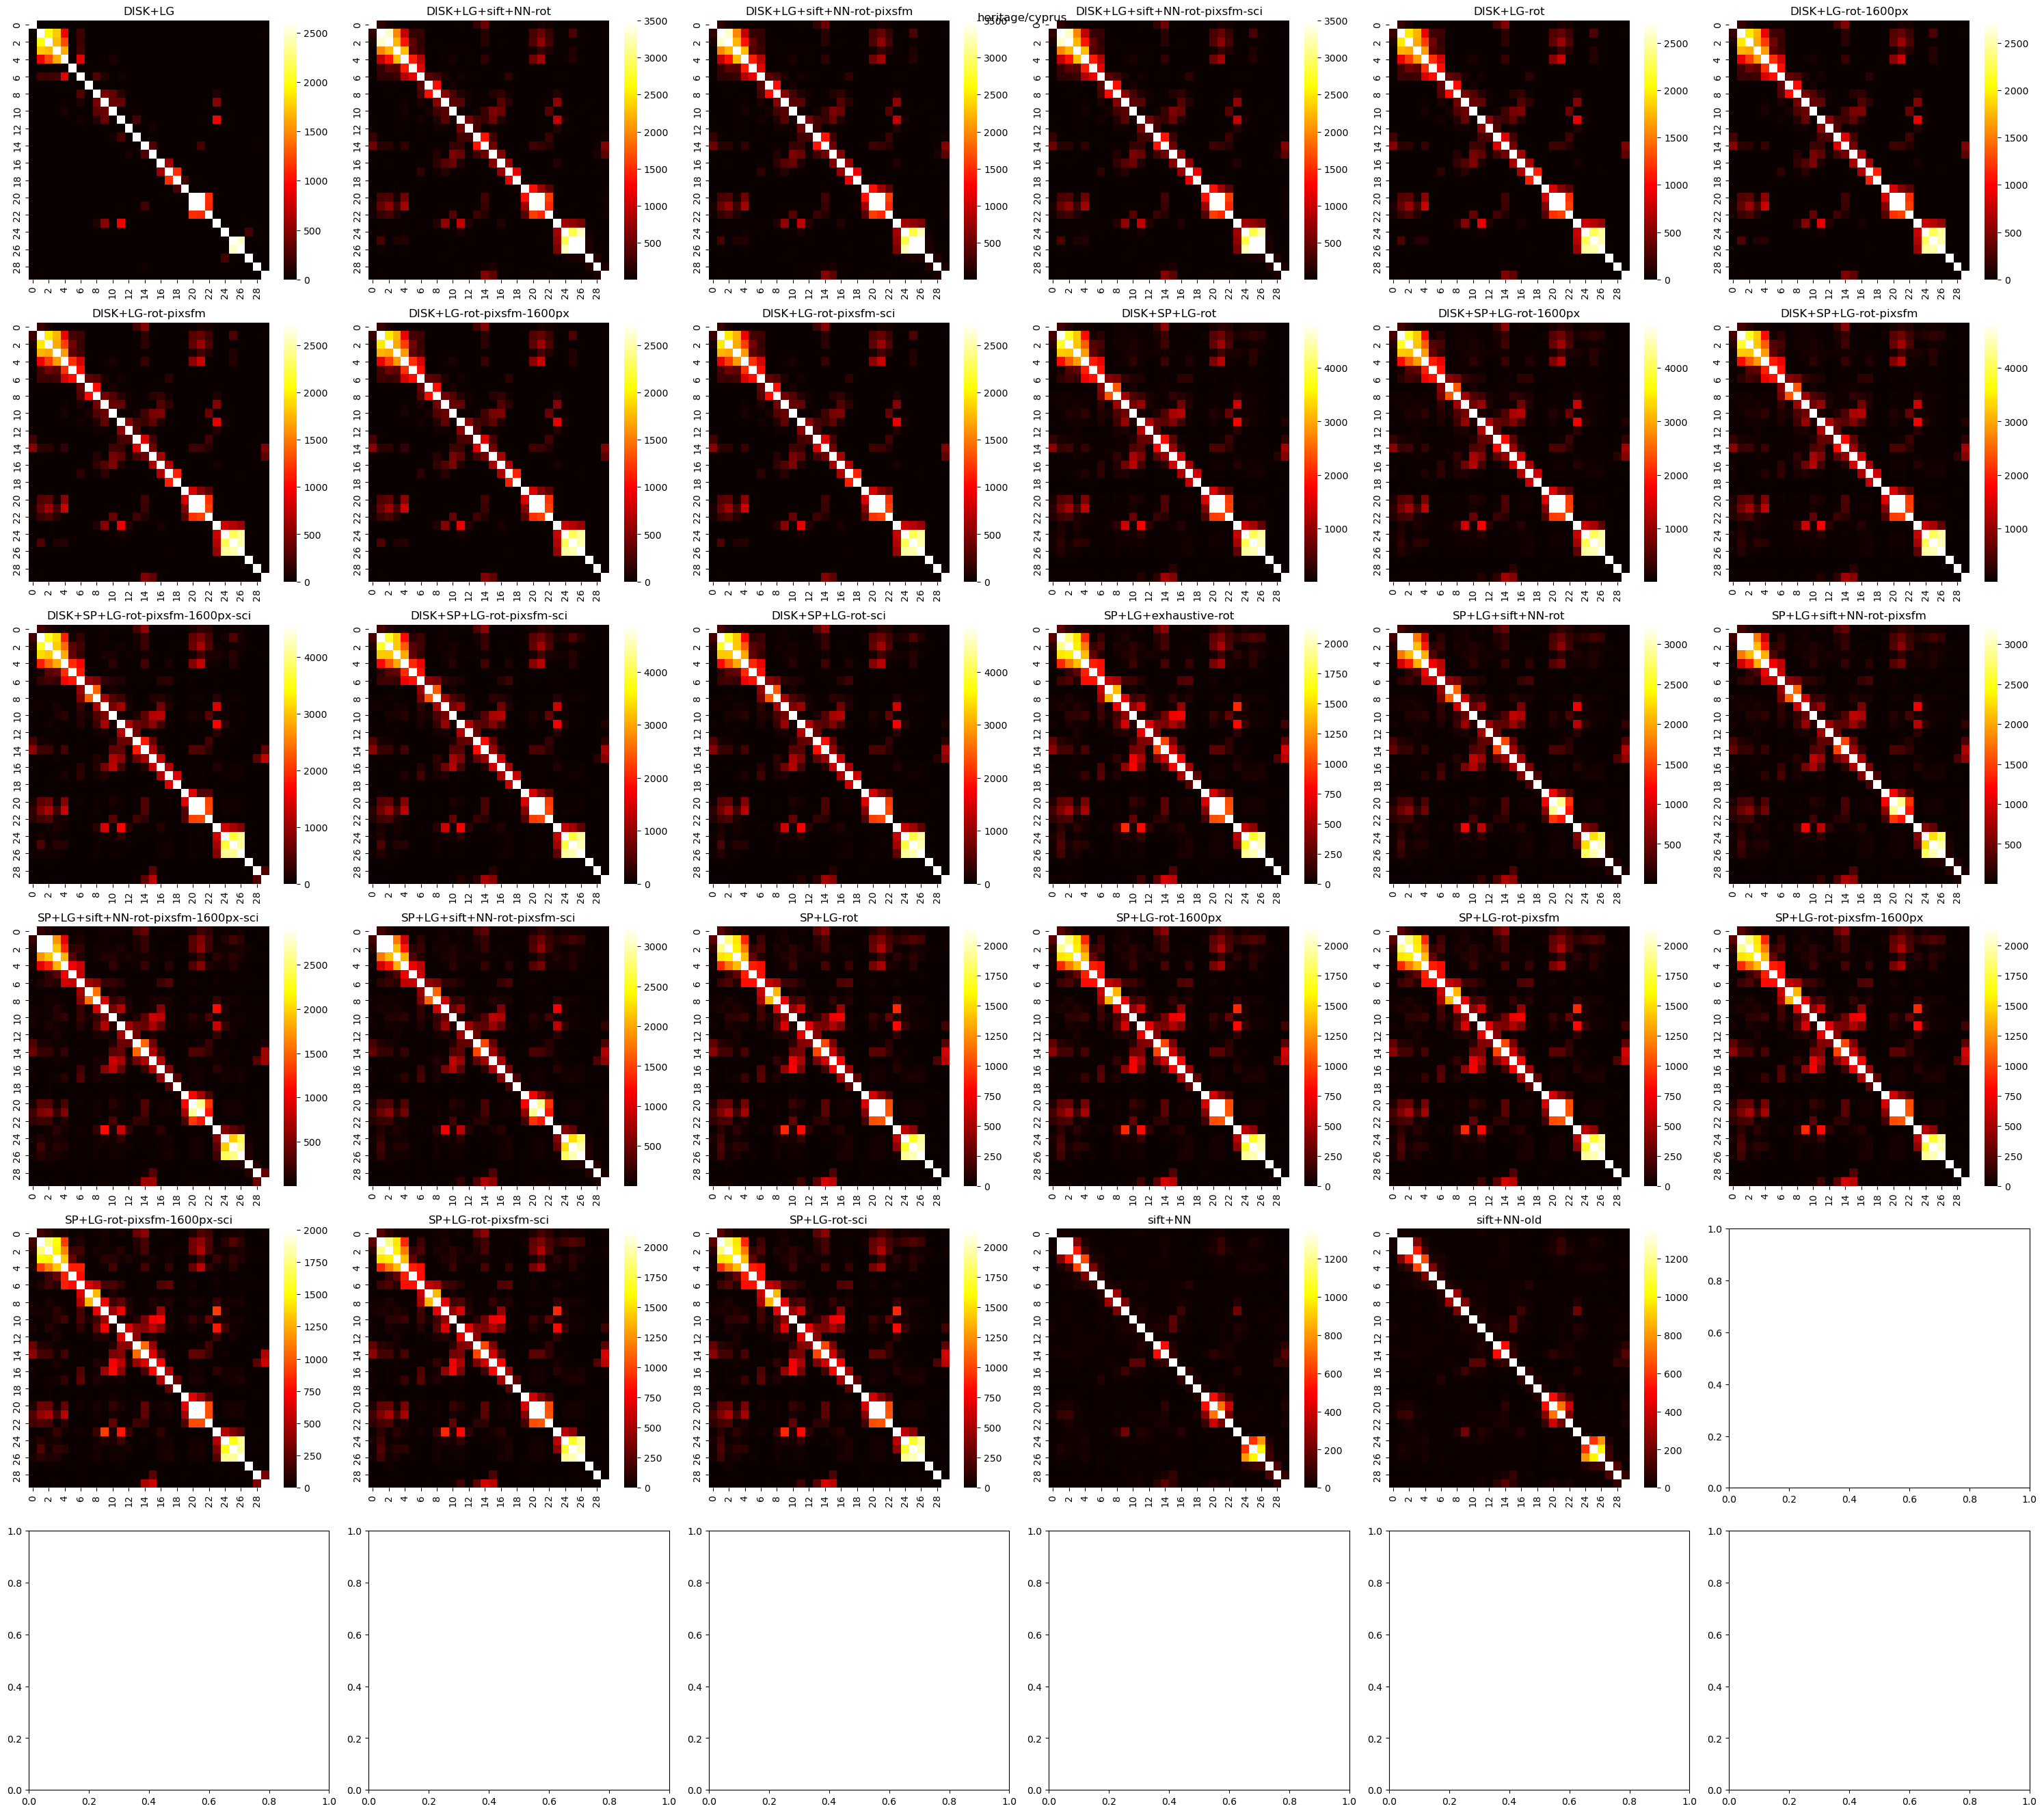

heritage/dioscuri: 100%|██████████| 29/29 [01:42<00:00,  3.55s/it]


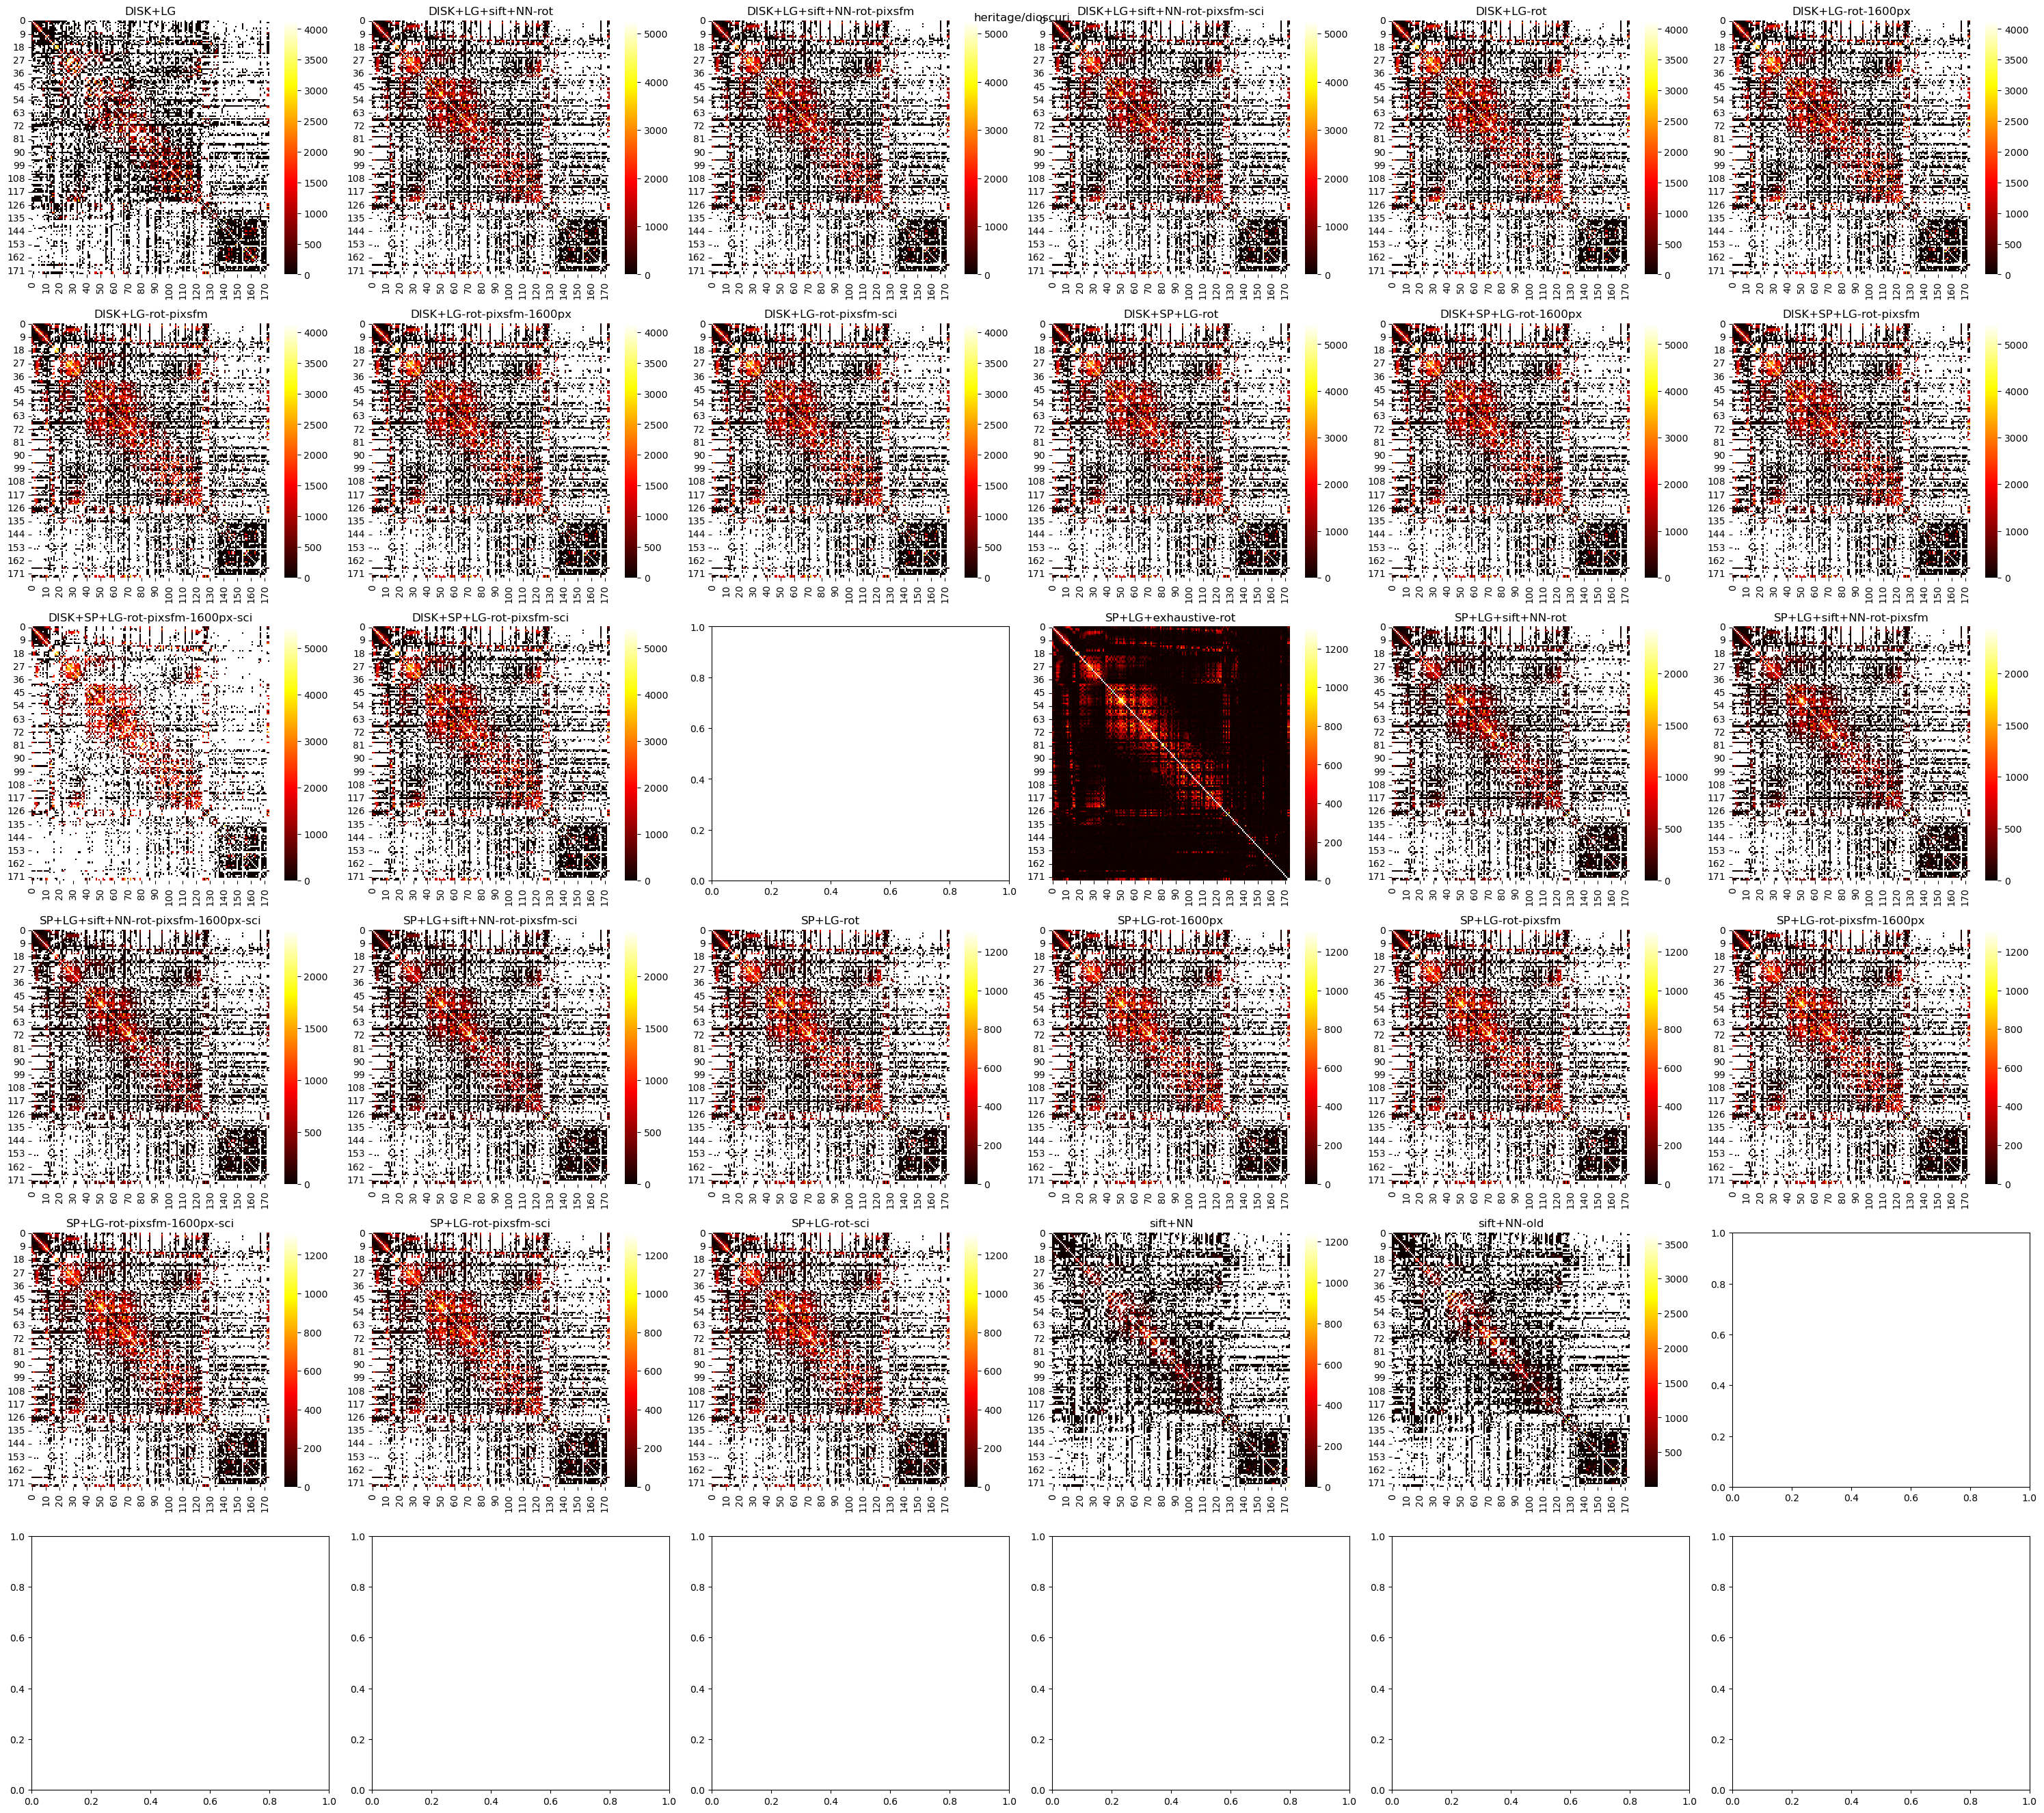

heritage/wall: 100%|██████████| 29/29 [01:21<00:00,  2.82s/it]


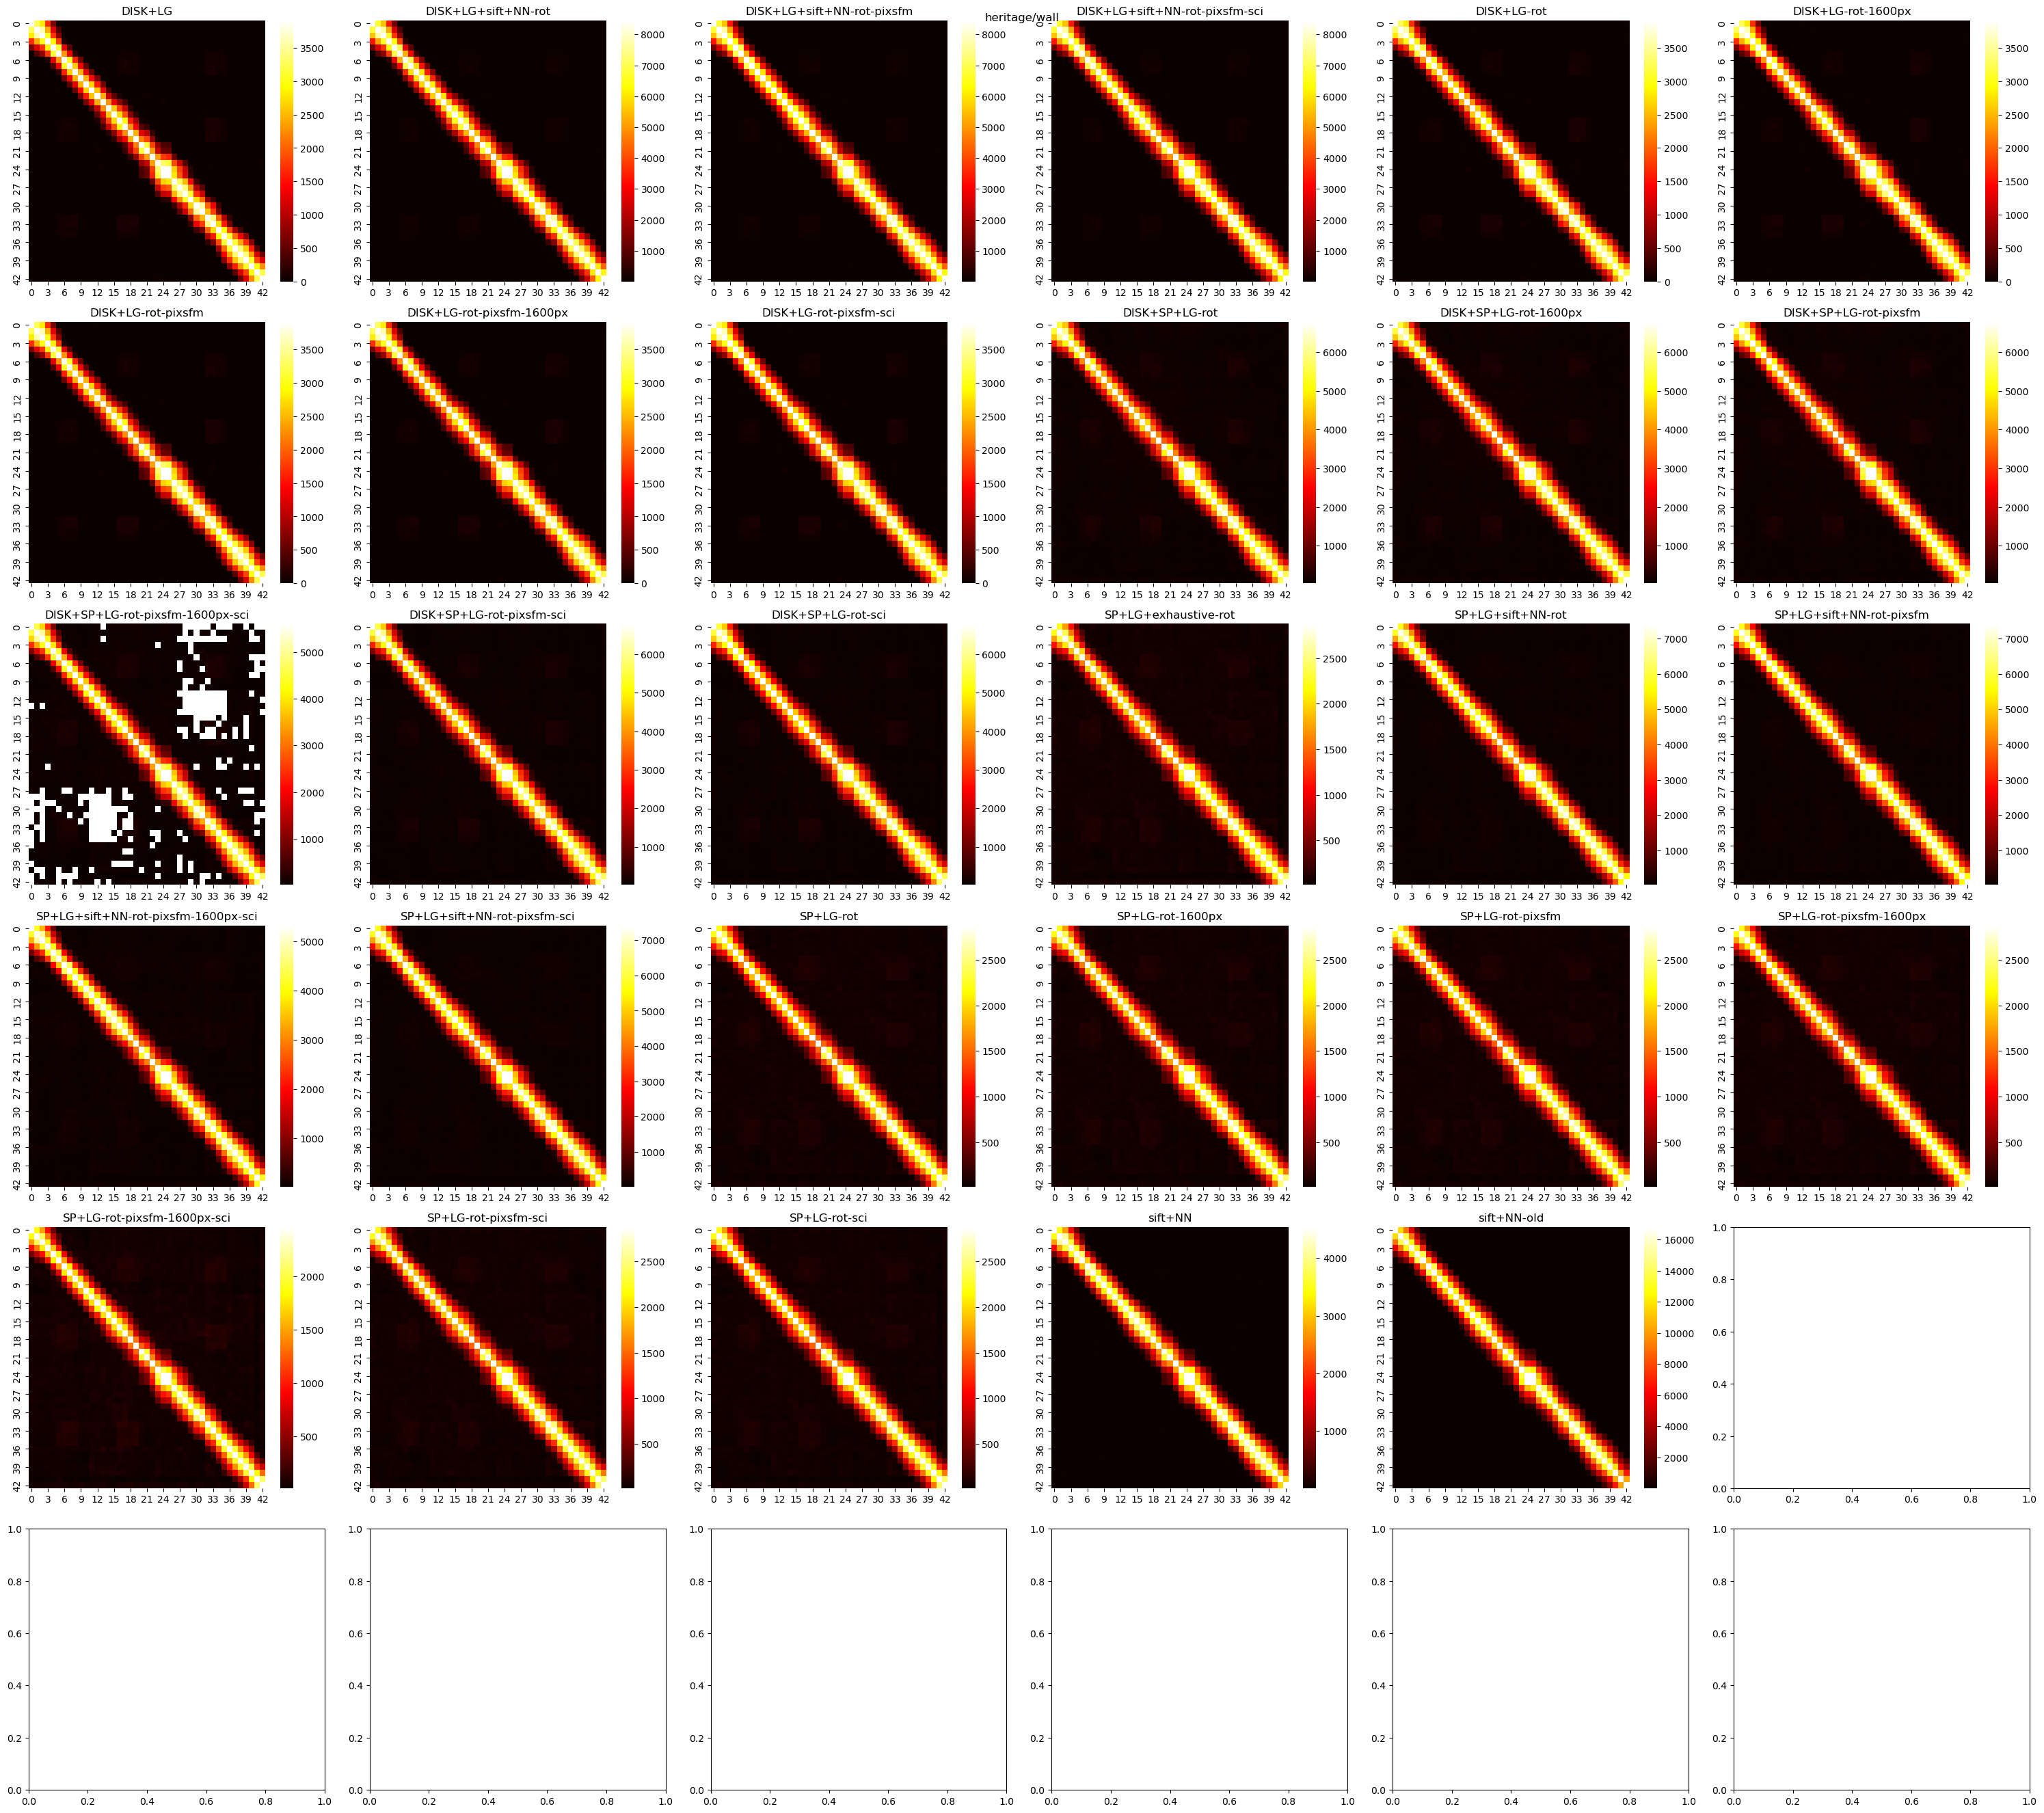

haiper/bike: 100%|██████████| 29/29 [35:04<00:00, 72.58s/it]   


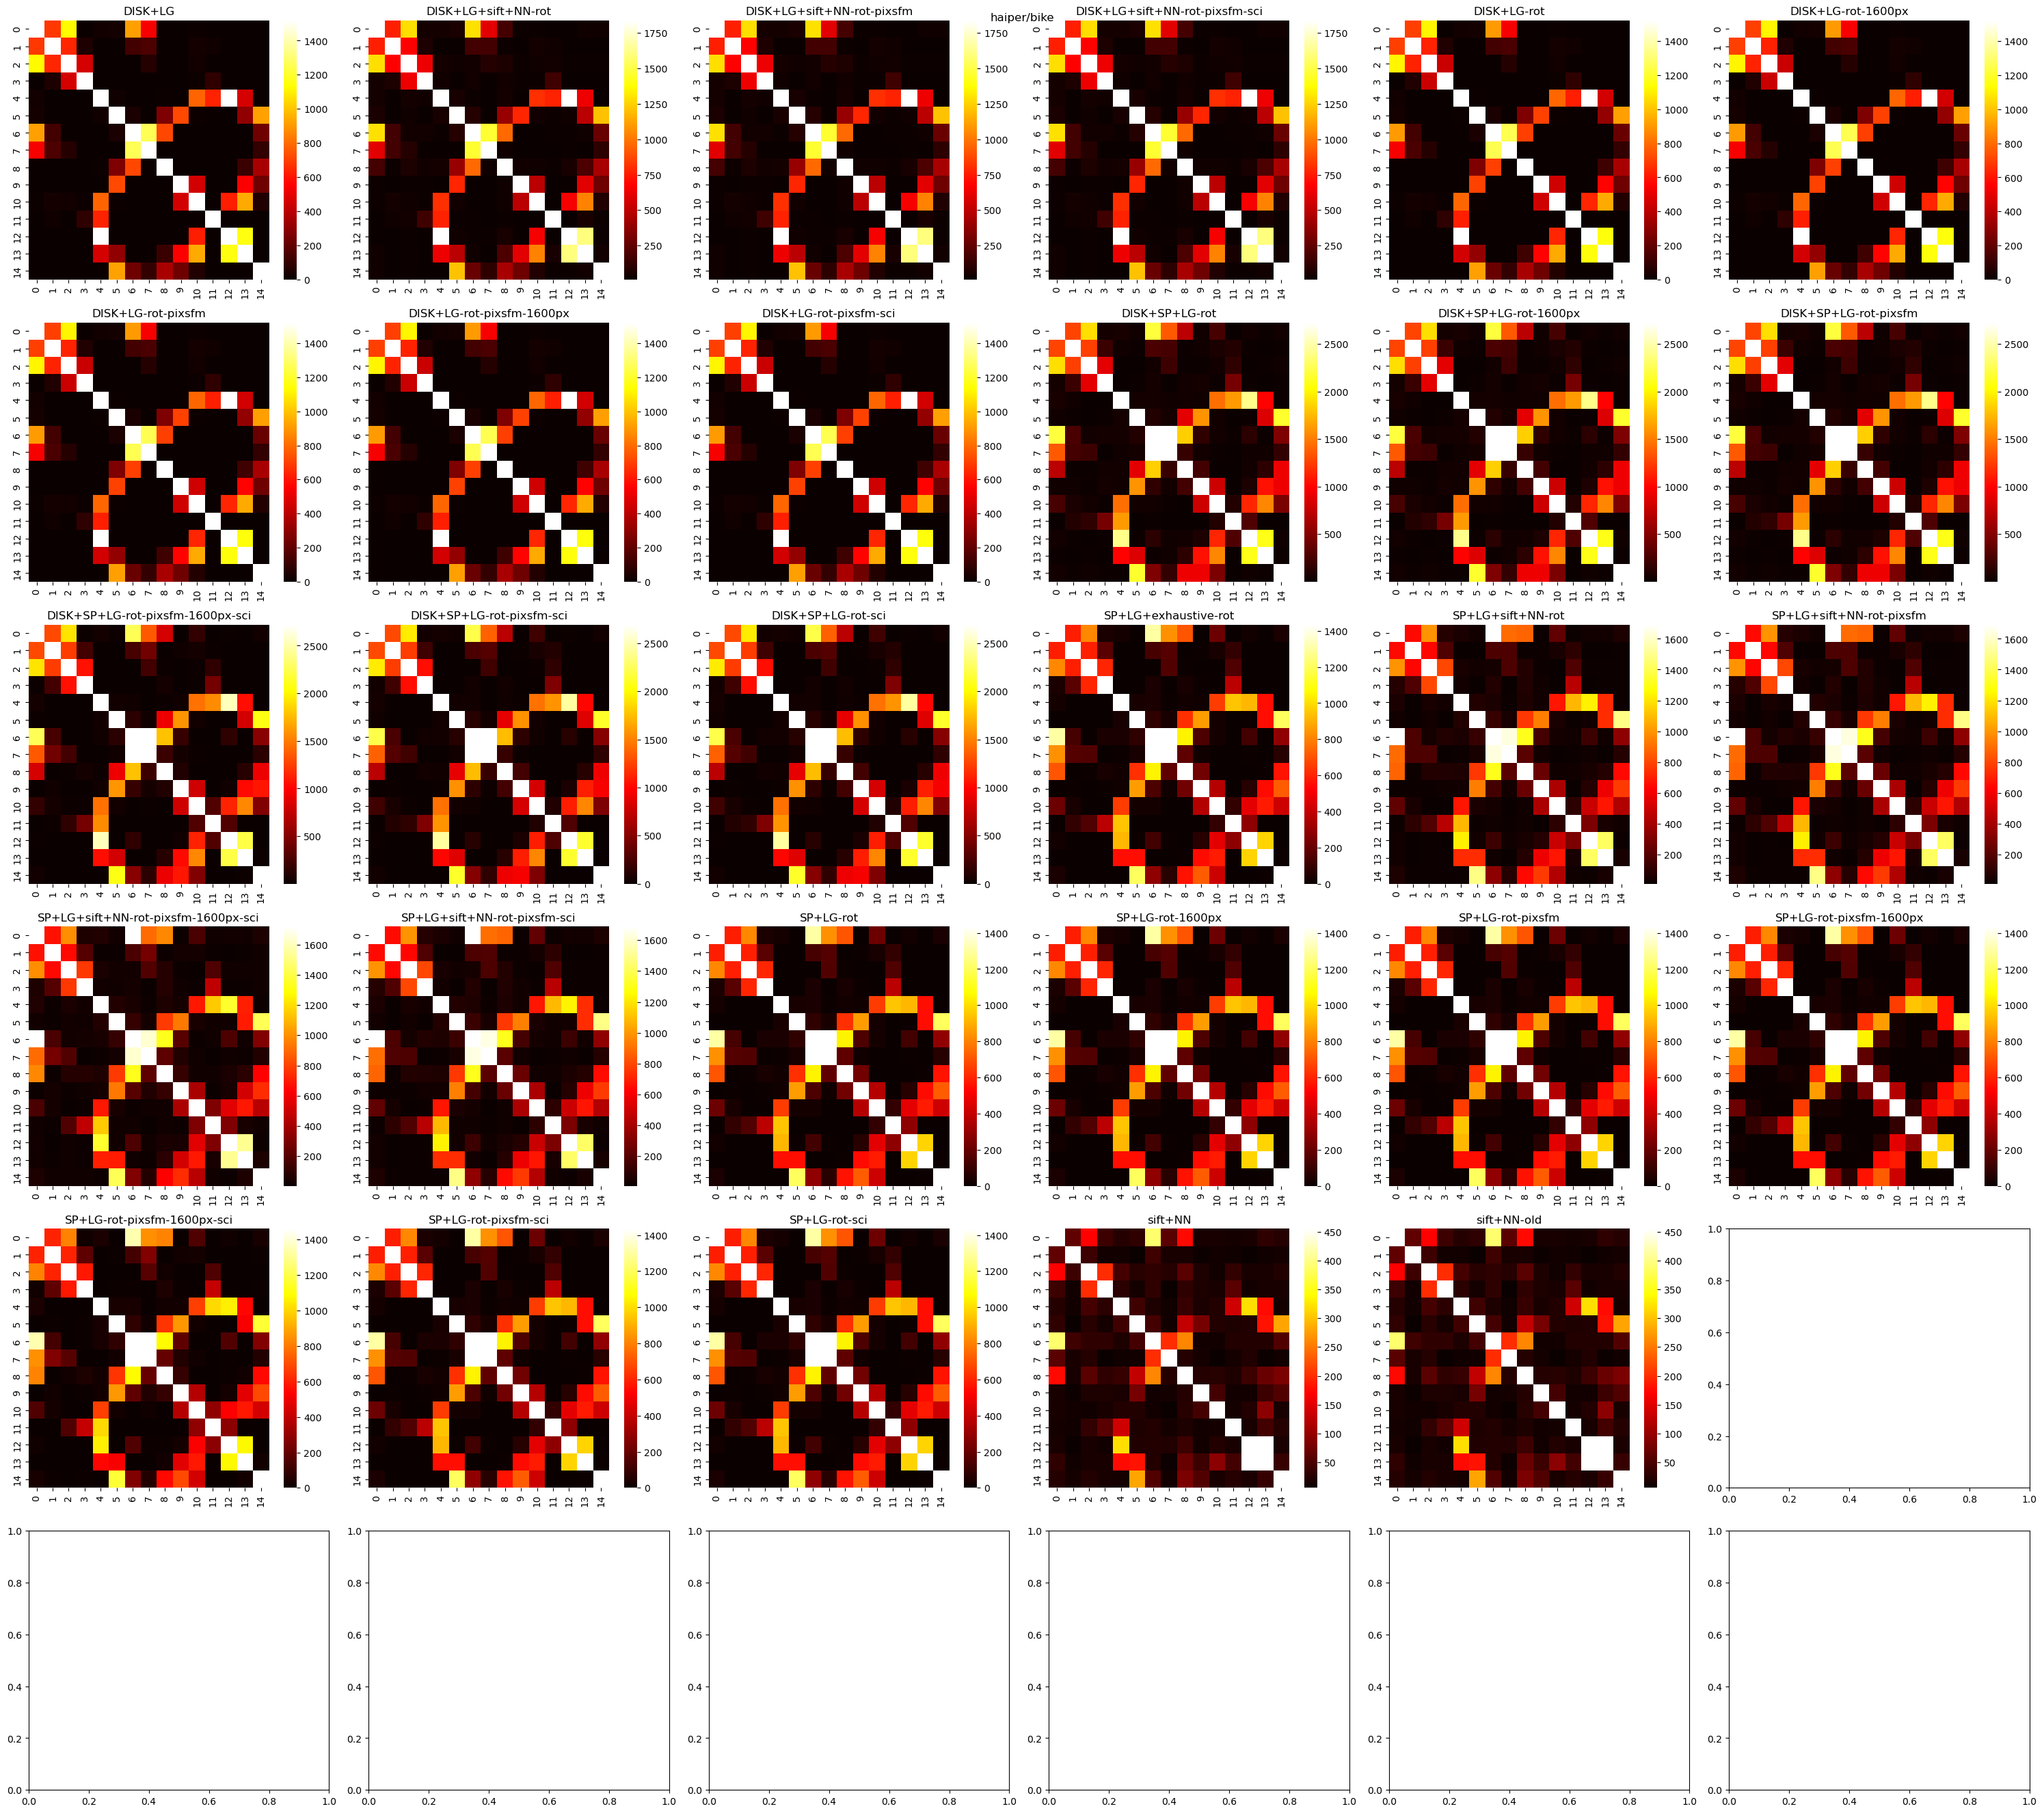

haiper/chairs: 100%|██████████| 29/29 [09:06<00:00, 18.84s/it] 


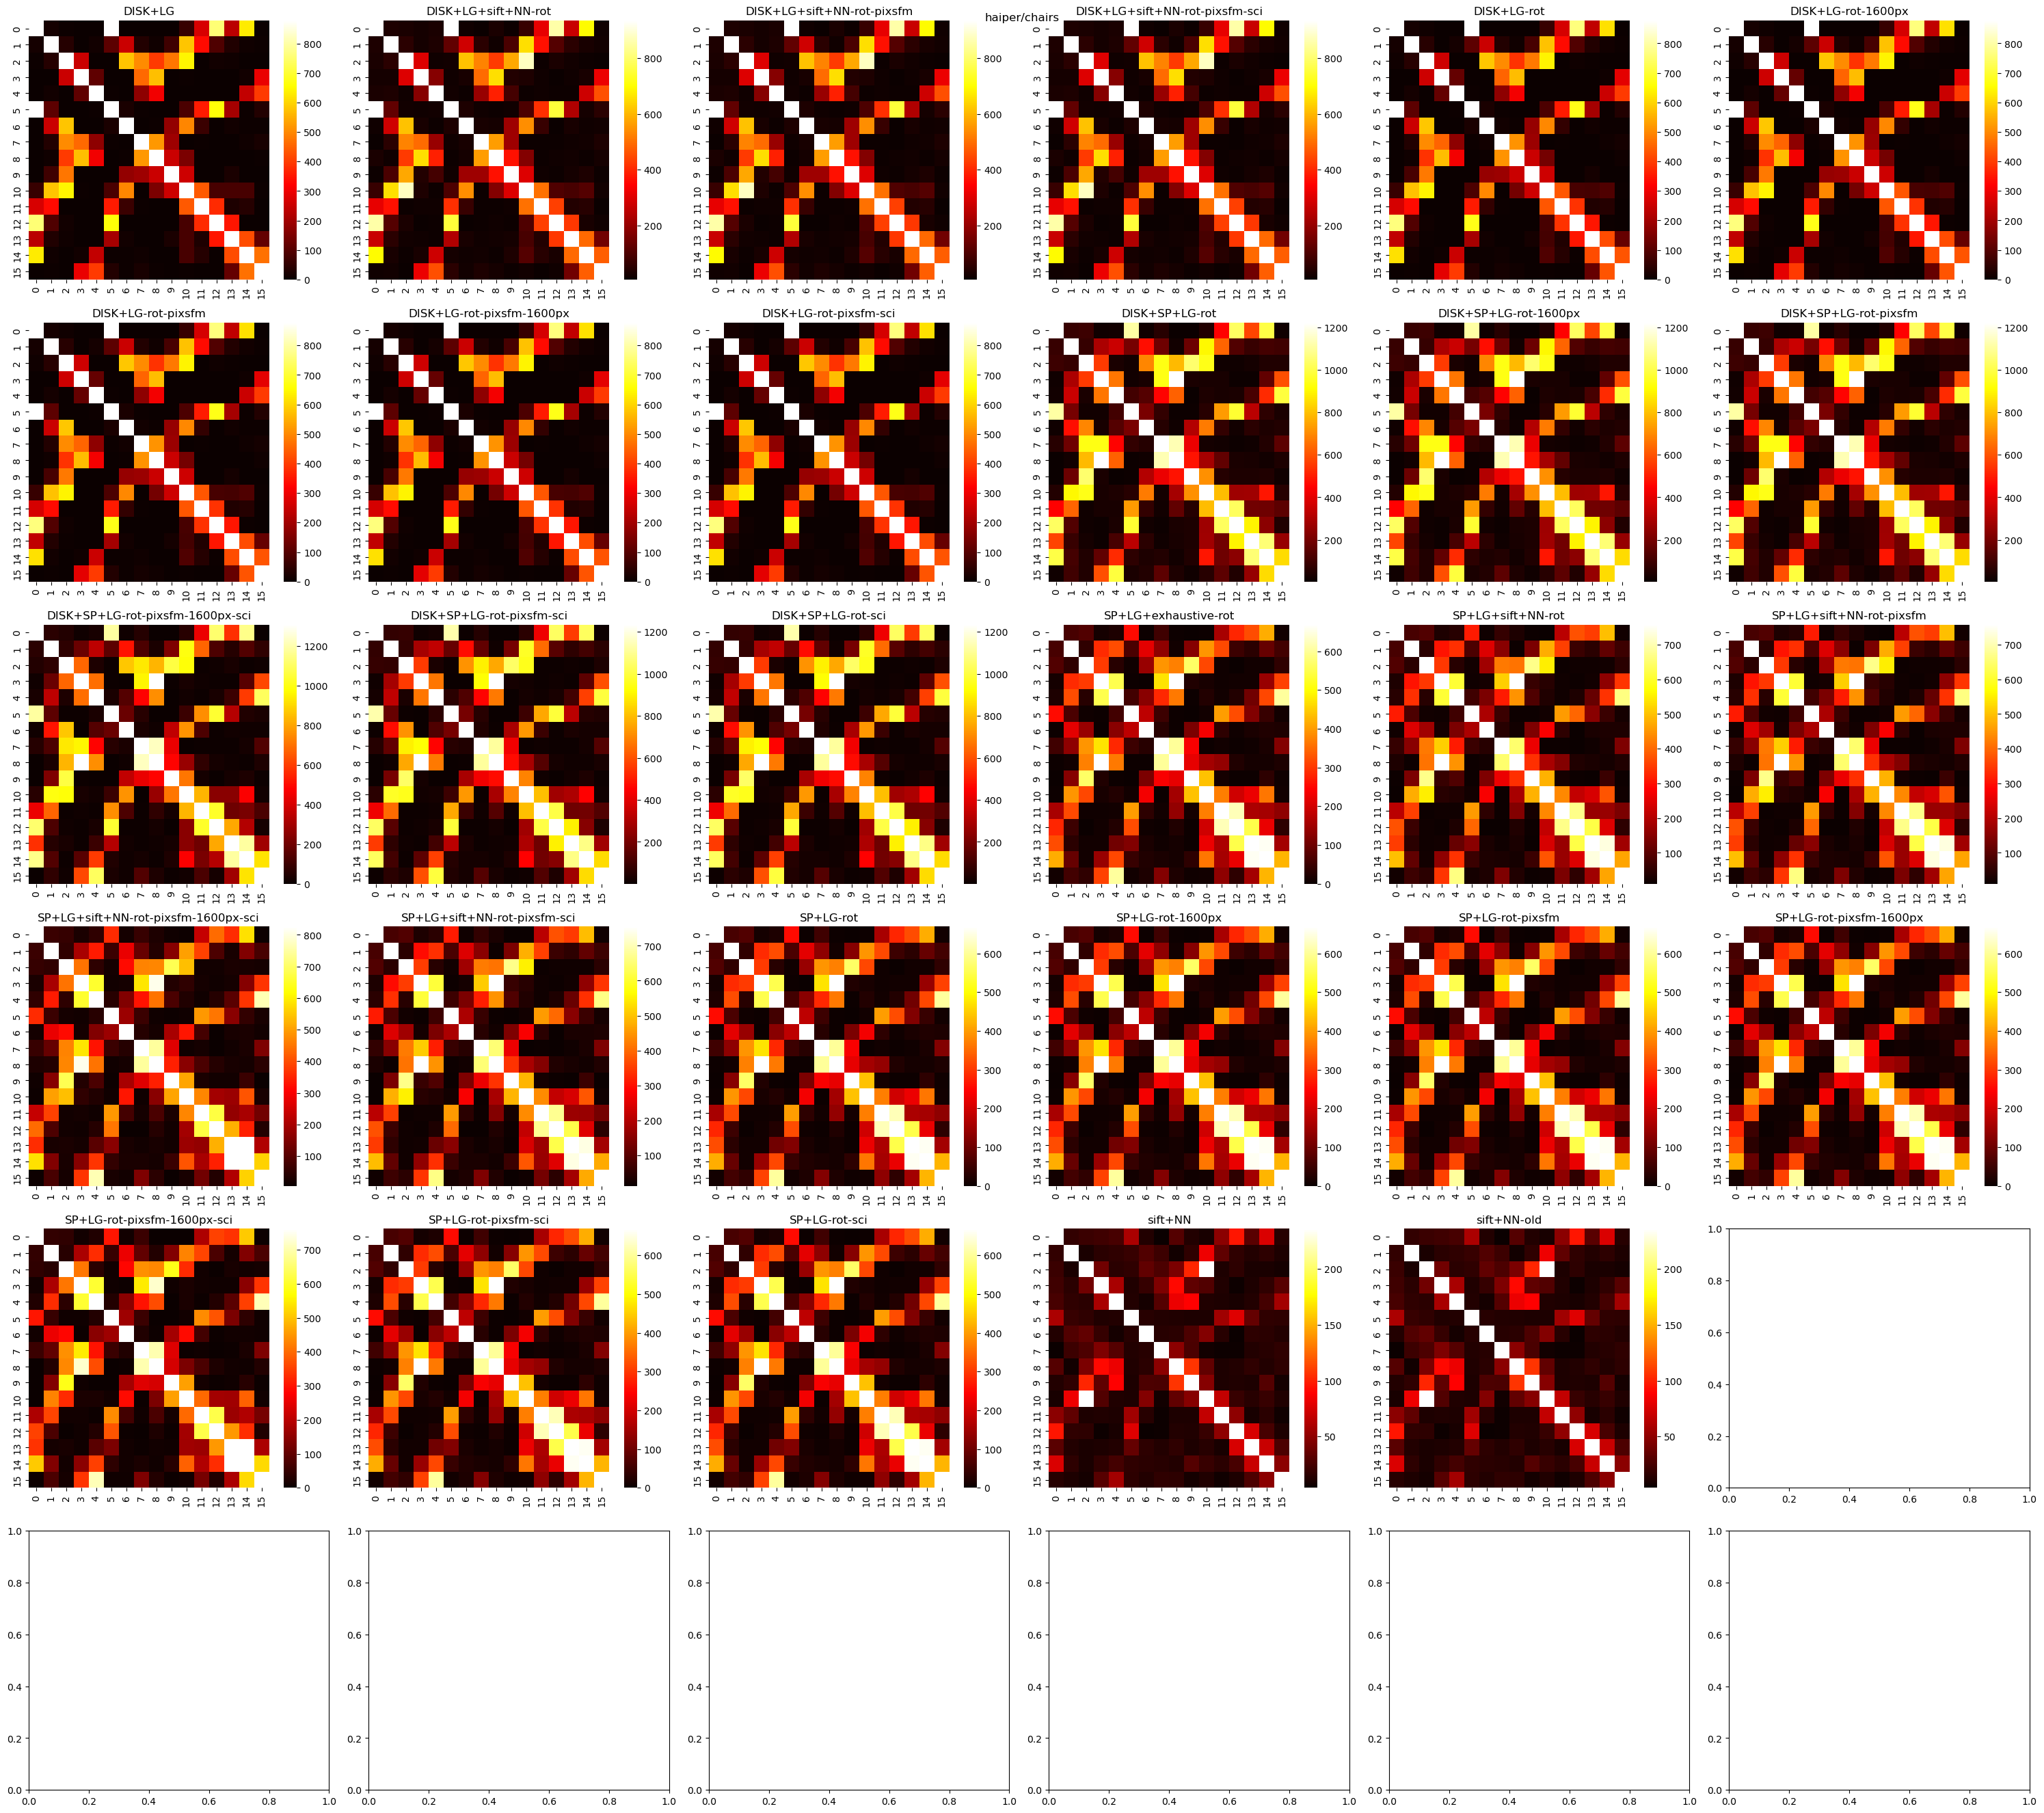

haiper/fountain: 100%|██████████| 29/29 [50:29<00:00, 104.45s/it] 


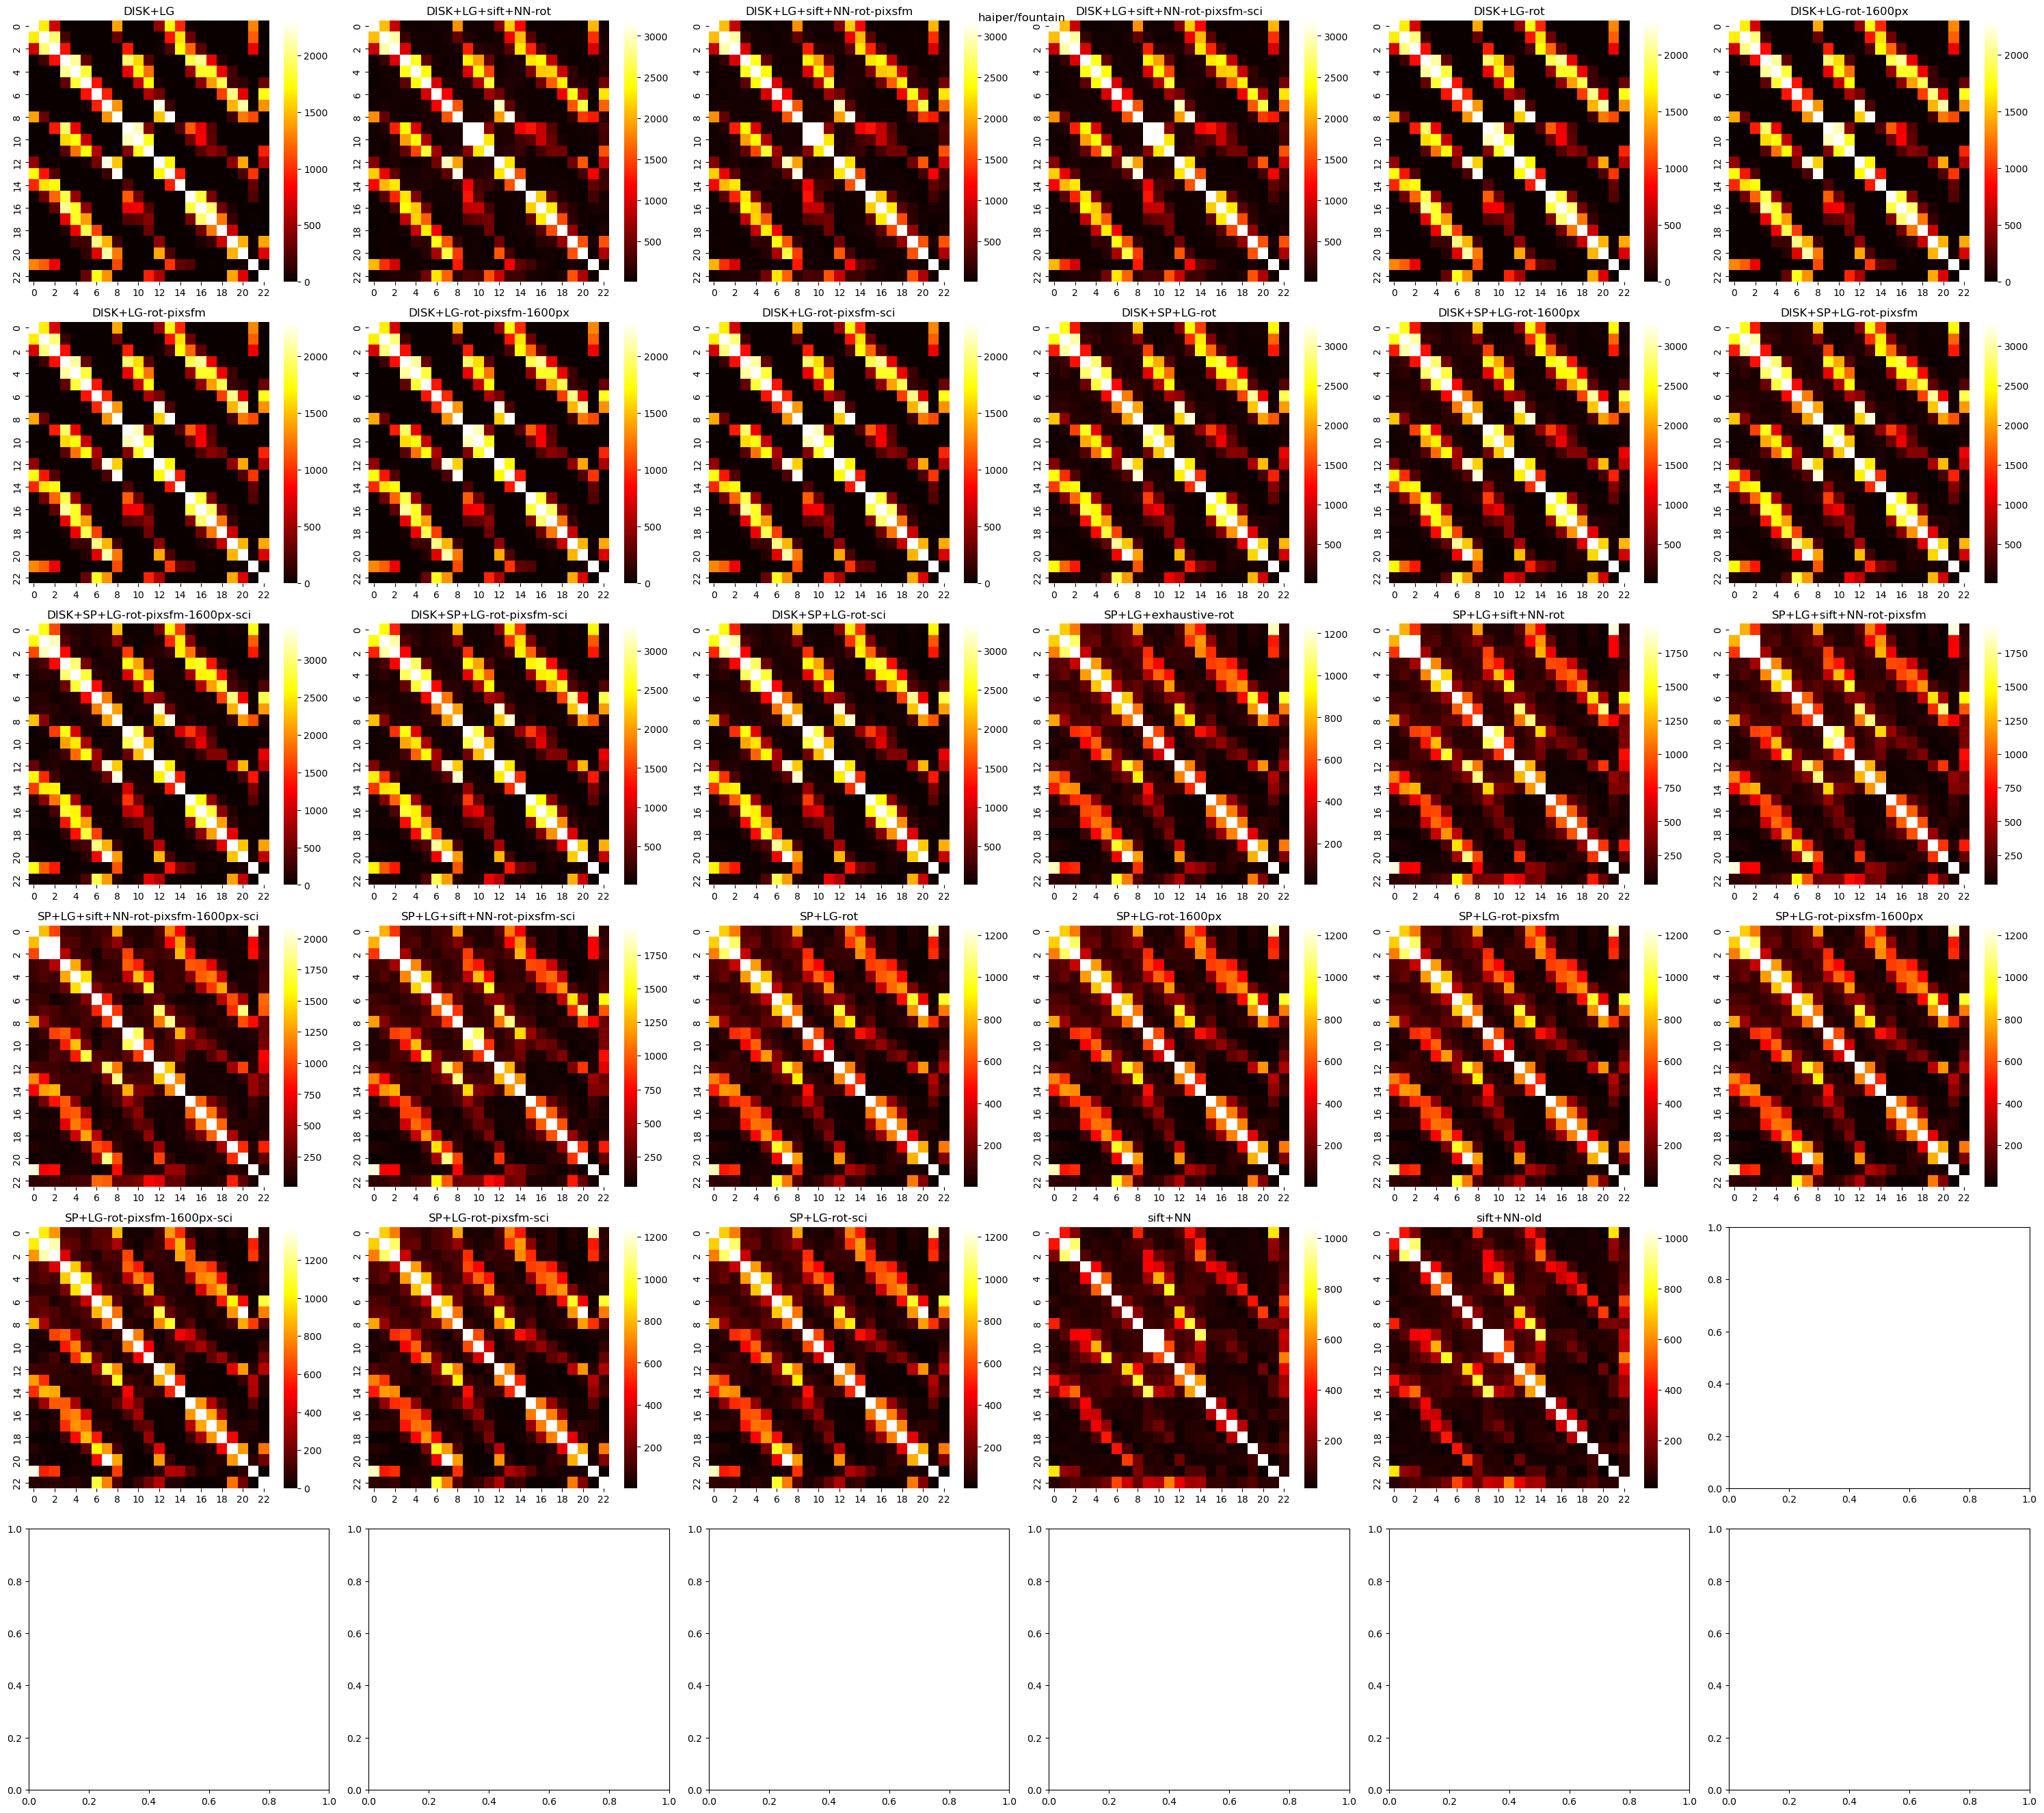

urban/kyiv-puppet-theater: 100%|██████████| 29/29 [30:12<00:00, 62.52s/it]  


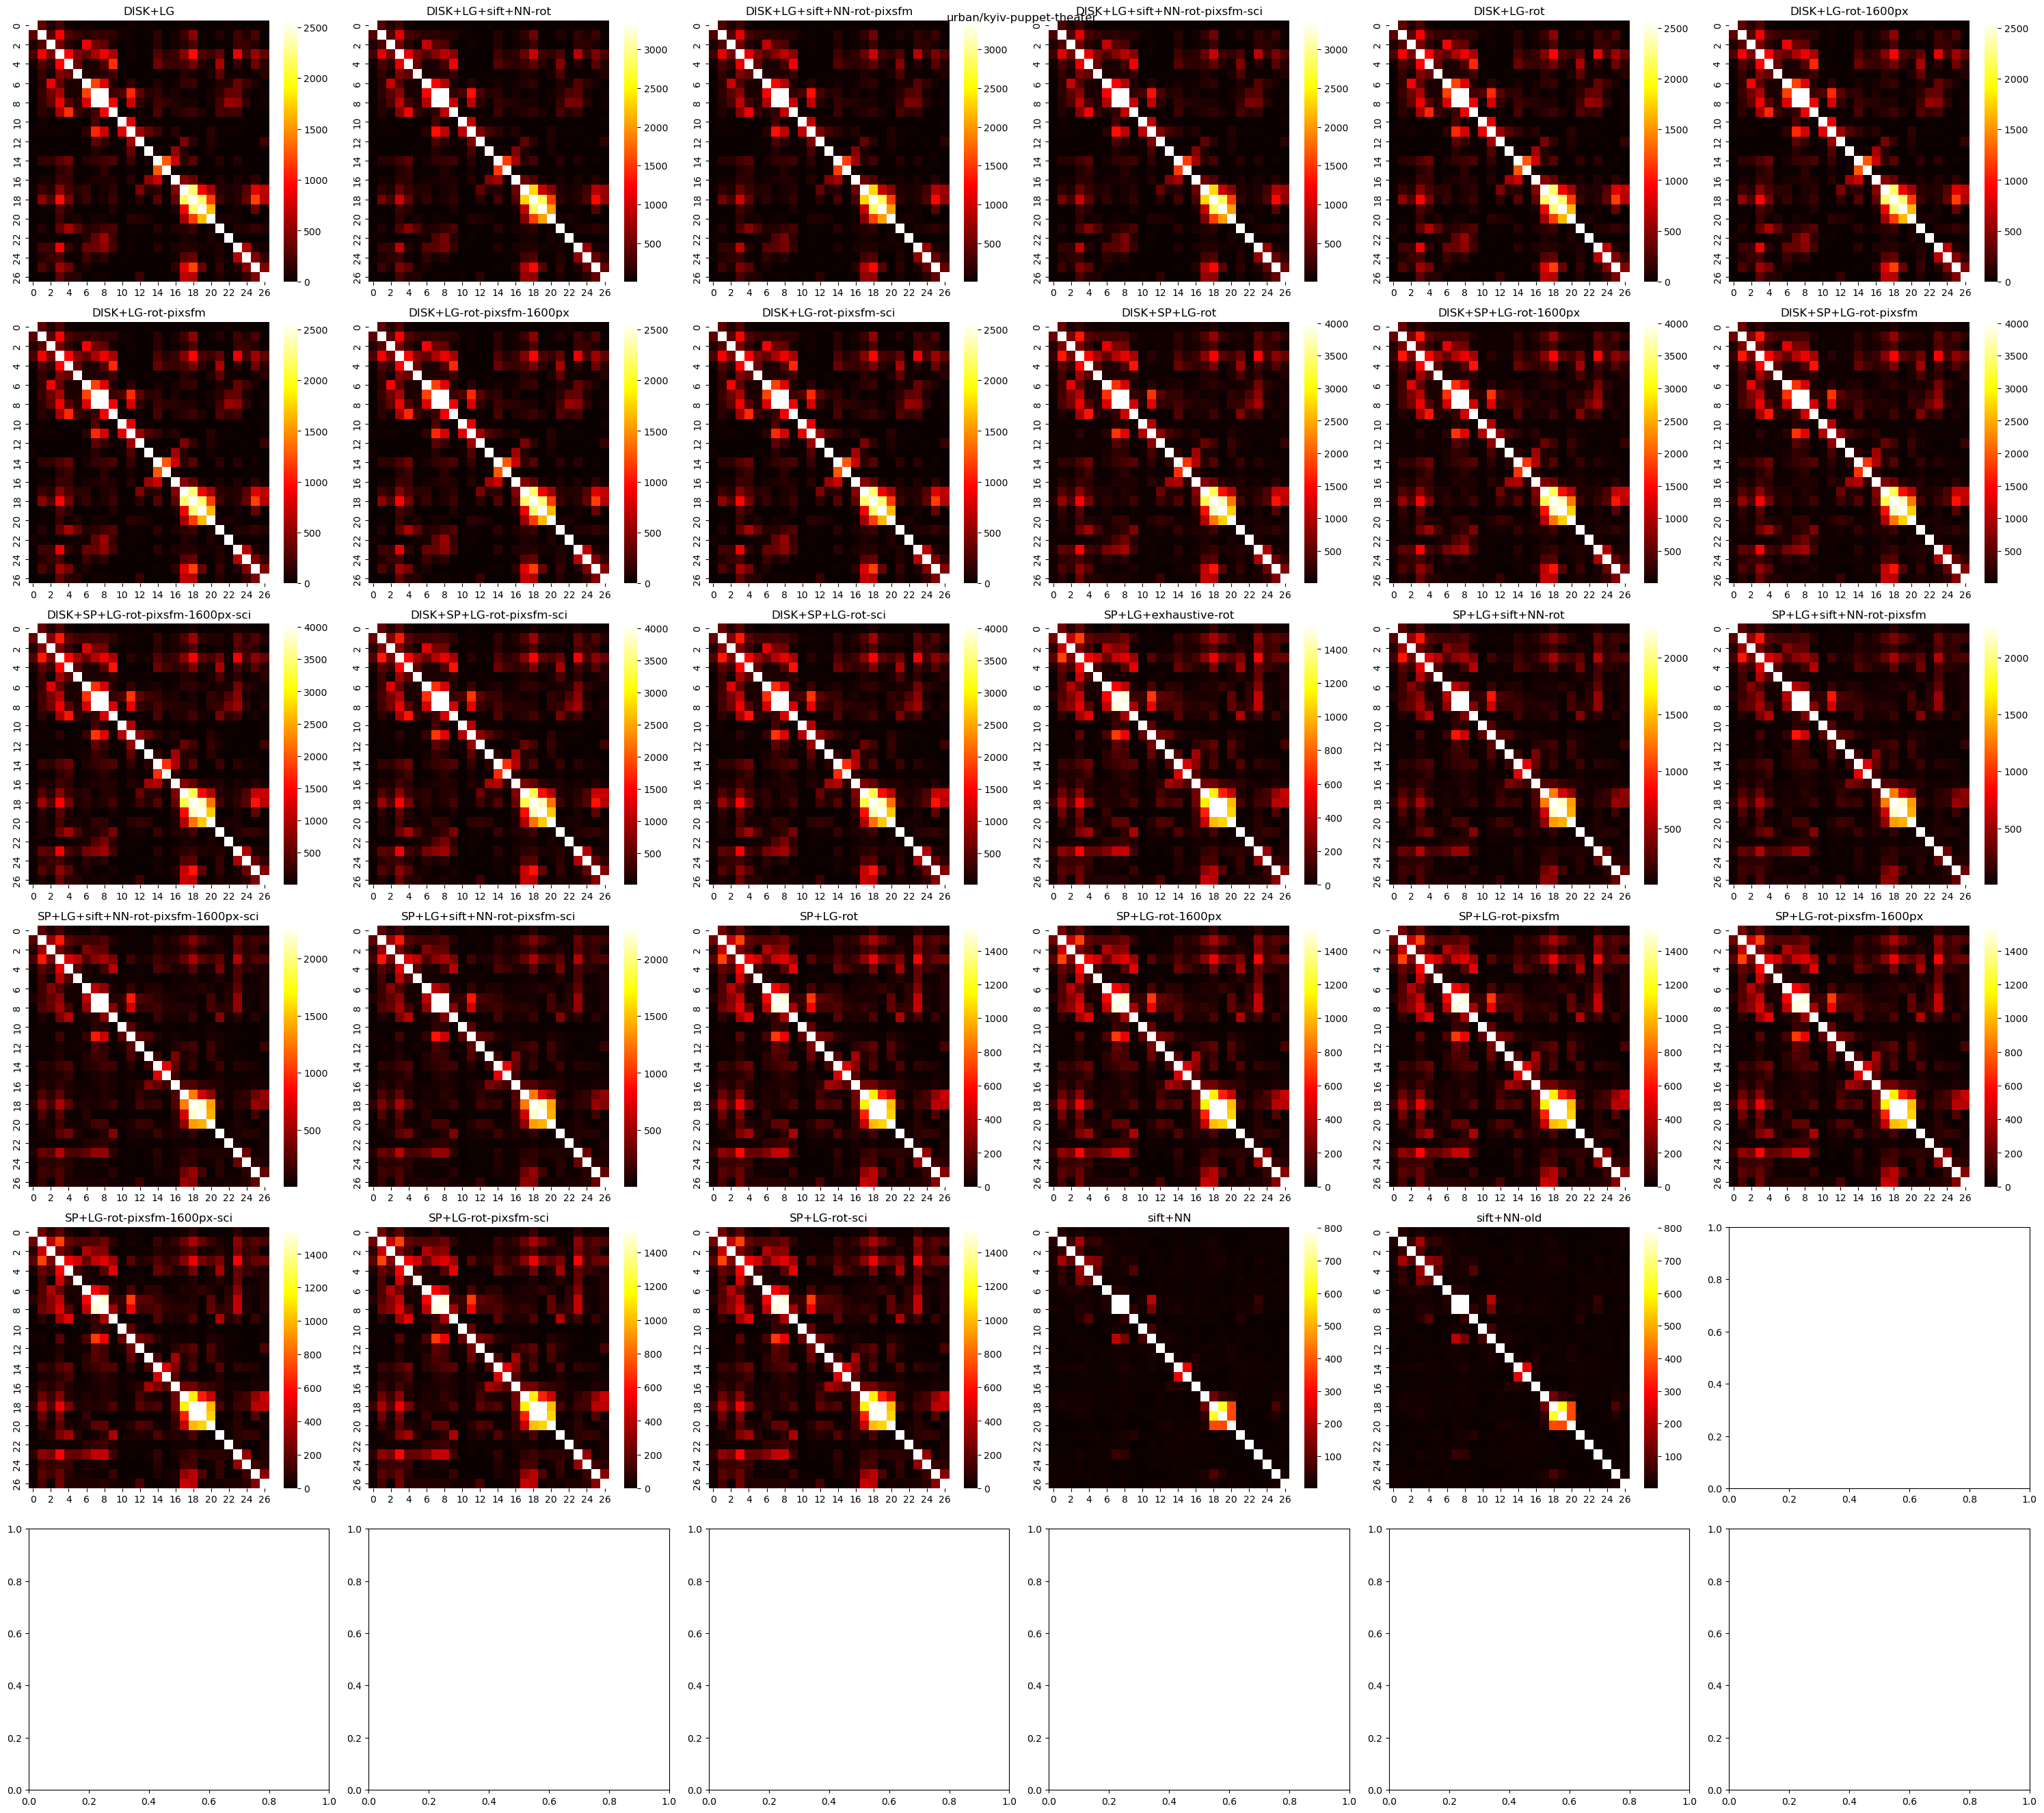

In [53]:

for ds in datasets.keys():
    for j, scene in enumerate(datasets[ds]):
        image_names = metrics[ds][scene]["images"]

        pbar = tqdm(runs, desc=f"{ds}/{scene}")

        rows = np.sqrt(len(runs))
        cols = np.ceil(len(runs) / rows)
        fig, ax = plt.subplots(int(rows+1), int(cols), figsize=(5 * cols, 5 * rows))

        for r_idx, r in enumerate(pbar):

            scene_dir = Path(f"{out_dir}/{r}/{ds}/{scene}")

            matches = scene_dir / "matches.h5"

            if not matches.exists():
                continue

            pairs = sorted(list_h5_names(matches))

            match_matrix = -np.ones([len(image_names), len(image_names)])
            for pair in pairs:
                name0, name1 = pair.split("/")
                idx0, idx1 = image_names.index(name0), image_names.index(name1)
                m, sc = get_matches(matches, name0, name1)
                match_matrix[idx0, idx1] = match_matrix[idx1, idx0] = m.shape[0]

            sns.heatmap(
                match_matrix,
                ax=ax[int(r_idx // cols), int(r_idx % cols)],
                cbar=True,
                cmap="hot",
                mask=match_matrix < 0,
            )

            ax[int(r_idx // cols), int(r_idx % cols)].set_title(r)

        plt.suptitle(f"{ds}/{scene}")
        plt.tight_layout()
        plt.show()


heritage/cyprus: 100%|██████████| 29/29 [17:14<00:00, 35.69s/it] 


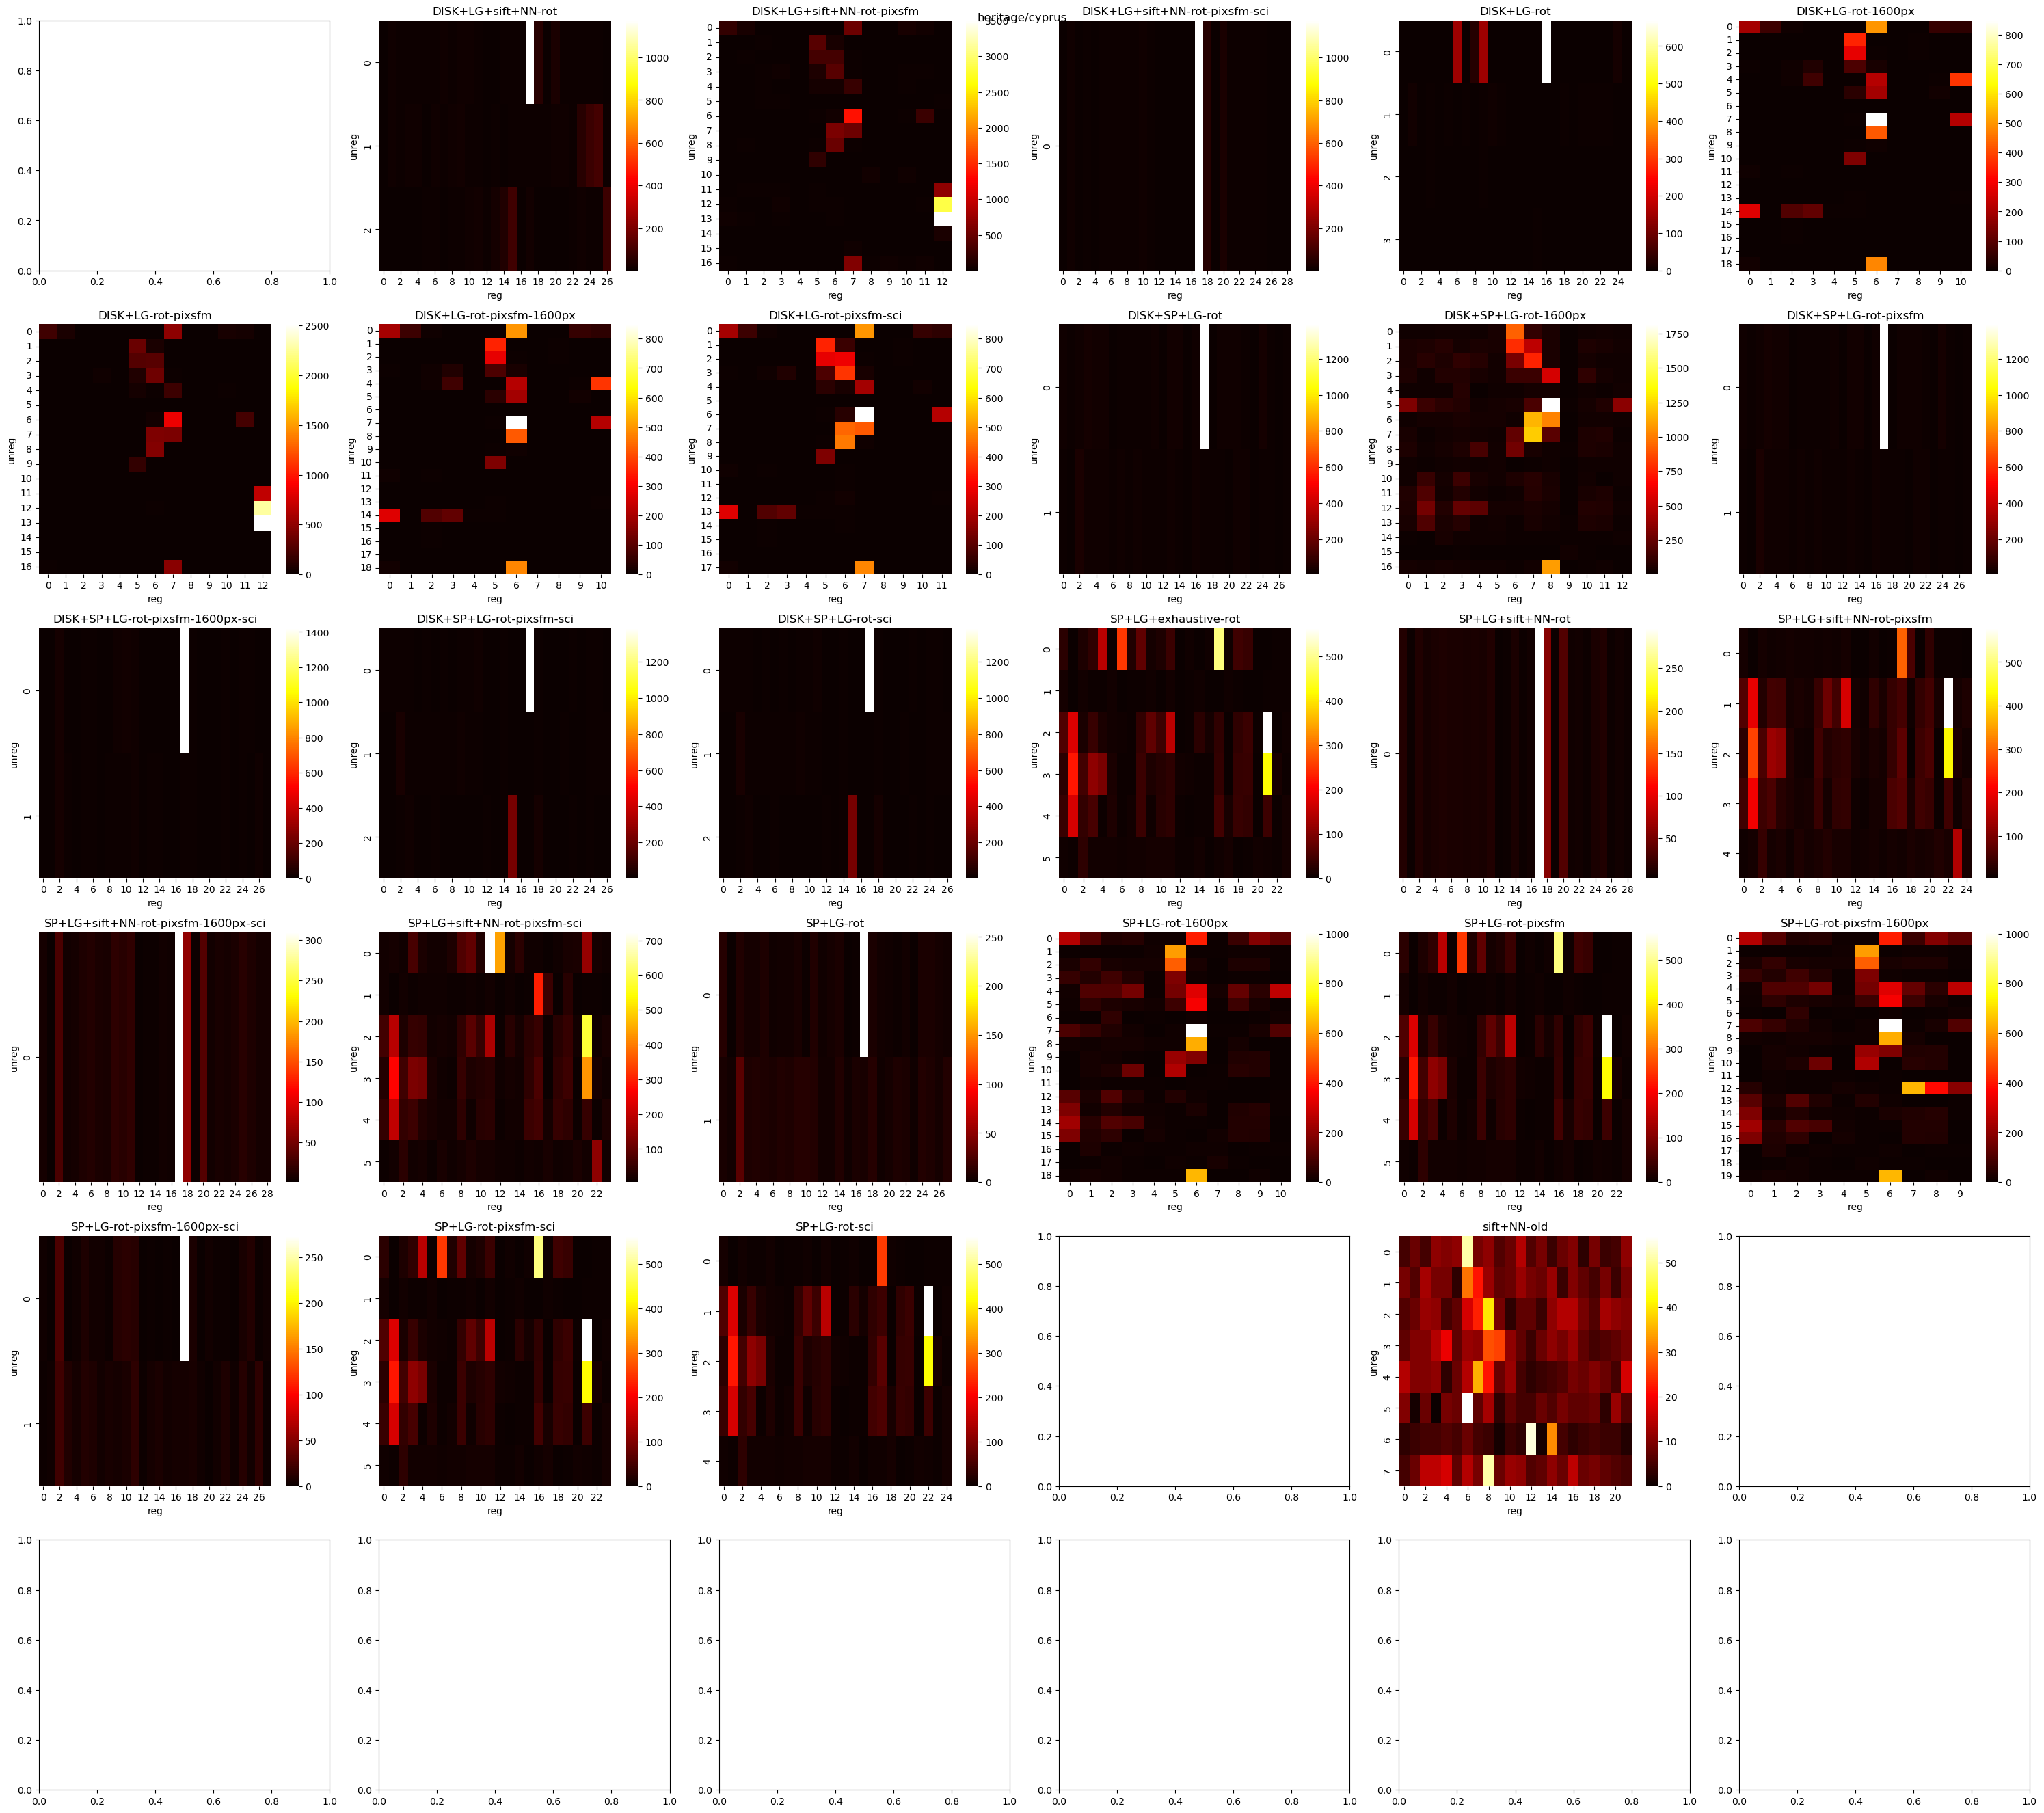

heritage/dioscuri: 100%|██████████| 29/29 [1:40:36<00:00, 208.15s/it]


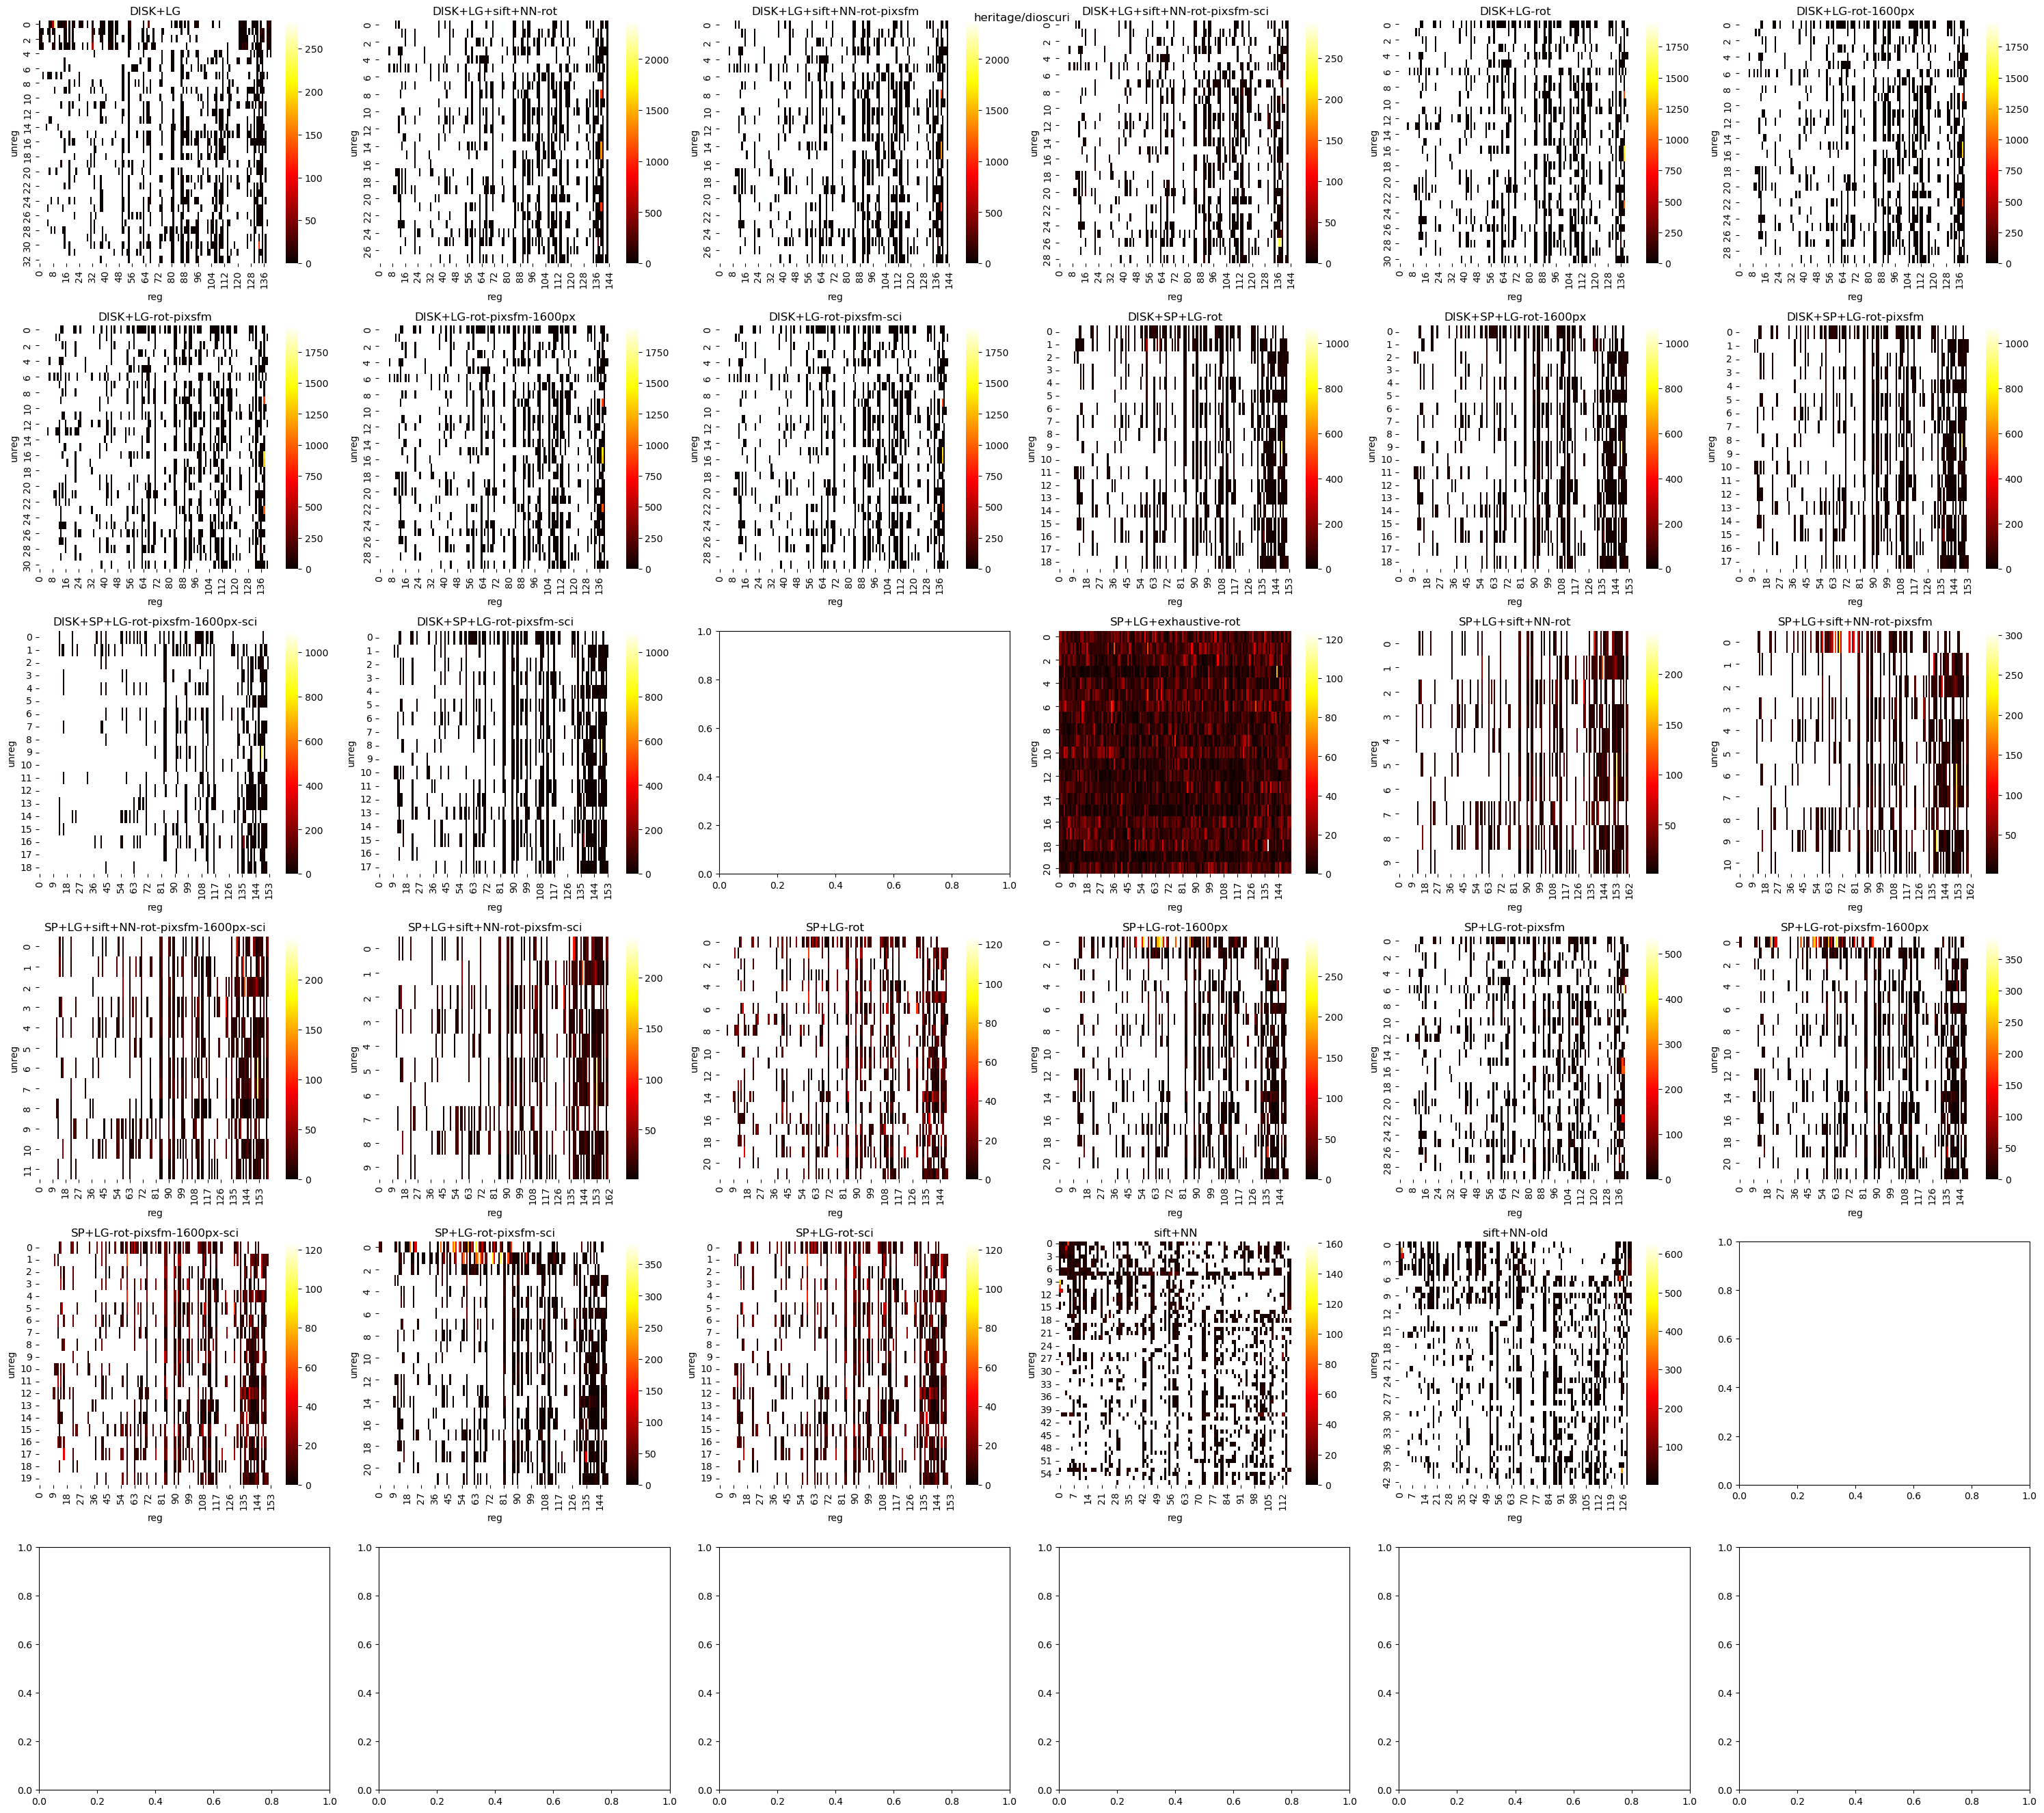

heritage/wall: 100%|██████████| 29/29 [18:02<00:00, 37.33s/it]  


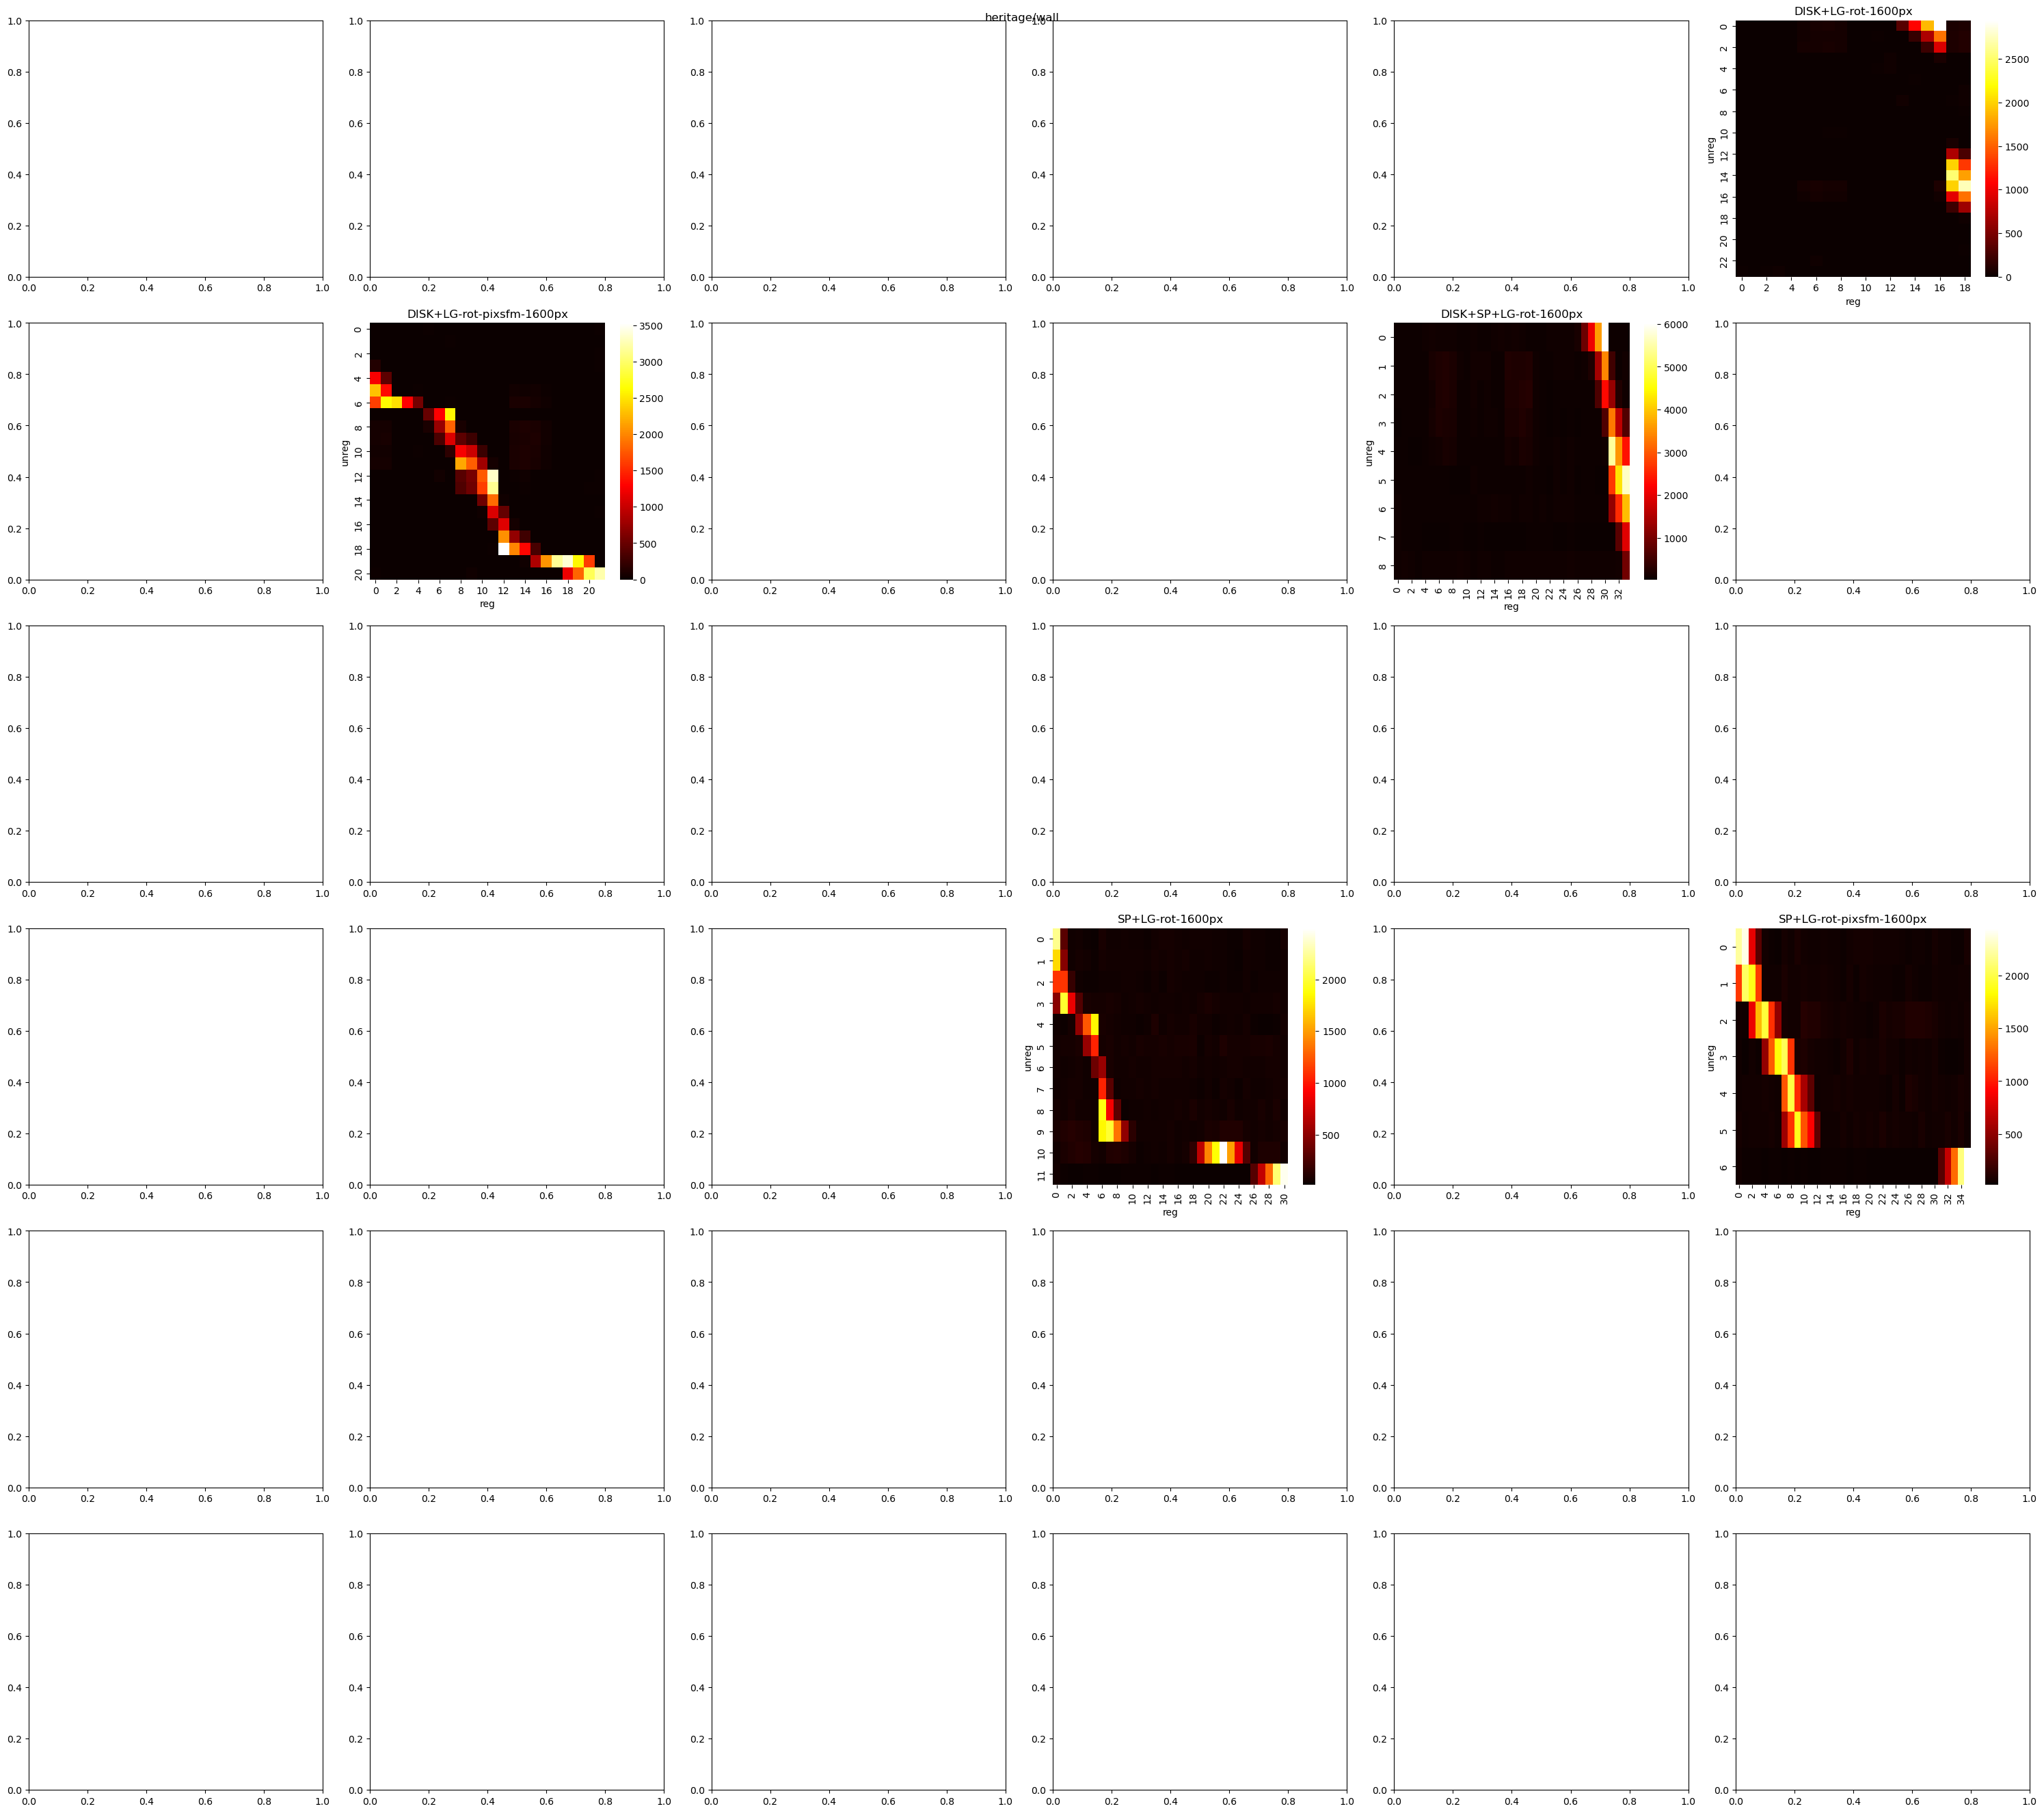

haiper/bike: 100%|██████████| 29/29 [17:51<00:00, 36.94s/it]


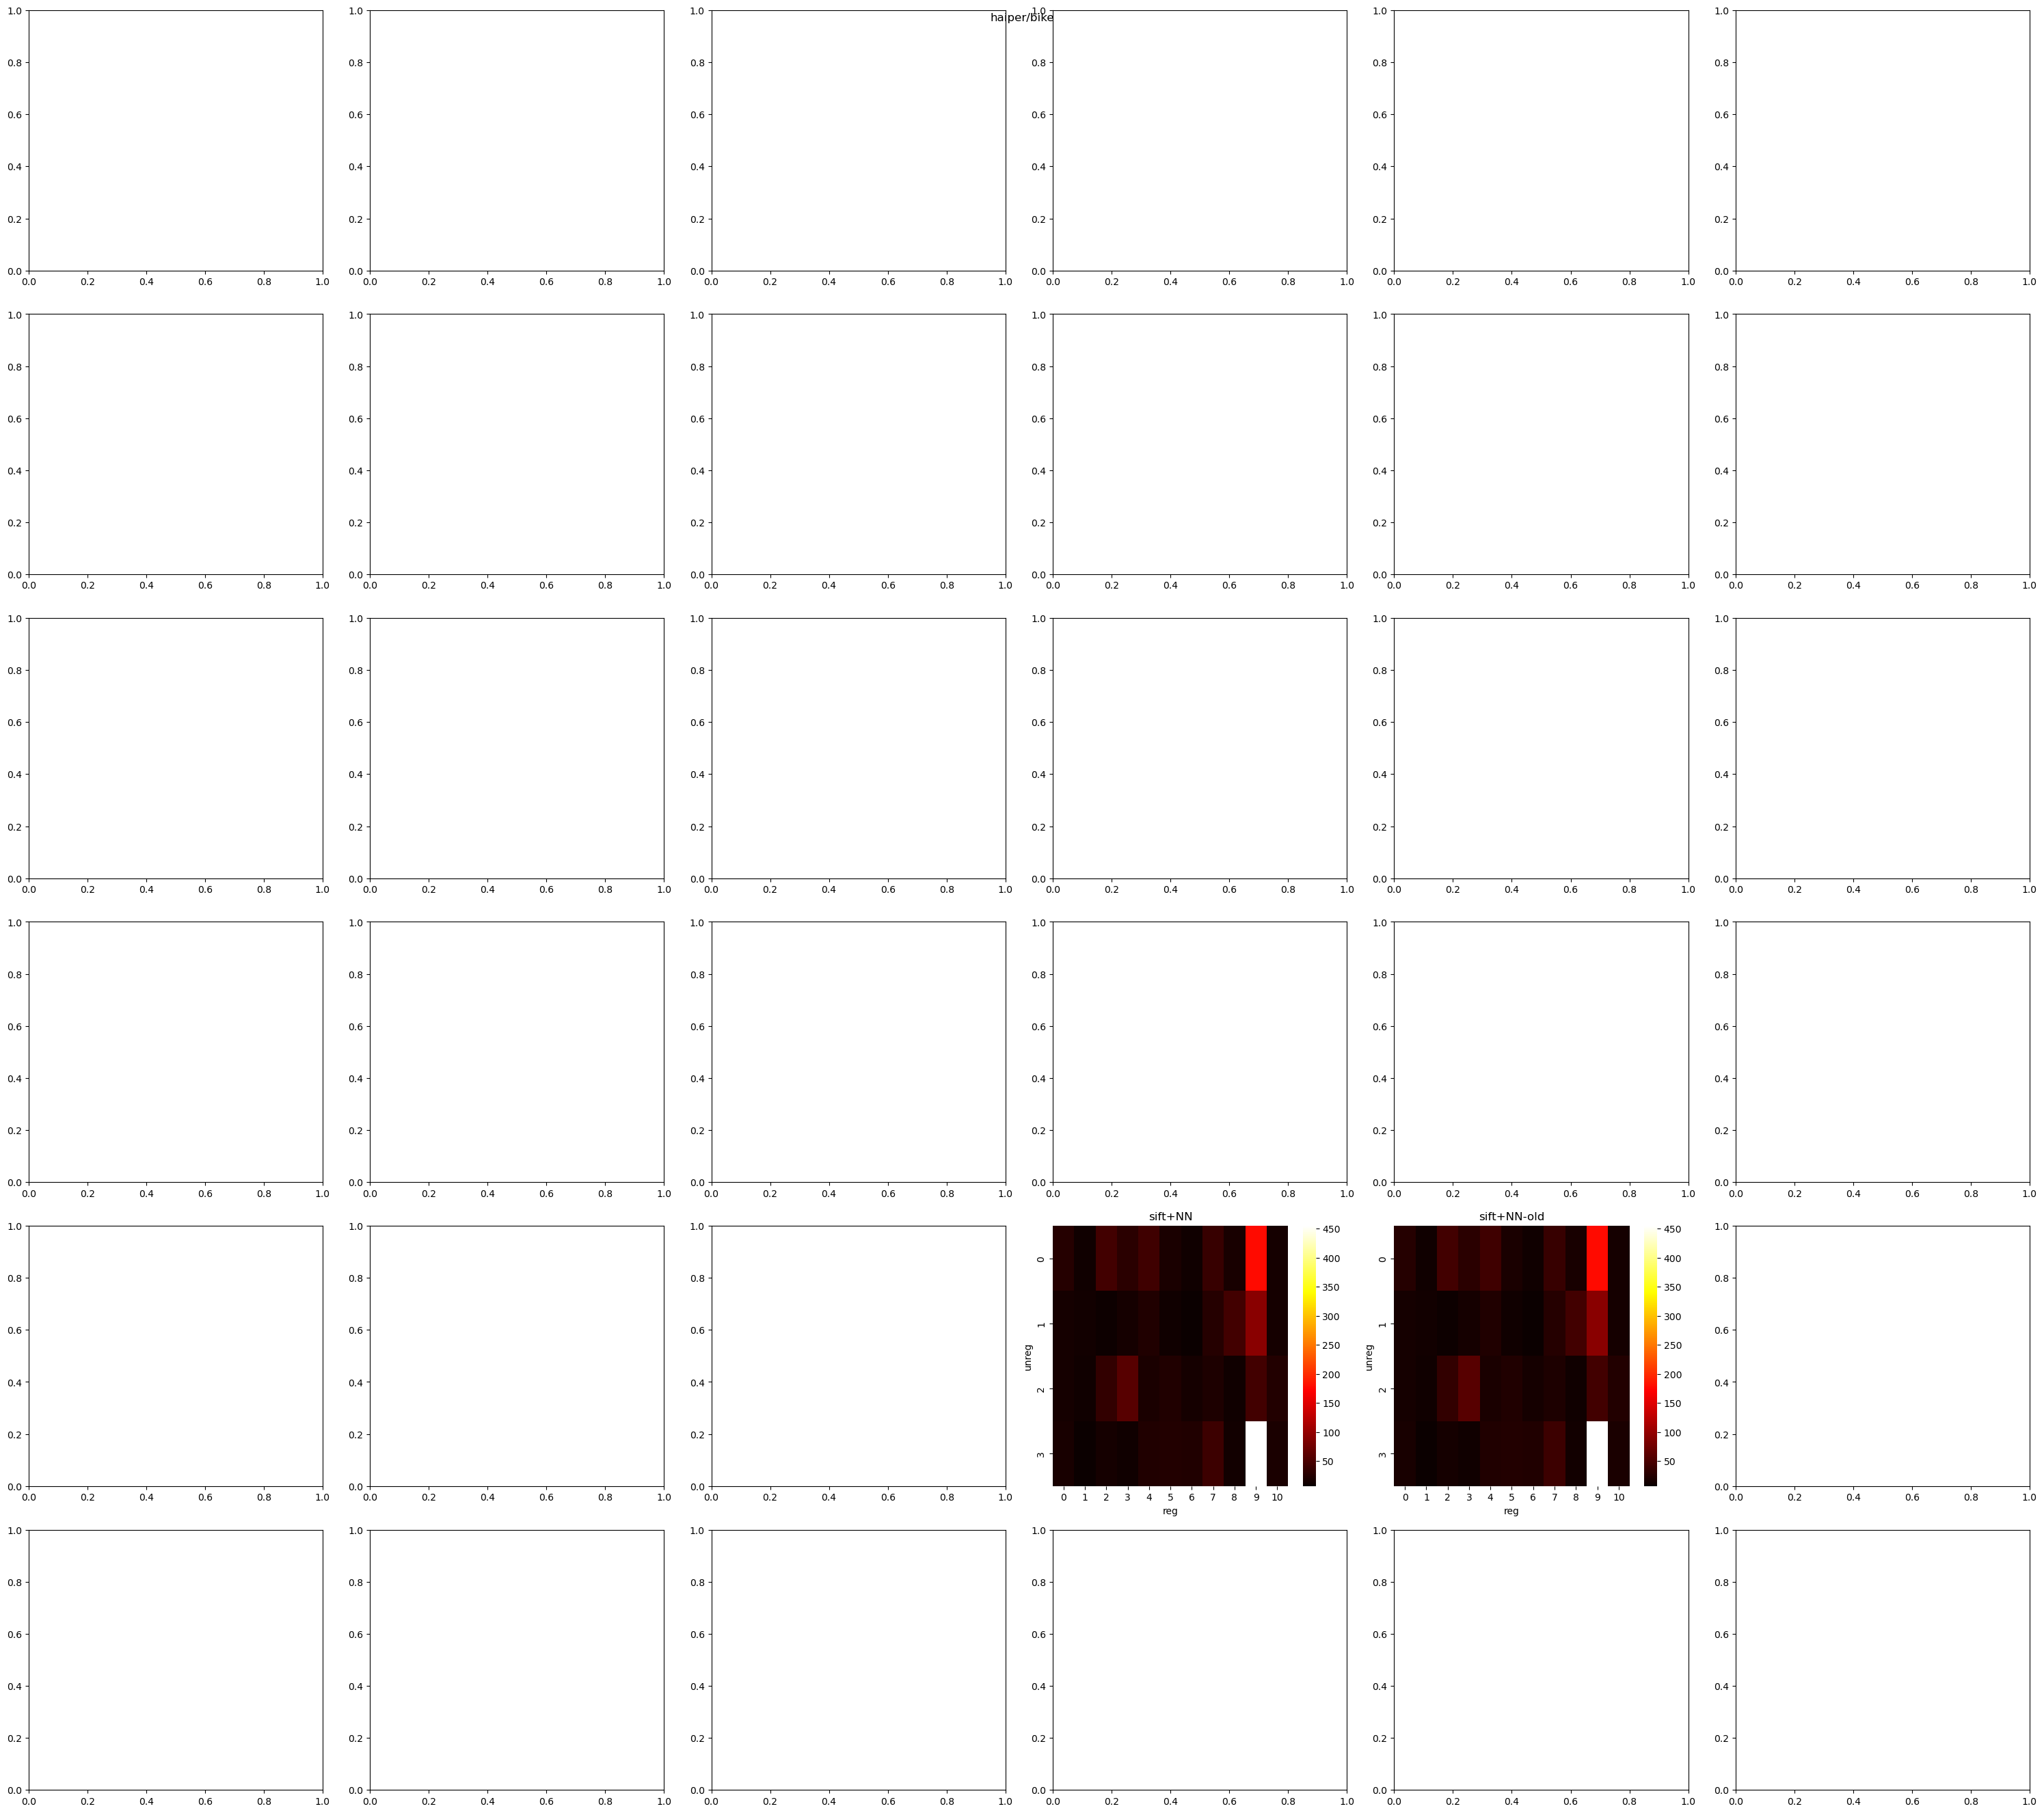

haiper/chairs: 100%|██████████| 29/29 [00:00<00:00, 47.52it/s]


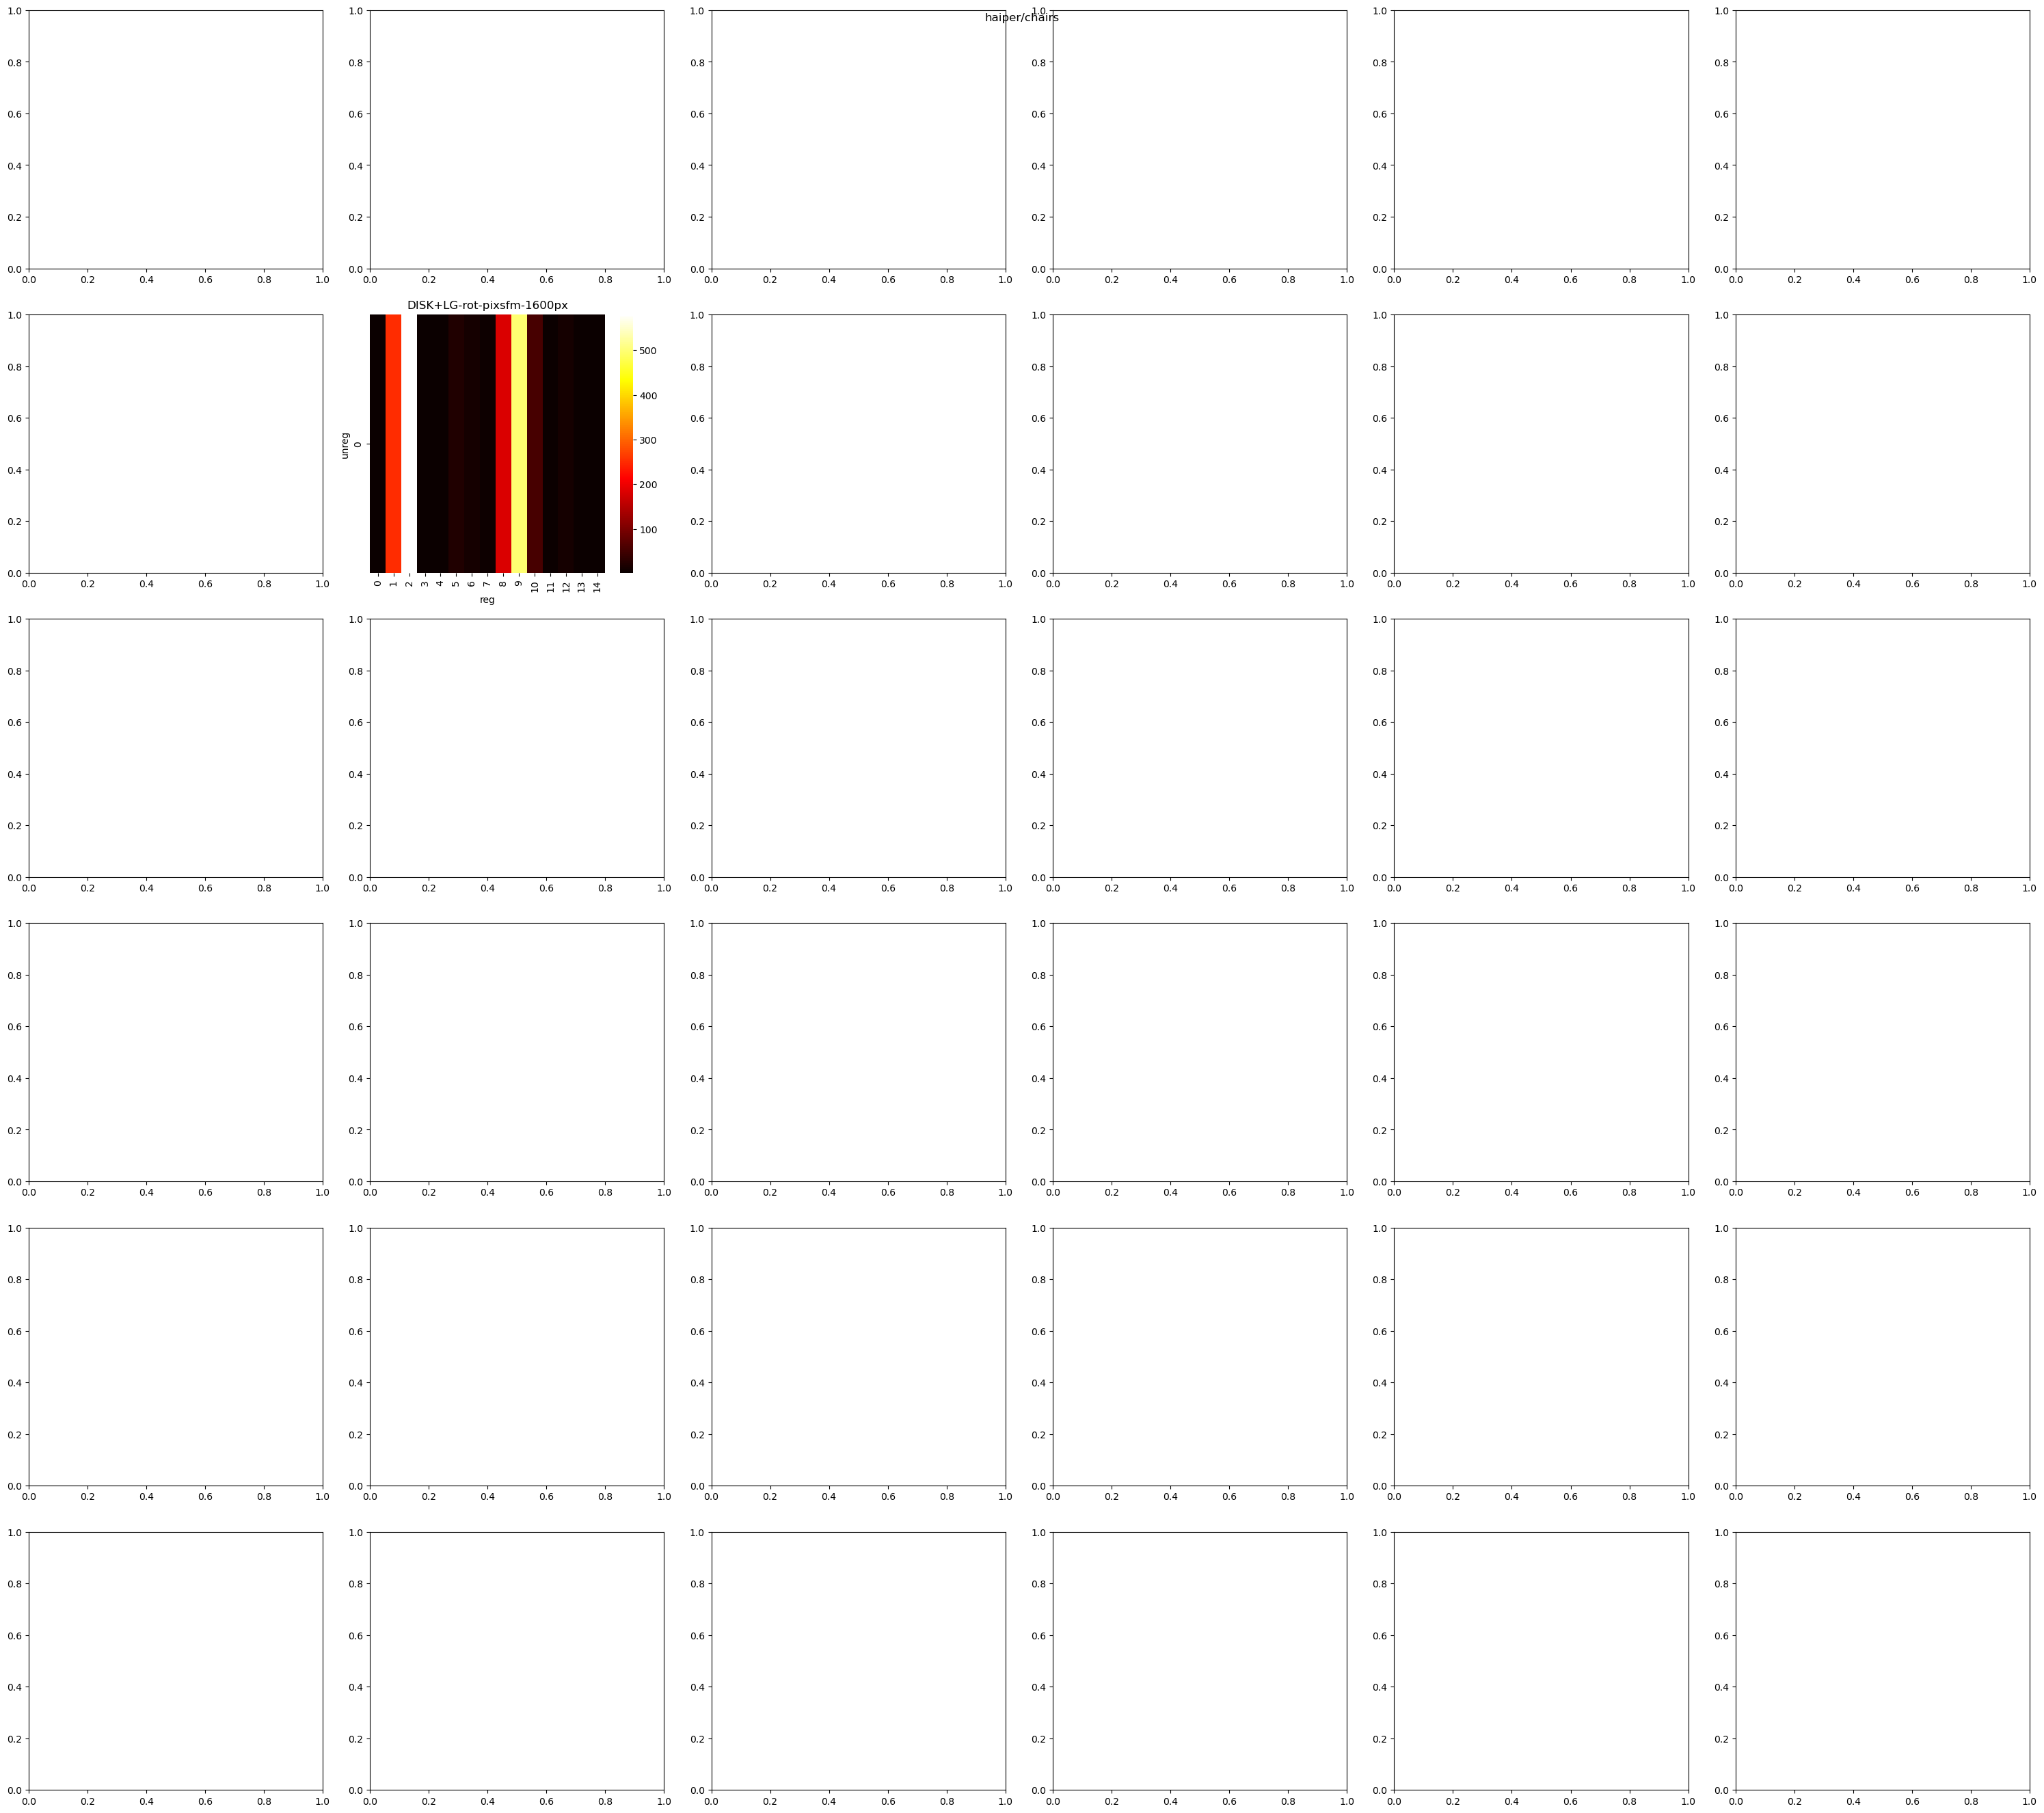

haiper/fountain: 100%|██████████| 29/29 [00:00<00:00, 86.80it/s]


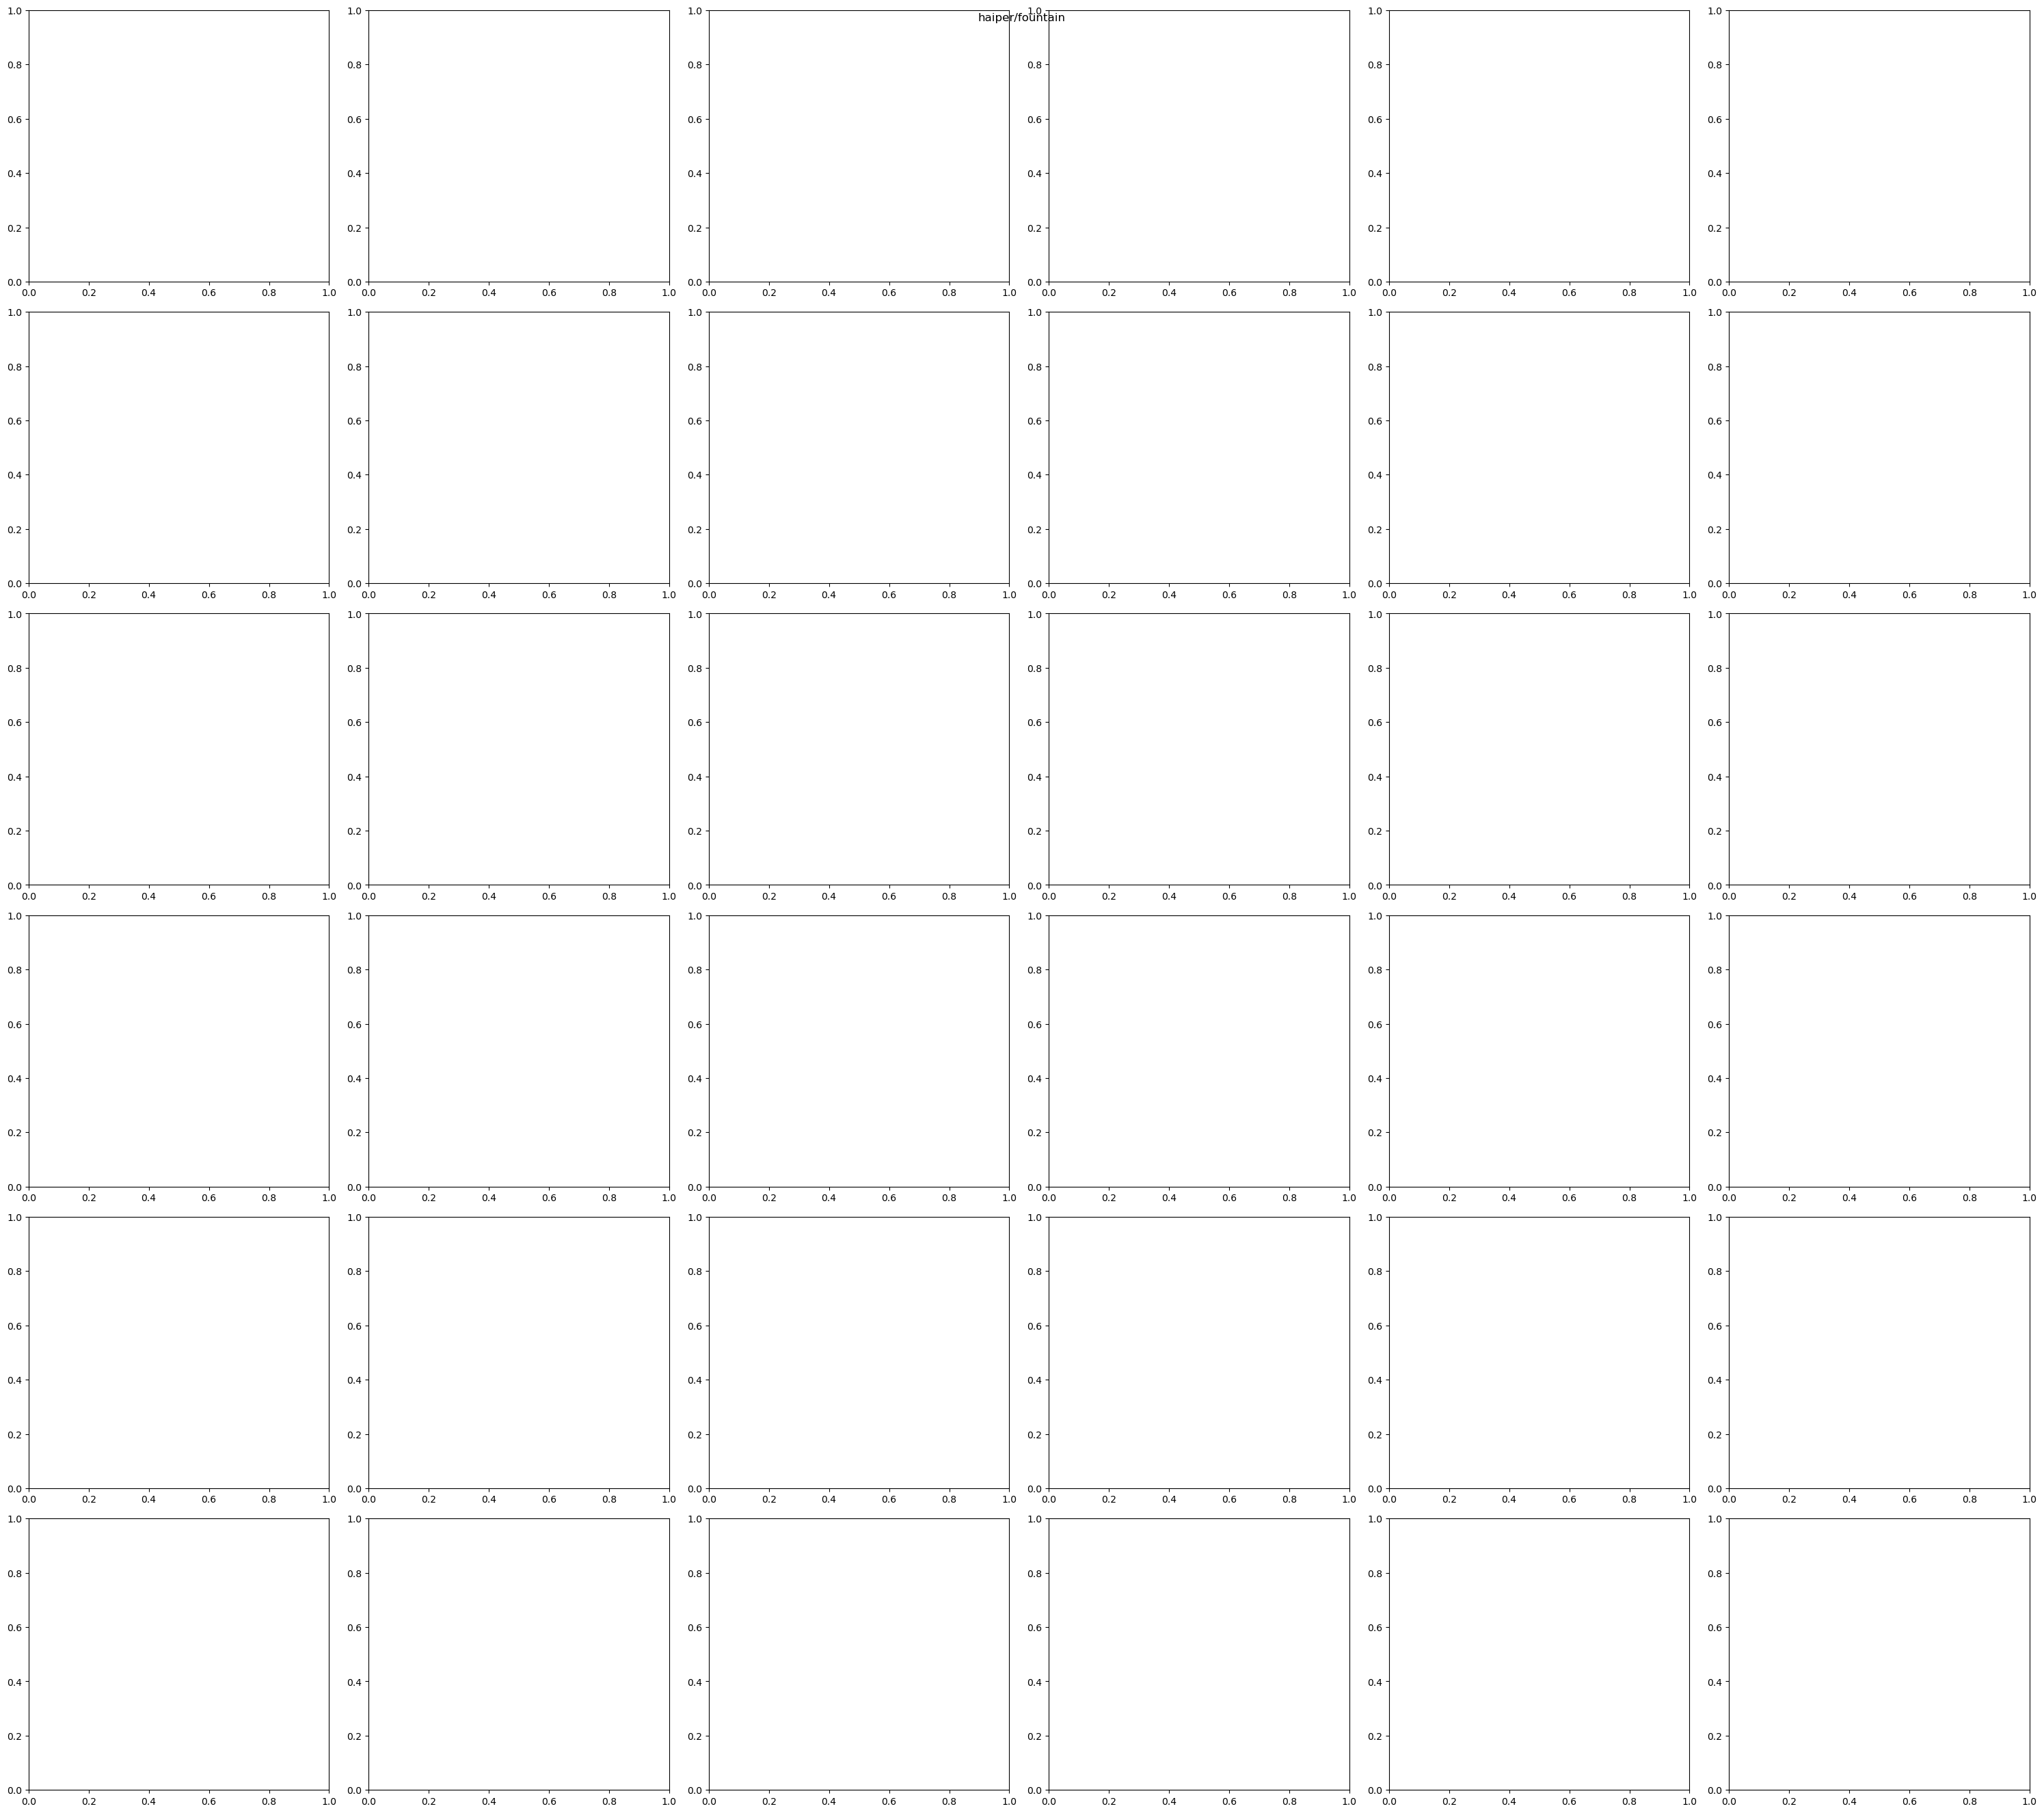

urban/kyiv-puppet-theater: 100%|██████████| 29/29 [15:53<00:00, 32.88s/it]  


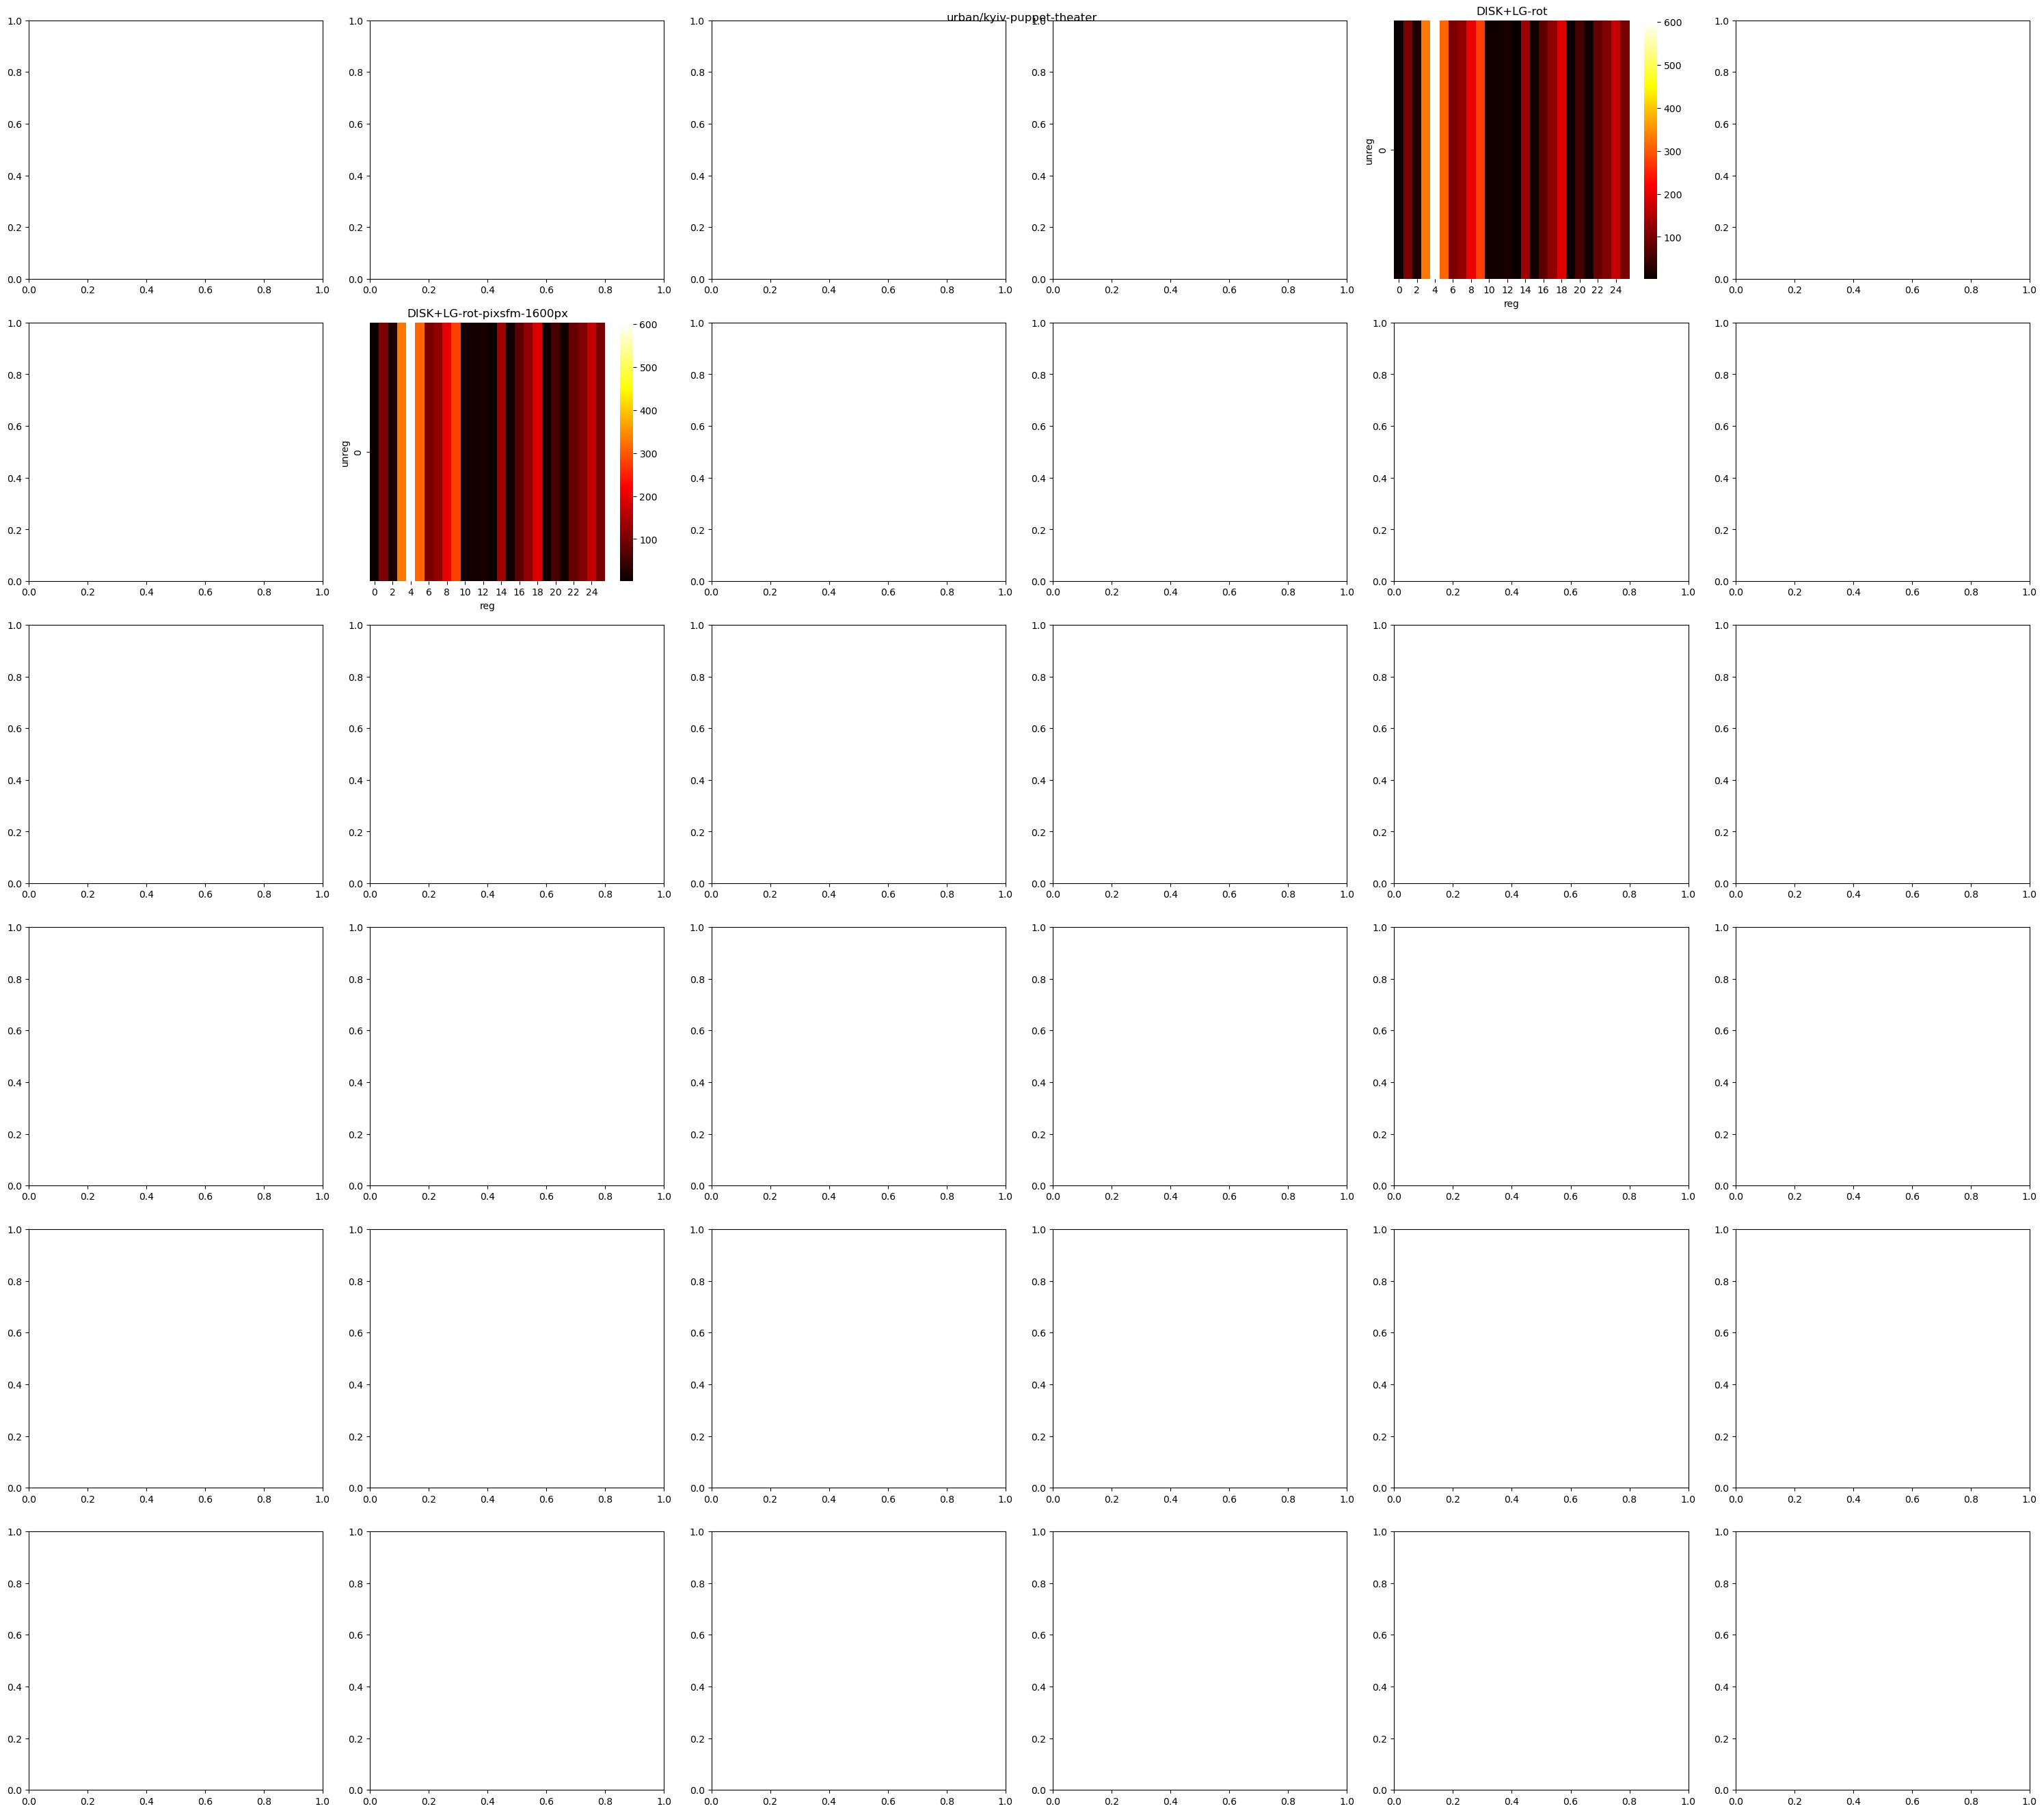

In [54]:

for ds in datasets.keys():
    for j, scene in enumerate(datasets[ds]):
        image_names = metrics[ds][scene]["images"]

        pbar = tqdm(runs, desc=f"{ds}/{scene}")

        rows = np.sqrt(len(runs))
        cols = np.ceil(len(runs) / rows)
        fig, ax = plt.subplots(int(rows+1), int(cols), figsize=(5 * cols, 5 * rows))

        for r_idx, r in enumerate(pbar):

            scene_dir = Path(f"{out_dir}/{r}/{ds}/{scene}")

            matches = scene_dir / "matches.h5"

            if not matches.exists():
                continue

            reg_images = metrics[ds][scene][r]["reg_images"]
            unreg_images = [img for img in image_names if img not in reg_images]

            if not unreg_images or len(reg_images) == 0:
                continue


            pairs = sorted(list_h5_names(matches))

            match_matrix = -np.ones([len(unreg_images), len(reg_images)])
            for pair in pairs:
                name0, name1 = pair.split("/")
                m, sc = get_matches(matches, name0, name1)

                if name0 in unreg_images and name1 in reg_images:
                    idx0, idx1 = unreg_images.index(name0), reg_images.index(name1)
                    match_matrix[idx0, idx1] = m.shape[0]

                elif name1 in unreg_images and name0 in reg_images:
                    idx0, idx1 = unreg_images.index(name1), reg_images.index(name0)
                    match_matrix[idx0, idx1] = m.shape[0]                

            sns.heatmap(
                match_matrix,
                ax=ax[int(r_idx // cols), int(r_idx % cols)],
                cbar=True,
                cmap="hot",
                mask=(match_matrix < 0),
            )

            ax[int(r_idx // cols), int(r_idx % cols)].set_title(r)
            ax[int(r_idx // cols), int(r_idx % cols)].set_xlabel("reg")
            ax[int(r_idx // cols), int(r_idx % cols)].set_ylabel("unreg")

        plt.suptitle(f"{ds}/{scene}")
        plt.tight_layout()
        plt.show()
